# Introduction

This work is a part of my application process for the Data Scientist role at Ahrefs.

## Objective

Our primary goal is to develop a model that can predict if an image is relevant or not to the respective query provided. The solution needs to be able to classify the **irrelevant candidate**. This capability is crucial for search engine optimisation on image search. 

## Scoring Criteria

Scoring criteria will be based on AUC ROC metric. The baseline AUC value for 'dumb' classifier which choose all majority class is 0.5 (base value to beat).

## Assumptions

The following table outlines the assumptions made during the development of this model. These are critical for understanding the scope and limitations of the solution provided.

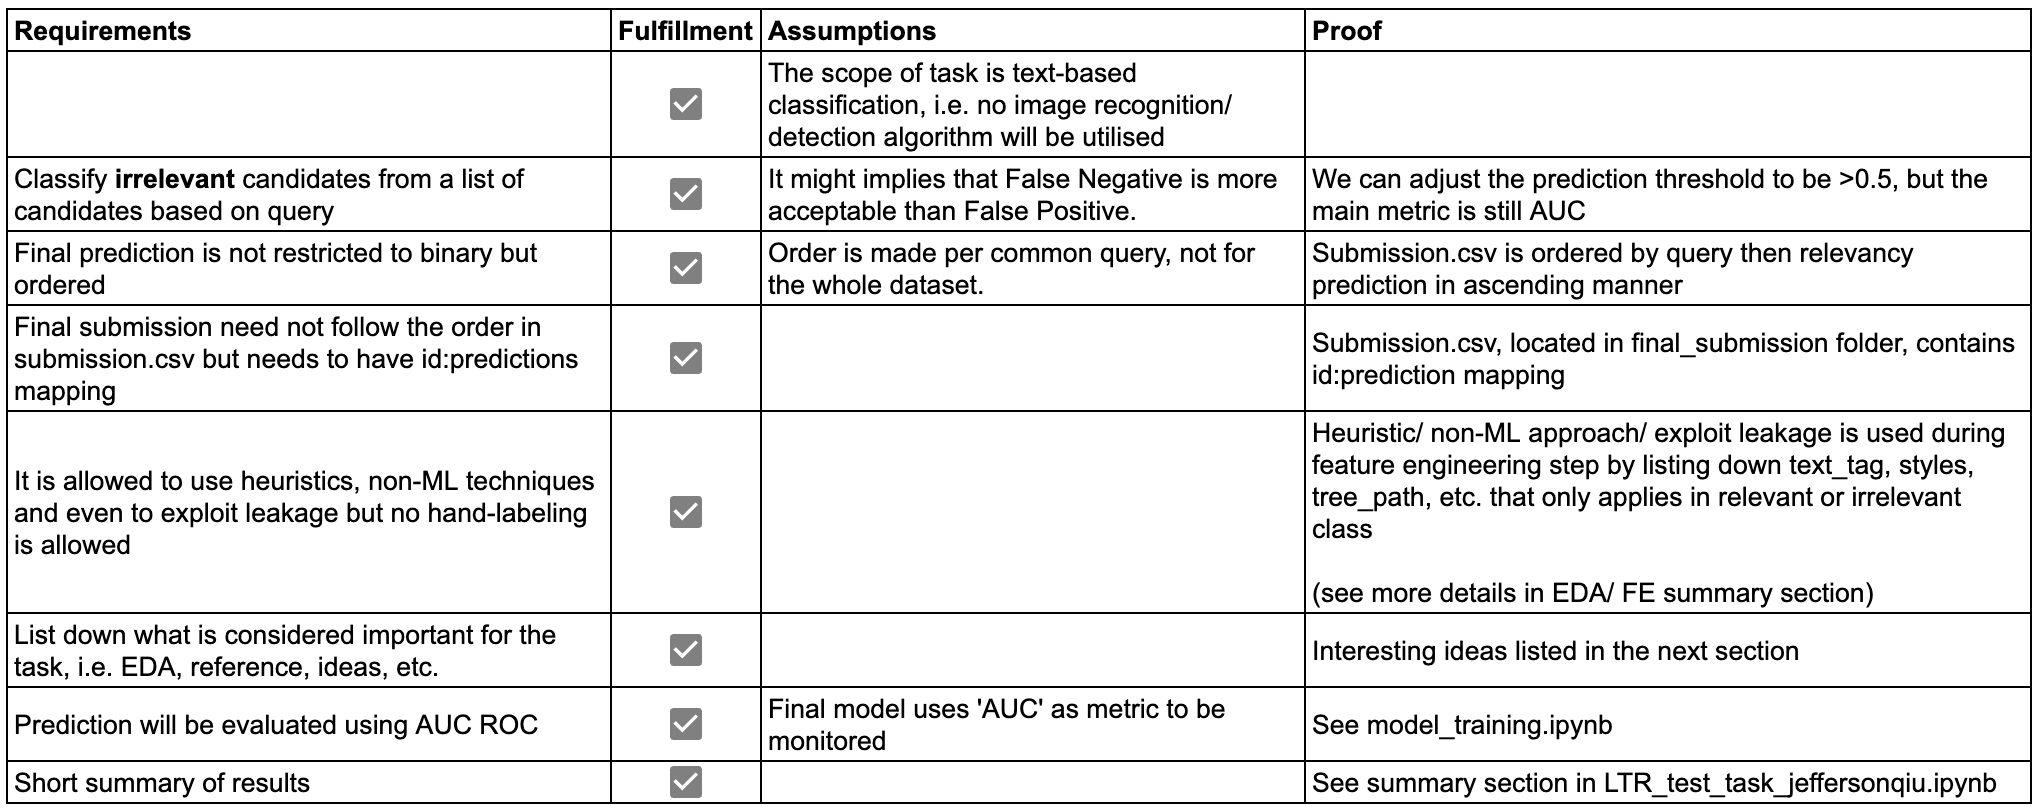

## Interesting Ideas/ Findings/ Frustration



This problem is novel as we aim to determine the image's relevancy without directly looking at the image itself. Therefore, it is vital to devise a strategy extract as much information as possible about the context surrounding the image to solve the problem effectively.

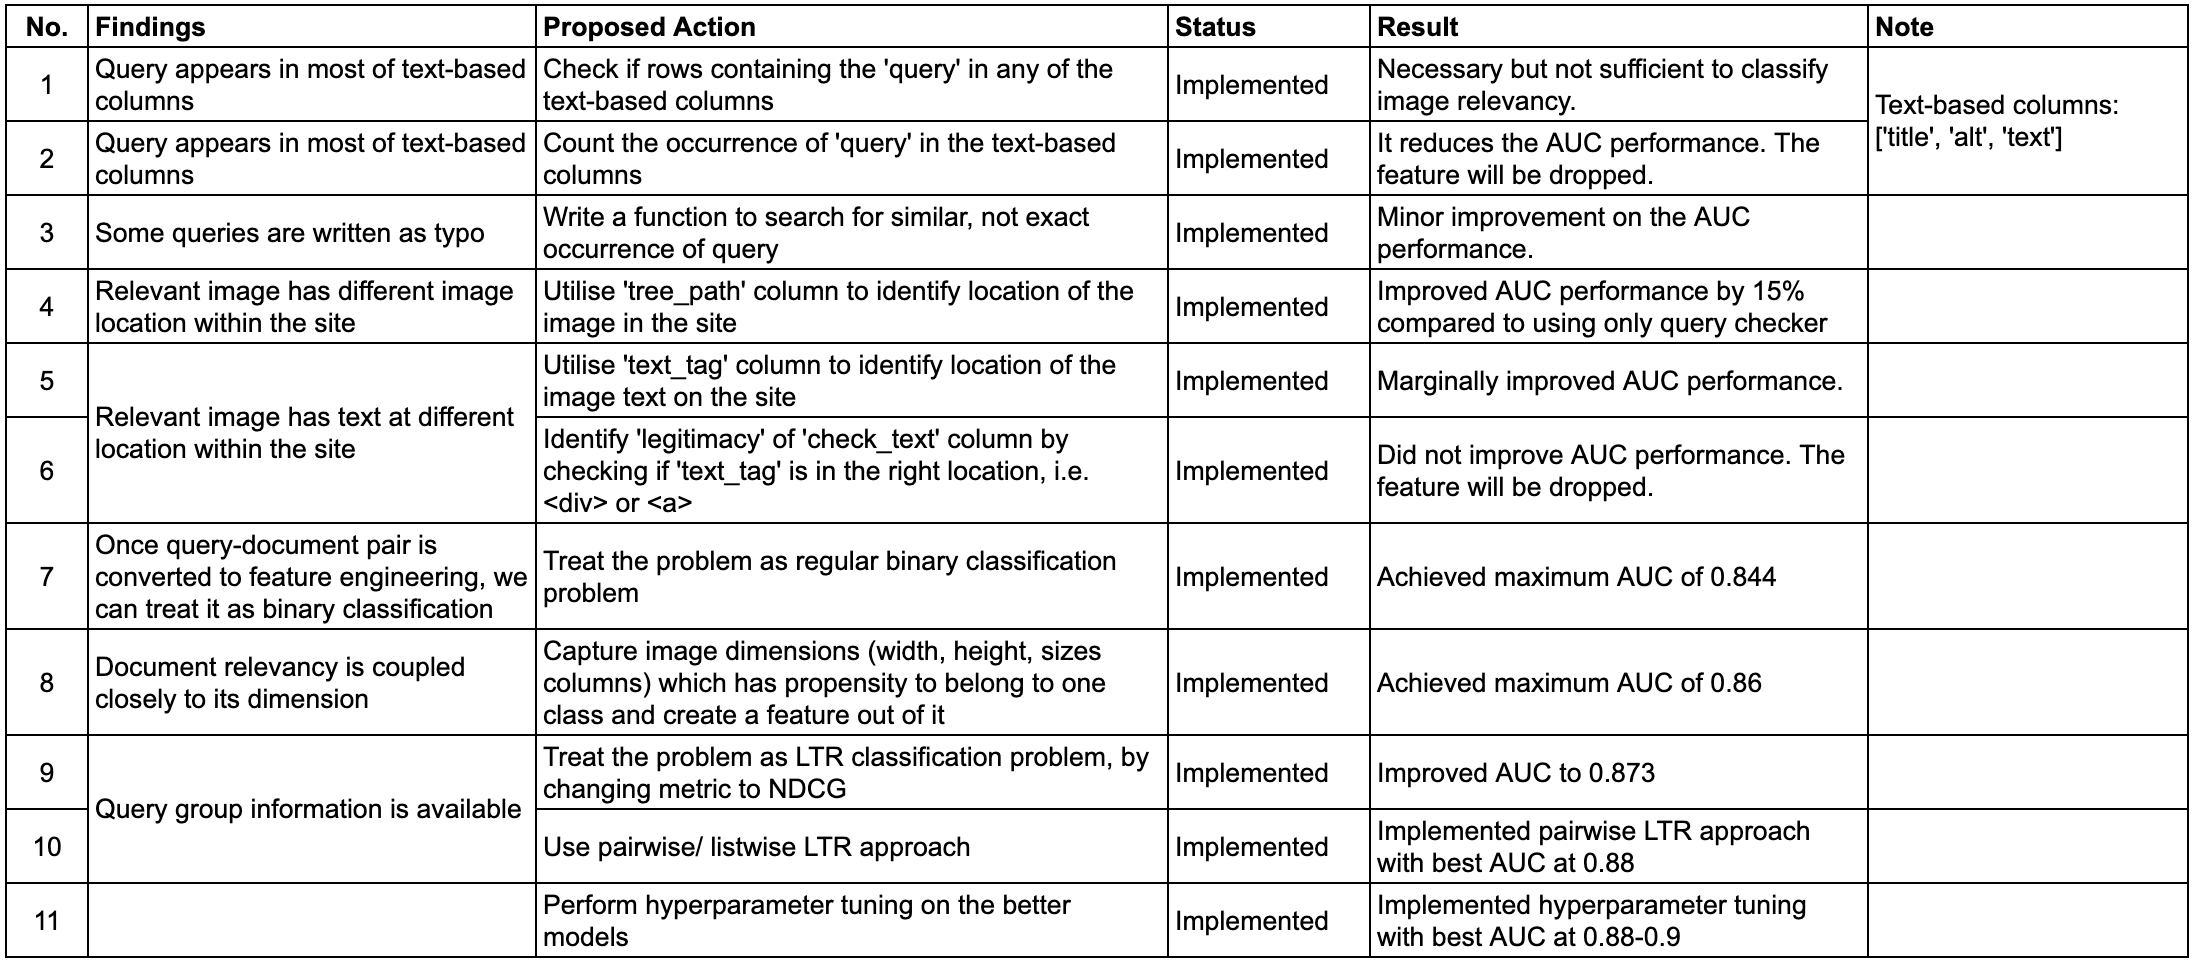

## Summary of EDA and Feature Engineering

#### HTML Definition

After further exploration on the data, here are the definitions for the column in the dataset.<br>
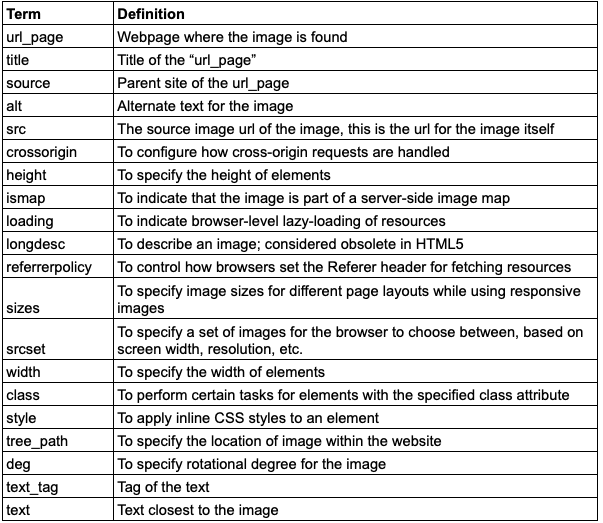




**EXPERT ADVISORY:**
**Just read this part and skip the actual EDA/ FE to dodge potential torment!**

In my observation, the key for this problem lies heavily on the EDA and FE section. A feature that seemingly has no correlation to the relevancy of the document can held such a key role in the model building. I spent a good amount of time (and space in this notebook) on both sections and going through the script can be very taxing. 

Therefore, I have summarised what I did in the table below (still very long, my bad!): <br>
*Note that I used the term 'class' to refer to is_relevant grouping, not actual 'class' column*
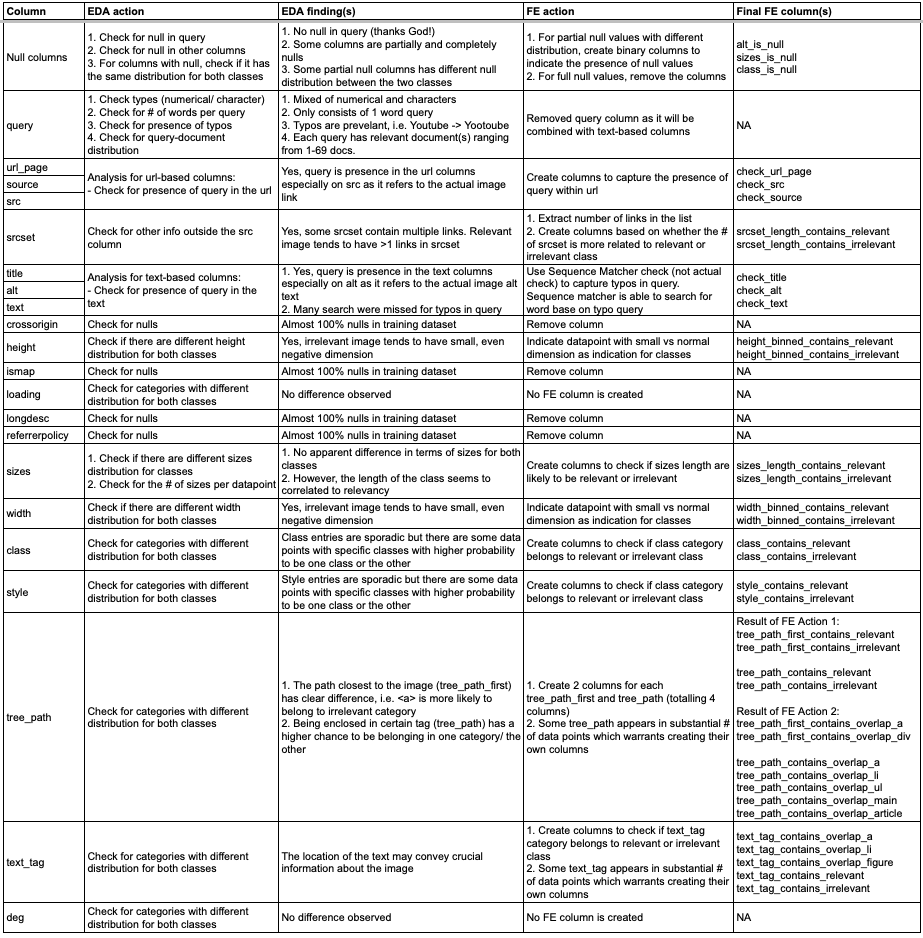

## Feature and Model Selection
### Feature Selection

The feature selection process is conducted to address the issue of parameter collinearity, which can degrade the performance of the model by obscuring the individual impact of parameters. The procedure for eliminating features is as follows:
1. Identify and eliminate one feature from each pair exhibiting a correlation greater than 0.7.
2. Verify that the Variance Inflation Factor (VIF) – a quantifier of multicollinearity in regression analyses – is below 10. If so, proceed with modeling; if not, revisit the first step.

### Model Selection

Three types of models are explored: 
1. Decision Trees-based boosting methods (Light Gradient Boosting Machine [LGBM], Random Forest, CatBoost Model)
2. Probabilistic model (Naive Bayes)
3. Linear Model (Logistic Regression)

A standard parameter training is done for each model. The results for this round are compared based on AUC score. From this, two models stood out as the best performing models, i.g. LGBM and CatBoost Model. 

**Note:** only LGBM model captures the groupping of the query. This allows a traditional Learning to Rank metric (Normalized Discounted Cummulative Gains [NDCG]) and algorithm (pairwise method) to be used. 

### Hyperparameter Tuning

The selected models, LGBM and CatBoost, were subjected to rigorous hyperparameter optimization via the Optuna framework to enhance their performance and stability. This process aims to fine-tune the models' configurations to achieve optimal results. 

Ultimately, both models showed an equally strong results as the AUC comparable with each other at **0.88-0.90 values range** (baseline score is 0.5). However, I finally selected LGBM as the final model as it can be trained in faster than CatBoost Model, thereby, showing its superiority overall. 

### Feature Importance Analysis

Both models showing a different but sensible set of top performing features.
1. LGBM model favors more text-based columns such as alt-text, text description or the url name of the image
2. CatBoost model favors more subtle features such as image location (Tree-path) and image's html attributes such as its dimension

### Final Result

The optimal parameters, identified through the hyperparameter tuning process, were applied to train the model on the entire dataset, to establish the finalized model. This model was subsequently deployed for inference on the test dataset.

The outcomes of the prediction are presented in the form of an id:prediction mapping, where the prediction is provided as a probability value. In this format, a higher value denotes a greater likelihood for relevant document.

## Potential for Improvements

Due to limited time, I didn't manage to complete this initial to do-list:
1. Implement a listwise algorithm on TensorFlow.
2. Utilise a more advanced NLP techniques to pull insights out of the text-based columns such as BM25, BERT, etc.
3. Consider using PR-AUC to observe actual model performance on imbalance-class.
4. As opposed to focus only on text-based feature, we can use model such as CLIP to check the image and predict relevancy based on the query-image similarity score

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import random

from difflib import SequenceMatcher

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn import svm

import optuna
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier, LGBMRanker
from catboost import CatBoostClassifier, CatBoostRanker
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from collections import Counter

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# EDA Imports
from src.eda import null_columns_checker, column_investigator, find_unique_values, analyser_generic, tree_path_investigator
from src.eda import non_numeric_check, dimension_investigator

# FE Imports
from src.fe import indicate_nulls, fuzzy_search, dynamic_check_text, check_columns_on_query, check_columns_on_text 
from src.fe import dim_binner, check_columns_on_dim, column_dropper

# Feature Model Selectin Imports
from src.feature_model_selection import find_high_corr_pairs, manual_pr_draw, manual_auc_roc_draw, groupper

In [4]:
train_file_path= 'data/train.feather'
test_file_path= 'data/test.feather'
ori_train_df = pd.read_feather(train_file_path)
ori_test_df = pd.read_feather(test_file_path)

## Exploratory Data Analysis

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
pd.set_option('display.max_colwidth', 400)

In [7]:
ori_train_df.head(5)

,query,url_page,title,source,alt,src,crossorigin,height,ismap,loading,longdesc,referrerpolicy,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,is_relevant
0,011103093,https://bank-routing.org/011103093-td-bank-na-routing-number,"Routing Number 011103093 - TD Bank NA in LEWISTON, Maine | Bank-Routing.org",bank-routing.org,Bank Routing,https://bank-routing.org/img/logo.png,None,None,None,None,None,None,None,None,None,None,None,"[a, div, nav, header, body, html]",2.0,div,Blog Contacts,3f5e067733178cc0f4b3a97cfc9c62e1,0
1,011103093,https://bank-routing.org/011103093-td-bank-na-routing-number,"Routing Number 011103093 - TD Bank NA in LEWISTON, Maine | Bank-Routing.org",bank-routing.org,011103093 routing number on TD Bank NA check,https://bank-routing.org/img/routing_numbers/routing-example-011103093.png,None,None,None,None,None,None,None,None,None,img-fluid,None,"[div, div, div, main, main, body, html]",1.0,div,"Aside from the SWIFT code which each bank is delegated for transfers that are global, you should indicate that your bank routing number. This info is your bank's identifier; you're using in your city, by signaling the bank routing number, you streamline the transfer of capital. The number of TD Bank NA is 011103093; it can be used by you also. It is essential to indicate the bank. So, where to...",fe64168fa7afeefa73708113c4bc2730,1
2,011103093,https://bank-routing.org/011103093-td-bank-na-routing-number,"Routing Number 011103093 - TD Bank NA in LEWISTON, Maine | Bank-Routing.org",bank-routing.org,DMCA.com Protection Status,https://images.dmca.com/Badges/dmca_protected_sml_120n.png?ID=a6611608-9929-41c8-b3a9-616af4256889,None,None,None,None,None,None,None,None,None,None,None,"[a, p, div, div, div, footer, body, html]",NaN,None,None,5b5c3b6560ae158bf7ecd09f5ead1841,0
3,011103093,https://bank-routing.org/011103093-td-bank-na-routing-number,"Routing Number 011103093 - TD Bank NA in LEWISTON, Maine | Bank-Routing.org",bank-routing.org,Quantcast,https://pixel.quantserve.com/pixel/p-1meCEwxYU8pDX.gif,None,1,None,None,None,None,None,None,1,None,None,"[div, noscript, body, html]",3.0,body,"Blog Contacts Bank Routing Numbers -> TD Bank NA -> Maine -> 011103093 011103093 Routing Number Routing Number 011103093 Bank Name TD Bank NA Status Valid, last updated: Oct 25, 2021 Office Type Main Office Servicing FRB Number 011000015 Servicing FRB Number Address 600 Atlantic Avenue Boston, Boston, MA Address P.O. BOX 1377, LEWISTON, ME, 04240 City LEWISTON Zipcode 04240-1377 Phone (877) 89...",91fe71b49453d9037769b5a99c6f0856,0
4,011103093,https://www.gobankingrates.com/banking/banks/td-bank-routing-number-connecticut/,TD Bank Routing Number in Connecticut: 211370545 | GOBankingRates,gobankingrates.com,Loading...,https://cdn.gobankingrates.com/wp-content/themes/rockefeller-lite/assets/src/images/best-banks-2021/spinner-solid.svg.gzip,None,None,None,None,None,None,None,None,None,None,None,"[span, form, div, div, div, main, body, html]",2.0,form,Sign-Up Now Please enter an email. Please enter a valid email address. There was an unknown error. Please try again later.,021b4f809739c93f6ff913ce7389a9c9,0


#### Quick Data Review

In [8]:
total_data = len(ori_train_df)
relevant_doc_count = sum(ori_train_df['is_relevant'] == 1) 
irrelevant_doc_count = total_data - relevant_doc_count
relevant_document_rate = round(relevant_doc_count / len(ori_train_df)*100,1)
unique_queries = ori_train_df['query'].nunique()

print(f'Total document count: {total_data}')
print(f'Number of unique queries: {unique_queries}')
print(f'Relevant document rate: {relevant_document_rate}%\n')

Total document count: 607844
Number of unique queries: 733
Relevant document rate: 3.6%



In [9]:
ori_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607844 entries, 0 to 607843
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   query           607844 non-null  object 
 1   url_page        607844 non-null  object 
 2   title           607844 non-null  object 
 3   source          607844 non-null  object 
 4   alt             516612 non-null  object 
 5   src             607844 non-null  object 
 6   crossorigin     318 non-null     object 
 7   height          245583 non-null  object 
 8   ismap           9 non-null       object 
 9   loading         119335 non-null  object 
 10  longdesc        1469 non-null    object 
 11  referrerpolicy  324 non-null     object 
 12  sizes           64987 non-null   object 
 13  srcset          105818 non-null  object 
 14  width           256371 non-null  object 
 15  class           309950 non-null  object 
 16  style           77903 non-null   object 
 17  tree_path 

In [10]:
ori_train_df.describe()

,deg,is_relevant
count,423801.000000,607844.000000
mean,2.075210,0.035925
std,0.757783,0.186104
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,0.000000
max,3.000000,1.000000


### Looking at the Data

In [11]:
ori_train_df[['src', 'query', 'is_relevant']].head(6)

,src,query,is_relevant
0,https://bank-routing.org/img/logo.png,011103093,0
1,https://bank-routing.org/img/routing_numbers/routing-example-011103093.png,011103093,1
2,https://images.dmca.com/Badges/dmca_protected_sml_120n.png?ID=a6611608-9929-41c8-b3a9-616af4256889,011103093,0
3,https://pixel.quantserve.com/pixel/p-1meCEwxYU8pDX.gif,011103093,0
4,https://cdn.gobankingrates.com/wp-content/themes/rockefeller-lite/assets/src/images/best-banks-2021/spinner-solid.svg.gzip,011103093,0
5,https://cdn.gobankingrates.com/wp-content/uploads/2017/05/TD-Bank-routing-number.jpg?w=675&quality=75,011103093,0


In [12]:
ori_train_df[['src', 'query', 'is_relevant']].sample(6)

,src,query,is_relevant
47463,https://alternative.me/media/256/sleeknote-icon-cjotluyipufarshp-c.png,activedemand,0
593168,https://cdn.taschen.com/media/images/960/japanese_woodblock_prints_xl_int_book001_x_01168_2001231402_id_1295269.jpg,woodblock,0
487443,https://bravebelle.com/wp-content/uploads/2015/01/self-love.png,senuality,0
108903,https://static01.nyt.com/images/2015/10/27/dining/27COOKING-ROASTTURKEY/27COOKING-ROASTTURKEY-mediumThreeByTwo440.jpg,congee,0
29186,http://www.game-art-hq.com/wp-content/uploads/2015/11/discord-gahq.jpg,sheeik,0
38130,https://www.free-jav-sex.com/en/wp-content/uploads/sites/2/2020/01/nyoshin-free-jav-porn-video-4-i-am-your-masturbation-doll-uncensored-image-300x168.png,1919gogo,0


In [13]:
ori_train_df.iloc[188892]

query                                                                                                       cablbar
url_page          https://www.skimble.com/exercises/59300-cable-bar-standing-decline-chest-press-how-to-do-exercise
title                        Cable Bar Standing Decline Chest Press - Exercise How-to - Workout Trainer  by Skimble
source                                                                                                  skimble.com
alt                                                      How to do: Cable Bar Standing Decline Chest Press - Step 1
src                                           https://s3.amazonaws.com/prod.skimble/assets/2137228/image_iphone.jpg
crossorigin                                                                                                    None
height                                                                                                         None
ismap                                                                   

**Key Points:**
- Apart from the relevant pictures, irrelevant pictures contains logos, profile pictures, random assets, etc. that the site contains.
- **Many relevant images do not contains the query** in the src while **many irrelevant images contain the query in the src**.
- As we are not to open each picture one by one, we need to find a way to tell if the picture is relevant just based on other html information.

### Query Column

In [14]:
unique_relevant_results = sum(ori_train_df.groupby('query').agg({'is_relevant': 'max'})['is_relevant'])
all_query_has_relevant_doc = unique_queries == unique_relevant_results

print(f'Is each query has corresponding relevant document(s): {all_query_has_relevant_doc}')

Is each query has corresponding relevant document(s): True


In [15]:
unique_queries = ori_train_df['query'].unique()
unique_queries[:50]

array(['011103093', 'acdsee', 'ajw', 'alltvshows', 'anupama', 'asshai',
       'athleticism', 'bintje', 'brwves', 'curiouse', 'dorma', 'dotf',
       'eldery', 'expiratory', 'freepsports', 'huohu', 'kandil', 'kimaya',
       'koshas', 'kronenwetter', 'lazik', 'leucorrhea', 'minneapolus',
       'naisha', 'nmtcb', 'novitex', 'nyloplast', 'pidget', 'prevaile',
       'redtubexvideos', 'rendered', 'samule', 'sheeik', 'sologne',
       'synthesio', 'thethao24h', 'udump', 'usd287', 'veriscan', 'vetbiz',
       'weaponology', '1652', '1919gogo', '1password7', '23xi', '326',
       '351427', '4uhair', '5972', '60504'], dtype=object)

In [16]:
# Check the number of words in each query

dict(Counter([len(item.split()) for item in unique_queries]))

{1: 733}

In [17]:
query_counts = ori_train_df.groupby('query').agg(
    relevant_count=('is_relevant', 'sum'),
    total_count=('is_relevant', 'count')
)
query_counts['relevant_percentage'] = round((query_counts['relevant_count'] / query_counts['total_count']) * 100, 1)
query_counts.sample(5)

,relevant_count,total_count,relevant_percentage
query,,,
cannanites,33,1524,2.2
transynd,19,605,3.1
ar6,45,1173,3.8
goddess07,30,1160,2.6
porlalivre,18,649,2.8


In [18]:
# Calculate averages and max/min values
average_relevant_count = round(query_counts['relevant_count'].mean())
average_relevant_percentage = round(query_counts['relevant_percentage'].mean(), 1)
max_relevant_count = query_counts['relevant_count'].max()
min_relevant_count = query_counts['relevant_count'].min()
max_relevant_percentage = query_counts['relevant_percentage'].max()
min_relevant_percentage = query_counts['relevant_percentage'].min()

# Calculate percentiles and median for relevant_count
p20_relevant_count = round(query_counts['relevant_count'].quantile(0.20))
p80_relevant_count = round(query_counts['relevant_count'].quantile(0.80))
median_relevant_count = round(query_counts['relevant_count'].median())

# Display the results
print(f'Average count of is_relevant == 1: {average_relevant_count}')
print(f'Average percentage of is_relevant == 1: {average_relevant_percentage}%')
print(f'Max count of is_relevant == 1: {max_relevant_count}')
print(f'Min count of is_relevant == 1: {min_relevant_count}')
print(f'Max percentage of is_relevant == 1: {max_relevant_percentage}%')
print(f'Min percentage of is_relevant == 1: {min_relevant_percentage}%\n')
print(f'20th percentile of relevant count: {p20_relevant_count}')
print(f'80th percentile of relevant count: {p80_relevant_count}')
print(f'Median of relevant count: {median_relevant_count}\n')


Average count of is_relevant == 1: 30
Average percentage of is_relevant == 1: 4.2%
Max count of is_relevant == 1: 69
Min count of is_relevant == 1: 1
Max percentage of is_relevant == 1: 24.1%
Min percentage of is_relevant == 1: 1.0%

20th percentile of relevant count: 18
80th percentile of relevant count: 41
Median of relevant count: 30



**Key Points**: 
- The queries consist of a combination of text and numeric strings, each being a single word.
- Some of the queries **included typos**.
- Each query doesn't have a fix number of relevant documents. Relevant documents ranges from 1 to 69 docs.
- Percentage of relevant query from total candidates ranges quite wide also from 1-24%.

### Other Columns

#### Null Columns

In our analysis, we pay special attention to the discrepancies in proportions of certain behaviors between different classes, as these discrepancies can be indicative of underlying patterns that are crucial for classification.

Consider an example where we're classifying data points into relevancy based on the presence of a specific feature, null presence in a certain column. Example:<br>

Class 0: 25% of data points have null in class == 'fake_class'.<br>
Class 1: 50% of data points have null in class == 'fake_class'.<br>

The discrepancy here is not just a numerical difference but a significant indicator of how each class is characterized by this feature. Specifically, data points in Class 1 are **twice** (50%/25%) as likely to exhibit the feature null in class == 'fake_class' compared to those in Class 0.

*Understanding Discrepancies **Ratio***:<br>
The proportion of data points (**Ratio**) exhibiting a particular behavior within each class can be thought of as a signature or fingerprint of that class. This analysis will be repeated for each column to extract as much information as possible to train our model.

In [20]:
check_df, null_check_columns, columns_to_drop = null_columns_checker(ori_train_df, 0.9, 1.1)
check_df

null_check_columns:  ['alt', 'sizes', 'class']
columns_to_drop:  ['crossorigin', 'ismap', 'longdesc', 'referrerpolicy']


,Rel: % of Null,Irrel: % of Null,Ratio,Null Check Potential
query,0.0,0.0,NaN,False
url_page,0.0,0.0,NaN,False
title,0.0,0.0,NaN,False
source,0.0,0.0,NaN,False
alt,9.3,15.2,0.61,True
src,0.0,0.0,NaN,False
crossorigin,99.9,100.0,1.00,False
height,59.3,59.6,0.99,False
ismap,100.0,100.0,1.00,False
loading,81.4,80.3,1.01,False


**Key Points**:
- Columns with close to 100% null are not useful in providing information and shall be removed. These columns are *crossorigin*, *ismap*, *longdesc*, *loading* and *referrerpolicy*.
- Some other columns have a relatively higher difference in null value than the others. With a Ratio threshold of <0.9 or >1.1, these columns are some potential columns to be used in feature engineering: *alt*, *sizes* and *class*.

#### Text and URL Columns

Intuitively, a relevant document/ image contains a literal mention of the query within the url or alt text. 

During feature engineering phase, we can extract this information into count of occurrence, binary occurence check or any other more advanced NLP methods.

In [21]:
target_columns = ['url_page', 'title', 'source', 'alt', 'src', 'srcset', 'text']
ori_train_df[['query', 'is_relevant'] + target_columns].sample(2)

,query,is_relevant,url_page,title,source,alt,src,srcset,text
245399,dnails,0,https://www.npmarketcenter.com/directory_type/d-nails/dnails-2/,DNAILS - North Point Market Center,npmarketcenter.com,,https://secureservercdn.net/198.71.233.235/xk1.253.myftpupload.com/wp-content/uploads/DNAILS.png?time=1633716064,"https://secureservercdn.net/198.71.233.235/xk1.253.myftpupload.com/wp-content/uploads/DNAILS.png 600w, https://secureservercdn.net/198.71.233.235/xk1.253.myftpupload.com/wp-content/uploads/DNAILS-300x102.png 300w",None
575540,ussa,0,https://bluemassgroup.com/2017/01/back-in-the-u-s-s-a/,Back in the U.S.S.A. | Blue Mass Group,bluemassgroup.com,IanCMackenzie,https://pbs.twimg.com/profile_images/1422903687459004419/RtglL6we_normal.jpg,None,Ian C Mackenzie @IanCMackenzie · 2h


**Key Points:**
- Text-based columns can be divided into two types, i.e. human-readable columns (text_columns) such as *title*, *alt*, and *text* and url-related columns (url_columns) such as *url_page*, *source*, *src*, and *srcset*.
- The presence of a query within text_columns doesn't necessarily correlate with image relevance.
- It's observed that there's a hierarchy in the predictive value of text_columns for determining relevance. Logically, *text* ranks higher than *source*, which in turn is deemed more predictive than *url_page*.


#### Tree Path
Intuitively, Tree path is another interesting avenue to obtain crucial information about whether or not the image is relevant. 

For example, if we are looking for an image of 'microscope' and the search engine shows us wikipedia page, it is more likely that the relevant image resides in the **body** of the site rather than the **header**.

In [22]:
ori_train_df[ori_train_df['is_relevant'] == 0][['query', 'is_relevant', 'tree_path']].sample(2)

,query,is_relevant,tree_path
138138,maturemoms,0,"[a, div, div, div, div, div, body, html]"
66231,ar6,0,"[strong, div, li, ul, div, section, div, div, body, html]"


In [23]:
ori_train_df[ori_train_df['is_relevant'] == 1][['query', 'is_relevant', 'tree_path']].sample(2)

,query,is_relevant,tree_path
86921,be10acp,1,"[button, li, ul, div, div, li, ul, div, div, div, div, div, div, div, div, div, div, div, main, div, body, html]"
18179,kronenwetter,1,"[div, figure, div, div, section, div, div, div, div, div, div, body, html]"


##### Tree Path First
= The first item in the tree_path

In [25]:
ori_train_df['tree_path_first'] = ori_train_df['tree_path'].apply(lambda x: x[0] if len(x) else None)

df = ori_train_df
column_to_investigate = "tree_path_first"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  ['p', 'figure', 'body', 'header', 'strong', 'section', 'article', 'center']
irrel_feature_potential:  ['a', 'button', 'font', 'i', 'label', 'h4', 'form', 'wix-image']
Total Data covered: 48.9%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
tree_path_first,,,,,,,
a,4644,247728,252372,41.5,21.3,42.3,0.50
div,9257,145579,154836,25.5,42.4,24.8,1.71
noscript,2080,94677,96757,15.9,9.5,16.2,0.59
span,537,22420,22957,3.8,2.5,3.8,0.66
p,1659,13986,15645,2.6,7.6,2.4,3.17
figure,1259,14724,15983,2.6,5.8,2.5,2.32
picture,637,10389,11026,1.8,2.9,1.8,1.61
source,528,7570,8098,1.3,2.4,1.3,1.85
li,296,7793,8089,1.3,1.4,1.3,1.08


**Key Points:**
- The table above shows that if the image is enclosed within *a*  tag (link), it is twice more likely that the image is irrelevant than it is relevant.
- We will do feature selection based on two data points from this table, i.e. Occurrence in Data (how much potential data points relevant to this observation) and Ratio (how big is the difference between behaviour shown by relevant/ irrelevant group). 

In [26]:
col = 'tree_path'
relevant_df = ori_train_df[ori_train_df['is_relevant'] == 1]
irrelevant_df = ori_train_df[ori_train_df['is_relevant'] == 0]
path_rel_set = find_unique_values(ori_train_df[ori_train_df['is_relevant'] == 1], col)
path_irrel_set = find_unique_values(ori_train_df[ori_train_df['is_relevant'] == 0], col)
path_overlaps_set = path_rel_set & path_irrel_set
path_unique_rel_set = path_rel_set - path_irrel_set
path_unique_irrel_set = path_irrel_set - path_rel_set

In [27]:
path_unique_set = find_unique_values(ori_train_df, 'tree_path')

In [28]:
len(path_unique_set)

627

Let's first check if there is any specific sections for only irrelevant or relevant image. 

In [30]:
path_unique_rel_count = len(path_unique_rel_set)
path_unique_irrel_count = len(path_unique_irrel_set)

path_unique_rel_occurrence = round(sum(analyser_generic(relevant_df, path_unique_rel_set, 'tree_path')['total_count']))
path_unique_irrel_occurrence = round(sum(analyser_generic(irrelevant_df, path_unique_irrel_set, 'tree_path')['total_count']))

Bad pipe message: %s [b'\x14\x00\xf2\xaaV\xf9\xa4\xd8\\d\x97}\xe4@\x9eP\x03\x1d y\xe8C\x91\x03;\xb1\x03\\\xe8\xc1Y\xf0\x95\xe5ie\xb6\xc4}X*\xd6\xa0;\r\xd0n>|\xa0X\x00 JJ\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdfJJ\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x1b\x00\x03\x02\x00\x02\x00\n\x00\n\x00\x08\xba\xba\x00\x1d\x00\x17\x00\x18\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08', b'\x01\x08\x06\x06', b'']
Bad pipe message: %s [b'\x05\x00\x03\x02h2\x00+\x00\x07\x06\xba\xba\x03\x04\x03\x03\x00\x0b\x00\x02\x01\x00\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\x17\x00\x00\xff\x01\x00\x01\x00\x003\x00+\x00)\xba\xba\x00\x01\x00\x00\x1d\x00 \x8b:\xa8/\xef\xb6\xae\xa0\x98\x02\xc0\x1e>~\x90\x91\xca\xb0\x1f\xdd\xec\x81\x1a\x96F\xec\xdf#\xf9\xef8#\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalho']
Bad pipe message: %s [b'\x00-\x00\x02\x01\x01\x00\x12\x00\x00\xfe\r\x01\x1a\x00\x00\x01\x00\x01\x91\x00 \x9aL\xea\xca\x

In [31]:
print(f'Count of distinct sections unique to relevant images: {path_unique_rel_count} sections')
print(f'Count of data points which consists section(s) unique to relevant sections: {path_unique_rel_occurrence} data points\n')

print(f'Count of distinct sections unique to irrelevant images: {path_unique_irrel_count} sections')
print(f'Count of data point which consists section(s) unique to irrelevant sections: {path_unique_irrel_occurrence} data points')

Count of distinct sections unique to relevant images: 27 sections
Count of data points which consists section(s) unique to relevant sections: 36 data points

Count of distinct sections unique to irrelevant images: 437 sections
Count of data point which consists section(s) unique to irrelevant sections: 8079 data points


**Key Points:**
- This section explores the number of unique section only appearing in either relevant or irrelevant groups
- If test data contains similar tree_path, there is a chance we can train our model with these feature to predict query-document relevancy

In [33]:
df = ori_train_df
text_set = path_unique_set
column_to_investigate = 'tree_path'
minimum_occurrence = 10
lower_threshold = 0.5
upper_threshold = 2
path_combined_df, rel_feature_potential, irrel_feature_potential = tree_path_investigator(df, text_set, 
                                                                                          column_to_investigate, 
                                                                                          minimum_occurrence, 
                                                                                          lower_threshold, 
                                                                                          upper_threshold)

Bad pipe message: %s [b'\x07A\xd2\xda\x99r\xa9\x9f\xf7\xad@\xaf\xcc\x11\xd7\xd0X\xa8 \x85c\x037\xd6\xb2\x13\xecm\xc2\xc4\xb3e\x14"\x19\x8a\xf0\xde\xee\x0c\x16\xf3n\t\\`"\xbe\xde\x96D\x00 \xea\xea\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93JJ\x00\x00\x00\x17\x00\x00\x00', b'\x02\x01\x00\x00\x12\x00\x00\x00-\x00']
Bad pipe message: %s [b'\x9c\x0b\xc1-3\xdf\xb9\xad\x90\xae\r\x0f\xf5u\x04\xb2\x9c^ \xfbPF\xd3nPU\xe7\x1e\x9eT\xe7\x9b\x9b0\x83\x8b\xa6D\xc1\xfa#\x0f\xd9\x84\xe4EQs\x1e\x0e#\x00 \xfa\xfa\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9f\x9a\x9a\x00\x00\x00-\x00\x02\x01\x01\x00\x17\x00\x00\x00\n\x00\n\x00\x08\x1a\x1a\x00\x1d\x00\x17\x00\x18\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\xfe\r\x00\xda\x00\x00\x01\x00\x01\xc7\x00 \xf7d\x89\xc2\xae\x9bW\xc6\x89\x

rel_feature_potential:  ['figure', 'p', 'strong', 'amp-img', 'details', 'readme-toc', 'pre', 'task-lists', 'textarea', 'app-layout', 'ps-carousel', 'app-person', 'object', 'tw-wrapper', 'app-project-detail', 'z-widget', 'bodyclass', 'devsite-content', 'flo-header-layout', 'flo-root', 'fontcolor', 'app', 'root', 'index', 'merchant-p0-info', 'discovery', 'merchant-detail', 'app-person-header', 'flo-collection', 'tab-list', 'single-item', 'article-content-flex2019', 'app-create-meme', 'tab-item', 'hero-image', 'spand', 'lazy-hydrate']
irrel_feature_potential:  ['a', 'li', 'ul', 'header', 'footer', 'aside', 'nav', 'ol', 'head', 'dl', 'yelp-react-root', 'dd', 'label', 'dt', 'template', 'i', 'h4', 'wix-image', 'phoenix-card', 'phoenix-super-link', 'phoenix-hub', 'phoenix-non-personalized-recommendations-tracking', 'chrome', 'mat-sidenav-container', 'entity-v2', 'mat-sidenav-content', 'page-layout', 'mat-card', 'page-centered-layout', 'cb-image', 'section-card', 'row-card', 'profile-section',

In [34]:
path_combined_df.head(25)

,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
html,21837.0,586007.0,607844.0,100.000000,100.00,100.00,1.00
body,21809.0,581374.0,603183.0,99.233191,99.87,99.21,1.01
div,21502.0,571313.0,592815.0,97.527491,98.47,97.49,1.01
a,6176.0,385154.0,391330.0,64.380005,28.28,65.73,0.43
li,1221.0,159887.0,161108.0,26.504827,5.59,27.28,0.20
ul,1095.0,145256.0,146351.0,24.077066,5.01,24.79,0.20
main,7300.0,133493.0,140793.0,23.162686,33.43,22.78,1.47
section,5458.0,134643.0,140101.0,23.048841,24.99,22.98,1.09
article,6990.0,102321.0,109311.0,17.983397,32.01,17.46,1.83
noscript,2351.0,102425.0,104776.0,17.237317,10.77,17.48,0.62


**Key Points:**
- It is observed that there are a few sections such as *a*, *li* and *ul* which has a higher chance to be in irrelevant category while images shown in *main*, *article*, *figure* are more likely to be of relevant category. 

#### Text Tag

In [35]:
ori_train_df[ori_train_df['is_relevant'] == 1][['text_tag', 'is_relevant']].sample(5)

,text_tag,is_relevant
105448,header,1
389807,None,1
110897,div,1
190362,div,1
234371,body,1


In [36]:
ori_train_df[ori_train_df['is_relevant'] == 0][['text_tag', 'is_relevant']].sample(5)

,text_tag,is_relevant
176034,None,0
183416,a,0
583362,div,0
361387,div,0
605307,tr,0


In [37]:
df = ori_train_df
column_to_investigate = "text_tag"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  ['figure', 'article', 'td', 'section', 'header', 'main']
irrel_feature_potential:  ['a', 'li', 'body', 'tr', 'head', 'ul', 'button', 'form', 'footer', 'nav', 'aside', 'h4', 'dl', 'h3']
Total Data covered: 30.3%


Bad pipe message: %s [b'\x03\xab\xc8#\xf9\x069\x0c\xcbHP\xbc\xcb\xcb\xc6\x00*e \xedQ`#\xdc\x1fR\xe2\xdcg\xfc\x12&4c\x06B\x85\xef\x9b\x1e\x90\xa4"\xd1jB\xa7r\xa9D\xc5\x00 \xda\xda\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdfZZ\x00\x00\x00\x12\x00\x00\x00\x0b\x00\x02\x01\x00\x00#\x00\x00\x00\n\x00\n\x00\x08\xea\xea\x00\x1d\x00\x17\x00\x18\x00-\x00\x02\x01\x01\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00+\x00\x07\x06\xca\xca\x03\x04\x03\x03Di\x00\x05\x00\x03\x02h2\x00\x17\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06']
Bad pipe message: %s [b'p1n\x8a\xdf\xc4\x9f\xf8\xcd\xd7\xbe[\x8a\xd8\xea\xc8)0 \xee\x99\x93\xc6\x07\x04.\xb6\xbcF<\xe7\x01Z\x7f3\x17Q;\xbe\xd7\xe3Q_~\xb5\x1c|\xfc6\xad=\x00 \xba\xba\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x0

,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
text_tag,,,,,,,
div,10281,207934,218215,35.9,47.1,35.5,1.33
a,474,82967,83441,13.7,2.2,14.2,0.15
li,146,34255,34401,5.7,0.7,5.8,0.12
figure,1425,15931,17356,2.9,6.5,2.7,2.41
p,568,8573,9141,1.5,2.6,1.5,1.73
article,789,7186,7975,1.3,3.6,1.2,3.00
body,137,7922,8059,1.3,0.6,1.4,0.43
span,214,7065,7279,1.2,1.0,1.2,0.83
tr,61,5584,5645,0.9,0.3,1.0,0.30


**Key Points**:
- Like Tree Path, the position of text (captured by text_tag) is also as crucial relative to its content.
- As demonstrated, an image is likely relevant if text_tag indicates div, but likely irrelevant with a. Technically, div doesn't really mean anything in html but a shows link tag. This is the same observation as what we uncover in tree_path_first analysis.

#### Height
The motivation to explore this feature is to see if irrelevant documents have extremely small/ large dimension while relevant documents have more 'normal' size.

In [38]:
ori_train_df[ori_train_df['is_relevant'] == 1][['height', 'is_relevant']].sample(5)

,height,is_relevant
329275,None,1
407460,None,1
320129,None,1
343466,405,1
97588,None,1


In [39]:
ori_train_df[ori_train_df['is_relevant'] == 0][['height', 'is_relevant']].sample(5)

,height,is_relevant
541935,None,0
598961,70,0
11344,None,0
429428,169,0
311062,None,0


In [41]:
df = ori_train_df
column_to_investigate = 'height'

non_numeric_check (df, column_to_investigate)

Non-numeric string count when relevant: 2.1%
Non-numeric string count when irrelevant: 1.4%


As the non-numeric count is insignificant, it will be omitted for now. 

In [43]:
df = ori_train_df
column_to_investigate = "height"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
bins = [-1000, 150, 400, 800, 1600, 1000000]
labels = ['Min - 150', '150 - 400', '400 - 800', '800 - 1600', '1600 - Max']
output_df, rel_feature_potential, irrel_feature_potential = dimension_investigator(df, bins, labels, 
                                                                                   column_to_investigate, 
                                                                                   minimum_occurrence, 
                                                                                   lower_threshold, 
                                                                                   upper_threshold)

output_df

rel_feature_potential:  ['400 - 800', '800 - 1600', '1600 - Max']
irrel_feature_potential:  ['Min - 150']
Total Data covered: 26.0%


,Range,Rel Count,Rel: % occurrence,Irrel Count,Irrel: % occurrence,Occurence in Data,Ratio
0,Min - 150,313,1.43,108828,18.57,17.96,0.077006
1,150 - 400,2930,13.42,75911,12.95,12.97,1.036293
2,400 - 800,3801,17.41,34180,5.83,6.25,2.986278
3,800 - 1600,1111,5.09,8064,1.38,1.51,3.688406
4,1600 - Max,291,1.33,1672,0.29,0.32,4.586207
5,Missing,13391,61.32,357352,60.98,60.99,1.005576


**Key Points:**
- Irrelevant columns tend to be very small in height. This makes sense as some of the irrelevant images are just logos. 

#### Loading

In [44]:
ori_train_df['loading'].unique()

array([None, 'lazy', 'eager', 'normal', 'false', 'auto', '', 'eagle',
       'lazyel', '1'], dtype=object)

In [45]:
df = ori_train_df
column_to_investigate = "loading"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  []
irrel_feature_potential:  ['auto']
Total Data covered: 0.5%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
loading,,,,,,,
lazy,3842,108676,112518,18.5,17.6,18.5,0.95
eager,179,3758,3937,0.6,0.8,0.6,1.33
auto,45,2722,2767,0.5,0.2,0.5,0.40


**Key Points:**
- The *loading* column does not show a distinct variation in behavior between relevant and irrelevant documents.

#### Sizes
The initial hypothesis is that there are more choices of sizes in the relevant image than it is on the irrelevant image.

In [46]:
ori_train_df[ori_train_df['is_relevant'] == 1][['sizes', 'is_relevant']].dropna().sample(5)

,sizes,is_relevant
524979,100vw,1
520374,"(max-width: 850px) 100vw, 850px",1
219800,"(max-width: 1873px) 100vw, 1873px",1
39628,"(max-width: 800px) 100vw, 800px",1
365186,"(max-width: 1024px) 100vw, 1024px",1


In [47]:
ori_train_df[ori_train_df['is_relevant'] == 0][['sizes', 'is_relevant']].dropna().sample(5)

,sizes,is_relevant
251792,"(max-width:479px) 479px, 100vw",0
598175,"(max-width: 800px) 100vw, 800px",0
207143,"(max-width: 300px) 100vw, 300px",0
206848,"(max-width: 600px) 100vw, 600px",0
251782,"(max-width: 300px) 100vw, 300px",0


In [48]:
ori_train_df['sizes_length'] = ori_train_df['sizes'].apply(lambda x: len(x.split(',')) if x else None).dropna()

In [49]:
df = ori_train_df
column_to_investigate = "sizes_length"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df.sort_index()

rel_feature_potential:  [1.0, 3.0, 4.0]
irrel_feature_potential:  []
Total Data covered: 1.5%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
sizes_length,,,,,,,
1.0,353,4319,4672,0.8,1.6,0.7,2.29
2.0,3544,49909,53453,8.8,16.2,8.5,1.91
3.0,330,2618,2948,0.5,1.5,0.4,3.75
4.0,134,1108,1242,0.2,0.6,0.2,3.00
5.0,59,1919,1978,0.3,0.3,0.3,1.00


**Key Points:**
- It seems that in general, it is more likely that irrelevant images have Null value in the sizes column. This is a feature that is already captured in null_columns section above. Therefore, feature selection will need to be done at the end of feature engineering.

#### Srcset

In [50]:
ori_train_df['srcset'].unique()

array([None,
       'https://secure.gravatar.com/avatar/d7bb174ebaca9a857c475809fa2c403b?s=100&d=retro&r=g 2x',
       'https://secure.gravatar.com/avatar/ef2c241cf4591b461e7b89d6cee5c79c?s=100&d=retro&r=g 2x',
       ...,
       'https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-apm.png 1x, https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-apm@2x.png 2x',
       'https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-atlanta-planit.png 1x, https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-atlanta-planit@2x.png 2x',
       'https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-atlpba.png 1x, https://www.wabe.org/wp-content/themes/wabe-theme/assets/src/img/partner-atlpba@2x.png 2x'],
      dtype=object)

In [51]:
ori_train_df['srcset_length'] = ori_train_df['srcset'].apply(lambda x: len(x.split(',')) if x else None).dropna()

In [52]:
df = ori_train_df
column_to_investigate = "srcset_length"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df.sort_index()

rel_feature_potential:  [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
irrel_feature_potential:  [1.0]
Total Data covered: 9.6%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
srcset_length,,,,,,,
1.0,180,12360,12540,2.1,0.8,2.1,0.38
2.0,1479,38170,39649,6.5,6.8,6.5,1.05
3.0,1015,11883,12898,2.1,4.6,2.0,2.30
4.0,823,10422,11245,1.8,3.8,1.8,2.11
5.0,597,7885,8482,1.4,2.7,1.3,2.08
6.0,433,5434,5867,1.0,2.0,0.9,2.22
7.0,223,3029,3252,0.5,1.0,0.5,2.00
8.0,214,2215,2429,0.4,1.0,0.4,2.50
9.0,94,1275,1369,0.2,0.4,0.2,2.00


**Key Points:**
- The *Srcset* column replicates information contained in *src* column, therefore, it seems that it doesn't add any more information about document relevancy.
- However, the length of the srcset, i.e. the number of links provided within one srcset can be an indication of image relevancy.
- As shown above, the higher number of srcset, the more likely that the image is relevant.
  

#### Width

In [53]:
ori_train_df['height'].unique()[:1000]

array([           nan, 1.00000000e+00, 1.05000000e+02, 6.00000000e+01,
       4.50000000e+01, 7.50000000e+01, 1.94000000e+02, 2.00000000e+01,
       2.39000000e+02, 5.00000000e+01, 2.15000000e+02, 1.00000000e+02,
       2.40000000e+02, 1.71000000e+02, 1.20000000e+02, 1.62000000e+02,
       1.52000000e+02, 1.80000000e+02, 3.35000000e+02, 2.30000000e+01,
       1.60000000e+02, 1.65000000e+02, 1.60000000e+01, 9.70000000e+02,
       5.85000000e+02, 9.00000000e+01, 9.99900000e+03, 6.61000000e+02,
       3.20000000e+01, 4.00000000e+01, 4.12000000e+02, 3.25000000e+02,
       1.40000000e+02, 1.90000000e+01, 9.20000000e+01, 5.96000000e+02,
       8.50000000e+01, 2.75000000e+02, 6.48000000e+02, 7.39000000e+02,
       6.35000000e+02, 7.37000000e+02, 7.46000000e+02, 7.42000000e+02,
       6.47000000e+02, 8.44000000e+02, 2.92000000e+02, 6.04000000e+02,
       4.92000000e+02, 6.83000000e+02, 7.68000000e+02, 6.80000000e+02,
       6.49000000e+02, 3.05000000e+02, 8.08000000e+02, 4.64000000e+02,
      

In [54]:
df = ori_train_df
column_to_investigate = 'width'

non_numeric_check (df, column_to_investigate)

Non-numeric string count when relevant: 2.6%
Non-numeric string count when irrelevant: 1.7%


In [55]:
df = ori_train_df
column_to_investigate = "width"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
bins = [-1000, 150, 400, 800, 1600, 1000000]
labels = ['Min - 150', '150 - 400', '400 - 800', '800 - 1600', '1600 - Max']
output_df, rel_feature_potential, irrel_feature_potential = dimension_investigator(df, bins, labels, 
                                                                                   column_to_investigate, 
                                                                                   minimum_occurrence, 
                                                                                   lower_threshold, 
                                                                                   upper_threshold)

output_df

rel_feature_potential:  ['400 - 800', '800 - 1600', '1600 - Max']
irrel_feature_potential:  ['Min - 150']
Total Data covered: 26.0%


,Range,Rel Count,Rel: % occurrence,Irrel Count,Irrel: % occurrence,Occurence in Data,Ratio
0,Min - 150,313,1.43,108828,18.57,17.96,0.077006
1,150 - 400,2930,13.42,75911,12.95,12.97,1.036293
2,400 - 800,3801,17.41,34180,5.83,6.25,2.986278
3,800 - 1600,1111,5.09,8064,1.38,1.51,3.688406
4,1600 - Max,291,1.33,1672,0.29,0.32,4.586207
5,Missing,13391,61.32,357352,60.98,60.99,1.005576


**Key Points:**
- Similarly to height column, irrelevant image tends to be very small while bigger images are more likely to be relevant. 

#### Class

In [56]:
ori_train_df['class'].unique()

array([None, 'img-fluid', 'attachment-full size-full wp-post-image', ...,
       'entry__image wp-post-image',
       'attachment-wabe-horizontal-medium size-wabe-horizontal-medium wp-post-image',
       'header__logo header__logo--default header__logo--narrow hide-for-large'],
      dtype=object)

In [57]:
df = ori_train_df
column_to_investigate = "class"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df.head(10)

rel_feature_potential:  ['attachment-full size-full', 'attachment-large size-large', 'attachment-post-thumbnail size-post-thumbnail wp-post-image']
irrel_feature_potential:  ['item-img', 'attachment-woocommerce_thumbnail size-woocommerce_thumbnail', 'MosaicAsset-module__thumb___epLhd', 'entry-thumb', 'avatar ', 'thumb', 'post-image', 'crp_thumb crp_featured', 'WebsiteImageSmall', 'thumbborder', 'pricelist_zoom', 'nav-team-logo', 'mr-2', 'logo', 'lazy', 'ResponsiveImageContainer-dlOMGF byslZC responsive-image__image', 'ipc-image', 'img--noscript card__img ', '_3VqQ_', ' css-xlzvdl', 'avatar avatar-80 photo', 'avatar avatar-48 photo', 'a-dynamic-image', 'a-dynamic-image p13n-sc-dynamic-image p13n-product-image', 'attachment-thumbnail size-thumbnail wp-post-image', 'attachment-thumbnail size-thumbnail', 'attachment-medium size-medium wp-post-image']
Total Data covered: 8.4%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
class,,,,,,,
img-responsive,393,7209,7602,1.3,1.8,1.2,1.50
,257,5346,5603,0.9,1.2,0.9,1.33
item-img,1,4217,4218,0.7,0.0,0.7,0.00
attachment-woocommerce_thumbnail size-woocommerce_thumbnail,24,3568,3592,0.6,0.1,0.6,0.17
MosaicAsset-module__thumb___epLhd,52,3436,3488,0.6,0.2,0.6,0.33
thumbimage,113,3256,3369,0.6,0.5,0.6,0.83
img-fluid,171,3059,3230,0.5,0.8,0.5,1.60
entry-thumb,30,2919,2949,0.5,0.1,0.5,0.20
avatar,0,3152,3152,0.5,0.0,0.5,0.00


**Key Points:**
- By definition, *class* names can be quite arbitrary. However, we can still see a pattern in which that one class is more related to either group.

#### Style

In [58]:
ori_train_df['style'].unique()

array([None, 'border:0;', 'float:right;margin-top:4px;cursor:pointer',
       ..., 'max-width:200px; max-height:200px',
       'width: 35px; height: 35px; float: left; margin-top: -8px; ',
       'max-width:232px;max-height:346px;'], dtype=object)

In [59]:
df = ori_train_df
column_to_investigate = "style"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  ['']
irrel_feature_potential:  ['display:none;', 'width:92px;height:92px;object-fit:cover;object-position:25% 25%', 'display:none', 'max-width: 100%; height: auto;', 'max-height:50px;max-width:50px;', 'max-width:64px;max-height:64px']
Total Data covered: 4.5%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
style,,,,,,,
display:none;,11,8255,8266,1.4,0.1,1.4,0.07
width:92px;height:92px;object-fit:cover;object-position:25% 25%,0,6476,6476,1.1,0.0,1.1,0.00
display:none,7,4832,4839,0.8,0.0,0.8,0.00
,349,2745,3094,0.5,1.6,0.5,3.20
max-width: 100%; height: auto;,3,1836,1839,0.3,0.0,0.3,0.00
max-height:50px;max-width:50px;,1,1056,1057,0.2,0.0,0.2,0.00
max-width:64px;max-height:64px,1,1448,1449,0.2,0.0,0.2,0.00


In [60]:
ori_train_df['style_length'] = ori_train_df['style'].apply(lambda x: len(x.split(';')) if x else None).dropna()

In [61]:
df = ori_train_df
column_to_investigate = "style_length"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  []
irrel_feature_potential:  [7.0]
Total Data covered: 0.2%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
style_length,,,,,,,
2.0,1014,28904,29918,4.9,4.6,4.9,0.94
3.0,456,14199,14655,2.4,2.1,2.4,0.88
4.0,295,12363,12658,2.1,1.4,2.1,0.67
1.0,357,11276,11633,1.9,1.6,1.9,0.84
5.0,99,1925,2024,0.3,0.5,0.3,1.67
6.0,38,1576,1614,0.3,0.2,0.3,0.67
7.0,18,1125,1143,0.2,0.1,0.2,0.50


**Key Points:**
- We can pick up cues about irrelevant image from *style* columns such as those showing 'display:none'. It only makes sense to not show irrelevant image, not the other way around.

#### Deg

In [62]:
ori_train_df['deg'].unique()

array([ 2.,  1., nan,  3.])

In [63]:
df = df
column_to_investigate = "deg"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
output_df, rel_feature_potential, irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

output_df

rel_feature_potential:  []
irrel_feature_potential:  []
Total Data covered: 0%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
deg,,,,,,,
2.0,7114,170929,178043,29.3,32.6,29.2,1.12
3.0,4303,134513,138816,22.8,19.7,23.0,0.86
1.0,4049,102893,106942,17.6,18.5,17.6,1.05


**Key Points:**
- It seems that there are no substantial behavioral difference between rotational degree between both classes. 

## Feature Engineering

### Train Test Split

In [64]:
gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 2).split(ori_train_df, groups=ori_train_df['query'])

X_train_inds, X_val_inds = next(gss)

train_data= ori_train_df.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['is_relevant'])]
y_train = train_data.loc[:, train_data.columns.isin(['is_relevant'])]

val_data= ori_train_df.iloc[X_val_inds]

#We need to keep the query for later predictions
X_val = val_data.loc[:, ~val_data.columns.isin(['is_relevant'])]
y_val = val_data.loc[:, val_data.columns.isin(['is_relevant'])]

### Remove Null Columns

In [66]:
df = pd.concat([X_train, y_train], axis=1)
check_df, null_check_columns, null_columns_to_drop = null_columns_checker(df, 0.9, 1.1)

df = X_train
columns_to_drop = null_columns_to_drop
X_train = column_dropper(df, columns_to_drop)
X_train.sample(1)

null_check_columns:  ['alt', 'sizes', 'class', 'sizes_length']
columns_to_drop:  ['crossorigin', 'ismap', 'longdesc', 'referrerpolicy']


,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length
180144,broq,https://www.legaleriste.com/en/scent-of-broq-p-100-giftcard,Scent of Broq-p $100 Giftcard -Le Galeriste - Wearable Art - Made in Montreal,legaleriste.com,None,https://www.legaleriste.com/Themes/AAP/Content/css/images/close-img.png,NaN,None,None,None,None,None,None,"[span, div, div, div, div, div, body, html]",2.0,div,"Link to Portal Temporarily Closed Launching soon! With this new Artist Portal, Artists will be able to quickly and easily request new designs, develop collections, order products, and manage Online Storefront. As soon as we activate your access, you’ll receive another email which will provide you with more details on all the Portal’s features. If you are not yet an artist, visit www.legalerist...",a5c839adcaed6caefd7e9d188e0ee9a4,span,Missing,NaN,NaN,NaN


### Add Null Indicator Columns

In [68]:
df = X_train
null_check_columns = null_check_columns

X_train = indicate_nulls(df, null_check_columns)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null
305891,haliotis,https://en.wikipedia.org/wiki/Haliotis,Haliotis - Wikipedia,en.wikipedia.org,,https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Haliotis_clathrata_01.JPG/245px-Haliotis_clathrata_01.JPG,120.0,None,None,"//upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Haliotis_clathrata_01.JPG/367px-Haliotis_clathrata_01.JPG 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Haliotis_clathrata_01.JPG/490px-Haliotis_clathrata_01.JPG 2x",164,None,None,"[a, div, div, div, li, ul, div, div, div, div, body, html]",NaN,None,None,783b0f3727266a5af547ba4455e7ed27,a,Min - 150,NaN,2.0,NaN,0,1,1,1


### Text Columns

In [70]:
df = X_train
target_columns = ['title', 'alt', 'text']
text_column = 'query'
function_type = 'fuzzy_check'

X_train = check_columns_on_query(df, target_columns, text_column, function_type)
X_train.sample(1)

Bad pipe message: %s [b'\x1d\xfa\xe2\x9c"\x1f\x94F\xb0@O\x93o\xe7\xa1\xfd\xd7_ \xed`\xd6\xdc\xb2a\xf4\xb5\x96\xca\x90\r+\xf7\xb3N\x07g\xafp.0\x16\xc0\xe9\xde\x94\xd6\xfex\x01\xdc\x00 jj\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93\x1a\x1a\x00\x00\xff\x01\x00\x01\x00Di\x00\x05\x00\x03\x02h2\x00\x1b\x00\x03\x02\x00\x02\x003\x00+\x00)\xda\xda\x00\x01\x00\x00\x1d\x00 lK\x97\xa5OImW\x91\x93\xc6\xe3k\x86\xb6nF\xe1\xaaR\xb2\xd7\xf0\x1eF\x10\x84\xb7Y1\xf2J\x00#\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\xfe\r\x00\xba\x00\x00\x01']
Bad pipe message: %s [b'-\xdar\x86\xccK\xa9BdD\xc6\x9bS\xe7\xc1\xeclN \x17\xd4\x0b\x962\x8aj\xa7\x8a33\xcd\xd2`\x00\xc1\xfd\x07\x8c<U\x01\x17L\xc1\xe6\x89bZ:\xdc\\\x00 \n\n\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text
380722,mia1,https://www.amazon.com/SRJTEK-Replacement-Display-Digitizer-Assembly/dp/B07RSB1L1P,"Amazon.com: SRJTEK Screen Replacement for Xiaomi Mi 5X Mi5X/Mi A1 MiA1 5.5"" LCD Display Touch Digitizer Glass Panel with Frame Kits Assembly (White with Frame) : Cell Phones & Accessories",amazon.com,,https://assoc-na.associates-amazon.com/abid/um?s=134-4323436-8441622&m=ATVPDKIKX0DER,NaN,None,None,None,None,None,display:none,"[div, body, html]",1.0,div,"Skip to main content .us Deliver to Singapore All Select the department you want to search in All Departments Arts & Crafts Automotive Baby Beauty & Personal Care Books Computers Digital Music Electronics Kindle Store Prime Video Women's Fashion Men's Fashion Girls' Fashion Boys' Fashion Deals Health & Household Home & Kitchen Industrial & Scientific Luggage Movies & TV Music, CDs & Vinyl Pet ...",ac9d16fbfb55ebfd1df53c164bfe083e,div,Missing,NaN,NaN,1.0,0,1,1,1,1,0,1


### URL Columns

In [71]:
df = X_train
target_columns = ['url_page', 'src', 'source']
text_column = 'query'
function_type = 'check'

X_train = check_columns_on_query(df, target_columns, text_column, function_type)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source
149753,nonchalance,https://comic-tee.com/tee/nonchalance-shirt-black-text/,"Official Nonchalance Shirt Black Text, hoodie, tank top and sweater",comic-tee.com,Hootie And The Blowfish shirt,https://comic-tee.com/wp-content/uploads/Hootie-And-The-Blowfish-shirt-100x100.jpg,100.0,lazy,"(max-width: 100px) 100vw, 100px","https://comic-tee.com/wp-content/uploads/Hootie-And-The-Blowfish-shirt-100x100.jpg 100w, https://comic-tee.com/wp-content/uploads/Hootie-And-The-Blowfish-shirt-150x150.jpg 150w, https://comic-tee.com/wp-content/uploads/Hootie-And-The-Blowfish-shirt-300x300.jpg 300w, https://comic-tee.com/wp-content/uploads/Hootie-And-The-Blowfish-shirt-768x768.jpg 768w, https://comic-tee.com/wp-content/uploads...",100,attachment-woocommerce_gallery_thumbnail size-woocommerce_gallery_thumbnail,None,"[a, li, ul, div, div, div, footer, div, body, html]",1.0,a,Hootie And The Blowfish shirt,c9a6082cca1ae24d15bb4f187c63f5fe,a,Min - 150,2.0,5.0,NaN,0,0,0,0,1,0,0,1,0,0


### Tree Path

#### Tree Path First

In [73]:
X_train['tree_path_first'] = X_train['tree_path'].apply(lambda x: x[0] if len(x) else None)

df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "tree_path_first"
minimum_occurrence = 1
lower_threshold = 0.5
upper_threshold = 2
tpf_output_df, tpf_rel_feature_potential, tpf_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)
tpf_output_df

rel_feature_potential:  ['figure', 'p']
irrel_feature_potential:  []
Total Data covered: 5.4%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
tree_path_first,,,,,,,
a,3738,196200,199938,41.2,21.3,42.0,0.51
div,7415,116357,123772,25.5,42.2,24.9,1.69
noscript,1674,75756,77430,16.0,9.5,16.2,0.59
span,427,17484,17911,3.7,2.4,3.7,0.65
figure,1058,12528,13586,2.8,6.0,2.7,2.22
p,1344,11118,12462,2.6,7.6,2.4,3.17
picture,496,7943,8439,1.7,2.8,1.7,1.65
source,414,6487,6901,1.4,2.4,1.4,1.71
li,239,6078,6317,1.3,1.4,1.3,1.08


In [74]:
df = X_train
high_occurrence = ['a', 'div']
column_of_interest = 'tree_path_first'
relevant_set = tpf_rel_feature_potential
irrelevant_set = tpf_irrel_feature_potential

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, relevant_set, irrelevant_set)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant
314952,hopa,https://www.istockphoto.com/photos/hopa-photos,"23 Hopa Photos Stock Photos, Pictures & Royalty-Free Images - iStock",istockphoto.com,"Aerial view of coastline in Hopa, Artvin, Turkey. Aerial view of coastal highway in Hopa, Artvin, Turkey. hopa photos stock pictures, royalty-free photos & images",https://media.istockphoto.com/photos/aerial-view-of-coastline-in-hopa-artvin-turkey-picture-id1299478049?k=20&m=1299478049&s=612x612&w=0&h=2mgcP-GAEzNUyxsE8RB_NWuSyHRD-SW01Tlv4wbBbYY=,343.0,lazy,None,None,612,MosaicAsset-module__thumb___tdc6z,None,"[figure, a, article, div, div, div, div, div, div, div, main, div, section, div, body, html]",1.0,figure,"Aerial view of coastline in Hopa, Artvin, Turkey. Aerial view of coastal highway in Hopa, Artvin, Turkey. hopa photos stock pictures, royalty-free photos & images",bbc7347681c199e7038f5e7e073ae4d2,figure,150 - 400,NaN,NaN,NaN,0,1,0,1,1,1,1,1,1,0,0,0,1,0


#### Tree Path Overall

In [75]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = 'tree_path'

text_set = find_unique_values(df, column_to_investigate)
minimum_occurrence = 5
lower_threshold = 0.5
upper_threshold = 2
tpo_path_combined_df, tpo_rel_feature_potential, tpo_irrel_feature_potential = tree_path_investigator(df, text_set, 
                                                                                          column_to_investigate, 
                                                                                          minimum_occurrence, 
                                                                                          lower_threshold, 
                                                                                          upper_threshold)
tpo_path_combined_df

Bad pipe message: %s [b'\x1a\xe1\xe4\xb8\x1e\xbe\x80\xa7\x07g\xd5f\xd4\xa4\xf0\x99\x92/ \x80m \xb9\xa9W\xf3K\x98\xa1\x86Q=\xde']
Bad pipe message: %s [b'\xee\xfbR\x1e\x9a\xf3M\xd0\x8c%\xceI\x9a;W/\x04\xd7 \x8c\x15\xe2 \x00?\n\xbe\x15pu\xe9\xb1\xed\x06\x83\x86\xff\xd9\xe1\xf7@\xa7n\xed\xf2v\x01L\xaf\xc1\xc9\x00 \n\n\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbf\xaa\xaa\x00\x00\x00\x17\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x05\x00\x05\x01\x00\x00\x00\x00Di\x00\x05\x00']
Bad pipe message: %s [b'\xe0L\x1f\xe9\xb1z<IIbz\x89\xdb\x96u\x86\x00 JJ\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdf\n\n\x00\x00\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00\x0b\x00\x02\x01\x00\x00-\x00\x02\x01\x01\xff\x01\x00\x01\x00\xfe\r\x01\x1a\x00\x00\x01\x00\x01\xf6\x00 \xaf\x9f"S&Q\xca\xdc(<\xbd\xbd}\n\xeeko\x9e^\xb7\x98\x07\xb3\xb6\xd3\xa04\xbbq\x0b_{\x0

rel_feature_potential:  ['p', 'strong', 'amp-img', 'readme-toc', 'treasure-overlay-spinner', 'pre', 'task-lists', 'textarea', 'app-home', 'doctype', 'tw-wrapper', 'app-layout', 'app-project-detail', 'z-widget', 'bpc-app', 'object', 'bpc-product', 'song-info', 'app-photo-wall', 'brb', 'swiper', 'ps-carousel', 'app-modal', 'titles', 'app-product', 'cxw-root', 'b-container', 'rs-layer', 'cxw-article-display', 'enx-image', 'bpc-dynamic-view-carousel', 'bpc-product-card-base', 'bpc-other-products-base', 'bpc-product-card-image', 'app-person', 'devsite-content', 'flo-header-layout', 'flo-root', 'app-product-detail', 'focus-point-image', 'fontcolor', 'app', 'ion-app', 'ion-router-outlet', 'cut', 'ion-content', 'app-product-page', 'ppc-content', 'ppc-container', 'bodyclass', 'articles', 'root', 'app-screenshot-wrapper', 'slider', 'discovery', 'merchant-detail', 'merchant-p0-info', 'app-screenshot-gallery', 'ps-article-page', 'app-credits', 'hero-image', 'article-content-flex2019', 'flo-collect

,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
html,17574.0,467378.0,484952.0,100.000000,100.00,100.00,1.00
body,17554.0,463655.0,481209.0,99.228171,99.89,99.20,1.01
div,17298.0,455449.0,472747.0,97.483256,98.43,97.45,1.01
a,4960.0,305781.0,310741.0,64.076651,28.22,65.42,0.43
li,968.0,125789.0,126757.0,26.138051,5.51,26.91,0.20
...,...,...,...,...,...,...,...
site-header,0.0,1.0,1.0,0.000206,0.00,0.00,NaN
v-pane-content,0.0,1.0,1.0,0.000206,0.00,0.00,NaN
router-outlet,0.0,1.0,1.0,0.000206,0.00,0.00,NaN
ps-liveblog,1.0,0.0,1.0,0.000206,0.01,0.00,inf


In [76]:
df = X_train
high_occurrence = ['a', 'li', 'ul', 'main', 'article']
rel_feature_potential = [col for col in tpo_rel_feature_potential if col not in high_occurrence]
irrel_feature_potential = [col for col in tpo_irrel_feature_potential if col not in high_occurrence]
column_of_interest = 'tree_path'

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

Bad pipe message: %s [b'\x16_\xfc]\xb8P\xe09\xbf)\xd5\xbeW\xf3e|\xbd\x97 \xe7U4H[\x12?\xd8_\n\x9c\xea\xa4\x80\x15\x02\xdc IC\xa0\n(\x96\xe3\x02\tR', b'\xdf\x07\x00 \x8a\x8a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93jj\x00\x00\xff\x01\x00\x01\x00\xfe\r\x00\xba\x00\x00\x01\x00\x018\x00 .\xfc\xc31!\xb9a\xd1\x0b\x9a\xd78\xabB*\xd7\xfe\xd9[\x1d:\xb6\xb7.h)\xa6\x84\xd4F\x92l\x00\x90h\x95W\x00:V\x1a\xdb$kX\x08\x10\xa2A/!\nG\xcfVJ$3\x8e\xa0_\xfe\xb0\xa2\x9d^\xfbx\xa9\xe95\x06\x85\xaf\x83Z\x90\x07\x90\xaf\x02\xc3\x92\xc5\x07\x9b\xe3\xae\x9e\xb8j\x1a*E|B?\xbb\x01\x88\xafe\x88\xa755c\x83\x9f\xb1+\x19\x874\xdd9Mc\x9d\xd8\xfc\x18$\xed\x17\x7f\xcb\x9d\x14\x7f\xd7>\xc1,\x0f#;\xdf\xe6\x17\xc2qvv]\x0b\xd4w>4@\xe7.t\x81\xd3\xde\x152K\x01X\x8c\xce\xe7\x00\x07\xdf\xa3\xe9\x83\xab\xcd\xae\x9b\xba\xe9\x91\x00\x10\x00', b'\x0c\x02h2\x08http/1.1']
Bad pipe message: %s [b'\xab\n2\x15\x87\x8d\x9cq\xaa\xe6\x9bM\xcf\x0e\x90\x02\x7f? \xa2\x

In [77]:
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant
419051,pacifer,https://ecopiggy.com/product/ecopiggy-ecopacifier-natural-rubber-pacifier-orthodontic/,Best Natural Rubber Pacifier - Ecopiggy,ecopiggy.com,,https://ecopiggy.com/wp-content/uploads/2021/08/8_layer_gauze_monogrammed_blanket_8_of_19_720x-400x400.gif,400.0,lazy,"(max-width: 400px) 100vw, 400px","https://ecopiggy.com/wp-content/uploads/2021/08/8_layer_gauze_monogrammed_blanket_8_of_19_720x-400x400.gif 400w, https://ecopiggy.com/wp-content/uploads/2021/08/8_layer_gauze_monogrammed_blanket_8_of_19_720x-300x300.gif 300w, https://ecopiggy.com/wp-content/uploads/2021/08/8_layer_gauze_monogrammed_blanket_8_of_19_720x-150x150.gif 150w, https://ecopiggy.com/wp-content/uploads/2021/08/8_layer_g...",400,secondary-image attachment-shop-catalog,None,"[div, div, a, li, ul, section, div, div, div, article, main, div, div, div, body, html]",3.0,a,Organic Cotton Blanket 0 out of 5 $ 79.00,c22a9543cf1dfa6b43a383050b5edfe7,div,400 - 800,2.0,4.0,NaN,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0


### Text Tag

In [78]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "text_tag"
minimum_occurrence = 1
lower_threshold = 0.5
upper_threshold = 2
tt_output_df, tt_rel_feature_potential, tt_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

tt_output_df.head(10)

rel_feature_potential:  ['figure', 'article']
irrel_feature_potential:  ['a', 'li', 'body']
Total Data covered: 24.9%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
text_tag,,,,,,,
div,8292,165775,174067,35.9,47.2,35.5,1.33
a,384,66139,66523,13.7,2.2,14.2,0.15
li,128,26870,26998,5.6,0.7,5.7,0.12
figure,1164,12909,14073,2.9,6.6,2.8,2.36
p,464,6890,7354,1.5,2.6,1.5,1.73
article,658,5970,6628,1.4,3.7,1.3,2.85
body,108,6411,6519,1.3,0.6,1.4,0.43
span,169,6044,6213,1.3,1.0,1.3,0.77


In [79]:
df = X_train
high_occurrence = ['a', 'li', 'figure']
rel_feature_potential = [col for col in tt_rel_feature_potential if col not in high_occurrence]
irrel_feature_potential = [col for col in tt_irrel_feature_potential if col not in high_occurrence]
column_of_interest = 'text_tag'

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

### Height

In [80]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "height"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
height_bins = [-1000, 150, 400, 1000000]
height_labels = ['Min - 150', '150 - 400', '400 - Max']
h_output_df, h_rel_feature_potential, h_irrel_feature_potential = dimension_investigator(df, height_bins, height_labels, 
                                                                                   column_to_investigate, 
                                                                                   minimum_occurrence, 
                                                                                   lower_threshold, 
                                                                                   upper_threshold)

h_output_df

rel_feature_potential:  ['400 - Max']
irrel_feature_potential:  ['Min - 150']
Total Data covered: 26.3%


,Range,Rel Count,Rel: % occurrence,Irrel Count,Irrel: % occurrence,Occurence in Data,Ratio
0,Min - 150,254,1.45,87192,18.66,18.03,0.077706
1,150 - 400,2421,13.78,60782,13.00,13.03,1.060000
2,400 - Max,4240,24.13,35993,7.70,8.30,3.133766
3,Missing,10659,60.65,283411,60.64,60.64,1.000165


In [82]:
df = X_train
column = 'height'
height_bins = [-1000, 150, 400, 1000000]
height_labels = ['Min - 150', '150 - 400', '400 - Max']
X_train = dim_binner(df, column, height_bins, height_labels)

In [85]:
df = X_train
rel_feature_potential = h_rel_feature_potential
irrel_feature_potential = h_irrel_feature_potential
column_of_interest = 'height_binned'

X_train = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned,height_binned_contains_relevant,height_binned_contains_irrelevant
52227,aetns,https://nypost.com/2021/09/19/aetna-sues-nyc-unions-over-tainted-medicare-contract/,"Aetna sues NYC, labor officials over 'tainted' Medicare contract",nypost.com,"First responders arrive at a construction site in Hudson Street to Vandam Street in Manhattan after a man fell 20 feet into a shaft on September 14, 2021.\n",https://nypost.com/wp-content/uploads/sites/2/2021/09/FDNY.jpg?quality=90&strip=all&w=1024,682.0,lazy,"(max-width: 1024px) 100vw, 1024px","https://nypost.com/wp-content/uploads/sites/2/2021/09/FDNY.jpg?quality=90&strip=all&w=1535 1536w, https://nypost.com/wp-content/uploads/sites/2/2021/09/FDNY.jpg?quality=90&strip=all 1024w, https://nypost.com/wp-content/uploads/sites/2/2021/09/FDNY.jpg?quality=90&strip=all&w=512 512w",1024,wp-image-19509803,None,"[a, figure, div, div, div, div, div, article, main, div, div, body, html]",2.0,figure,"First responders arrive at a construction site in Hudson Street to Vandam Street in Manhattan after a man fell 20 feet into a shaft on September 14, 2021. William Farrington",cd24bf6badbd2c32920c22d4e27d82b0,a,400 - 800,2.0,3.0,NaN,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,400 - Max,1.0,0.0


### Sizes

In [86]:
X_train['sizes_length'] = X_train['sizes'].apply(lambda x: len(x.split(',')) if x else None).dropna()

In [87]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "sizes_length"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
s_output_df, s_rel_feature_potential, s_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

s_output_df.sort_index()

rel_feature_potential:  [1.0, 3.0, 4.0]
irrel_feature_potential:  []
Total Data covered: 1.5%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
sizes_length,,,,,,,
1.0,271,3474,3745,0.8,1.5,0.7,2.14
2.0,2870,40306,43176,8.9,16.3,8.6,1.90
3.0,266,2035,2301,0.5,1.5,0.4,3.75
4.0,106,927,1033,0.2,0.6,0.2,3.00
5.0,46,1576,1622,0.3,0.3,0.3,1.00


In [88]:
df = X_train
rel_feature_potential = s_rel_feature_potential
irrel_feature_potential = s_irrel_feature_potential
column_of_interest = 'sizes_length'

X_train = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)
# X_train.sample(1)

### Scrset

In [89]:
X_train['srcset_length'] = X_train['srcset'].apply(lambda x: len(x.split(',')) if x else None).dropna()

In [90]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "srcset_length"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
ss_output_df, ss_rel_feature_potential, ss_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

ss_output_df.sort_index()

rel_feature_potential:  [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
irrel_feature_potential:  [1.0]
Total Data covered: 9.6%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
srcset_length,,,,,,,
1.0,145,9451,9596,2.0,0.8,2.0,0.40
2.0,1182,31027,32209,6.6,6.7,6.6,1.02
3.0,819,9344,10163,2.1,4.7,2.0,2.35
4.0,660,8479,9139,1.9,3.8,1.8,2.11
5.0,487,6542,7029,1.4,2.8,1.4,2.00
6.0,376,4621,4997,1.0,2.1,1.0,2.10
7.0,169,2350,2519,0.5,1.0,0.5,2.00
8.0,165,1728,1893,0.4,0.9,0.4,2.25
9.0,71,962,1033,0.2,0.4,0.2,2.00


In [91]:
df = X_train
rel_feature_potential = ss_rel_feature_potential
irrel_feature_potential = ss_irrel_feature_potential
column_of_interest = 'srcset_length'

X_train = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned,height_binned_contains_relevant,height_binned_contains_irrelevant,sizes_length_contains_relevant,sizes_length_contains_irrelevant,srcset_length_contains_relevant,srcset_length_contains_irrelevant
198949,cash3fl,https://www.sun-sentinel.com/news/sound-off-south-florida/fl-ne-hk-florida-lottery-20181128-story.html,"Where does all that Florida Lottery money go? | You asked, we answer - South Florida Sun Sentinel - South Florida Sun-Sentinel",sun-sentinel.com,"Look, up in the sky! It’s not a bird, not a plane, it’s Elon Musk’s fleet of satellites",https://www.sun-sentinel.com/pb/resources/images/tinygif.gif?v=296,NaN,None,None,None,None,b-lazy full-width1,None,"[div, figure, a, li, ul, div, div, div, div, div, div, section, main, article, div, div, body, html]",NaN,None,None,7147fc15b51e9953e85563423dde4adf,div,Missing,NaN,NaN,NaN,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0


### Width

In [92]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = 'width'

non_numeric_check(df, column_to_investigate)

Non-numeric string count when relevant: 2.5%
Non-numeric string count when irrelevant: 1.7%


In [93]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "width"
minimum_occurrence = 0
lower_threshold = 0.5
upper_threshold = 2
width_bins = [-1000, 150, 350, 1000000]
width_labels = ['Min - 150', '150 - 350', '350 - Max']
w_output_df, w_rel_feature_potential, w_irrel_feature_potential = dimension_investigator(df, width_bins, width_labels, 
                                                                                   column_to_investigate, 
                                                                                   minimum_occurrence, 
                                                                                   lower_threshold, 
                                                                                   upper_threshold)

w_output_df

rel_feature_potential:  ['350 - Max']
irrel_feature_potential:  ['Min - 150']
Total Data covered: 27.6%


,Range,Rel Count,Rel: % occurrence,Irrel Count,Irrel: % occurrence,Occurence in Data,Ratio
0,Min - 150,254,1.45,87192,18.66,18.03,0.077706
1,150 - 350,1817,10.34,54989,11.77,11.71,0.878505
2,350 - Max,4844,27.56,41786,8.94,9.62,3.082774
3,Missing,10659,60.65,283411,60.64,60.64,1.000165


In [94]:
df = X_train
column = 'width'
width_bins = [-1000, 150, 350, 1000000]
width_labels = ['Min - 150', '150 - 350', '350 - Max']
X_train = dim_binner(df, column, width_bins, width_labels)

In [95]:
df = X_train
rel_feature_potential = w_rel_feature_potential
irrel_feature_potential = w_irrel_feature_potential
column_of_interest = 'width_binned'

X_train = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)
X_train.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned,height_binned_contains_relevant,height_binned_contains_irrelevant,sizes_length_contains_relevant,sizes_length_contains_irrelevant,srcset_length_contains_relevant,srcset_length_contains_irrelevant,width_binned,width_binned_contains_relevant,width_binned_contains_irrelevant
156122,pinpoint,https://www.123rf.com/photo_56426311_black-and-white-vector-pinpoint-icon-isolated-on-white-background.html,"Black And White Vector Pinpoint Icon Isolated On White Background. Royalty Free Cliparts, Vectors, And Stock Illustration. Image 56426311.",123rf.com,twitter,https://assets-cdn.123rf.com/ui-components/assets/images/twitter-black-icon.png,NaN,lazy,None,None,None,FooterBase__social--icon mr-10,None,"[a, div, div, div, footer, div, body, html]",3.0,div,All rights reserved. © Inmagine Lab Pte Ltd 2021. Great | 8.6 out of 10 English,aca233e3aa05154dced83e762b303ecb,a,Missing,NaN,NaN,NaN,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,NaN,NaN,NaN


### Class

In [96]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "class"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
c_output_df, c_rel_feature_potential, c_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

c_output_df.head(10)

rel_feature_potential:  ['attachment-full size-full', 'ZKyw4m_g2d_2ig6XJbKp', 'attachment-large size-large', 'attachment-post-thumbnail size-post-thumbnail wp-post-image']
irrel_feature_potential:  ['item-img', 'MosaicAsset-module__thumb___epLhd', 'attachment-woocommerce_thumbnail size-woocommerce_thumbnail', 'thumb', 'entry-thumb', 'avatar ', 'crp_thumb crp_featured', 'post-image', 'thumbborder', 'ResponsiveImageContainer-dlOMGF byslZC responsive-image__image', 'pricelist_zoom', 'nav-team-logo', 'lazyOwl imgdescription', 'lazy', 'WebsiteImageSmall', 'ipc-image', 'attachment-medium size-medium', 'attachment-medium size-medium wp-post-image', 'img--noscript card__img ', 'a-dynamic-image p13n-sc-dynamic-image p13n-product-image', 'd-block', ' css-xlzvdl', 'avatar avatar-48 photo', 'attachment-thumbnail size-thumbnail wp-post-image', 'attachment-thumbnail size-thumbnail', 'a-dynamic-image']
Total Data covered: 8.4%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
class,,,,,,,
img-responsive,309,5562,5871,1.2,1.8,1.2,1.50
,209,4229,4438,0.9,1.2,0.9,1.33
item-img,1,3229,3230,0.7,0.0,0.7,0.00
MosaicAsset-module__thumb___epLhd,46,2627,2673,0.6,0.3,0.6,0.50
thumbimage,98,2653,2751,0.6,0.6,0.6,1.00
img-fluid,145,2745,2890,0.6,0.8,0.6,1.33
attachment-woocommerce_thumbnail size-woocommerce_thumbnail,20,2627,2647,0.5,0.1,0.6,0.17
thumb,9,2269,2278,0.5,0.1,0.5,0.20
entry-thumb,27,2351,2378,0.5,0.2,0.5,0.40


In [97]:
df = X_train
high_occurrence = []
rel_feature_potential = c_rel_feature_potential
irrel_feature_potential = c_irrel_feature_potential
column_of_interest = 'class'

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

### Style

In [98]:
df = pd.concat([X_train, y_train], axis=1)
column_to_investigate = "style"
minimum_occurrence = 0.1
lower_threshold = 0.5
upper_threshold = 2
st_output_df, st_rel_feature_potential, st_irrel_feature_potential = column_investigator(df, column_to_investigate, 
                                                                                minimum_occurrence, lower_threshold, upper_threshold)

st_output_df

rel_feature_potential:  ['']
irrel_feature_potential:  ['display:none;', 'width:92px;height:92px;object-fit:cover;object-position:25% 25%', 'display:none', 'max-width: 100%; height: auto;', 'height: 100%;', 'max-height:50px;max-width:50px;', 'max-width:64px;max-height:64px']
Total Data covered: 4.6%


,Rel Count,Irrel Count,Total Count,Occurence in Data,Rel: % occurrence,Irrel: % occurrence,Ratio
style,,,,,,,
display:none;,4,6893,6897,1.4,0.0,1.5,0.0
width:92px;height:92px;object-fit:cover;object-position:25% 25%,0,4765,4765,1.0,0.0,1.0,0.0
display:none,5,3821,3826,0.8,0.0,0.8,0.0
,271,2147,2418,0.5,1.5,0.5,3.0
max-width: 100%; height: auto;,2,1470,1472,0.3,0.0,0.3,0.0
height: 100%;,21,707,728,0.2,0.1,0.2,0.5
max-height:50px;max-width:50px;,1,1056,1057,0.2,0.0,0.2,0.0
max-width:64px;max-height:64px,0,1141,1141,0.2,0.0,0.2,0.0


In [99]:
df = X_train
high_occurrence = []
rel_feature_potential = st_rel_feature_potential
irrel_feature_potential = st_irrel_feature_potential
column_of_interest = 'style'

X_train = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

### Drop Original Columns

In [101]:
columns_to_keep = ['alt_is_null', 'sizes_is_null', 'class_is_null',
       'check_title', 'check_alt', 'check_text', 'check_url_page', 'check_src',
       'check_source', 'tree_path_contains_overlap_a',
       'tree_path_contains_overlap_div', 'tree_path_contains_relevant',
       'tree_path_contains_irrelevant', 'tree_path_first_contains_overlap_a',
       'tree_path_first_contains_overlap_div',
       'tree_path_first_contains_relevant',
       'tree_path_first_contains_irrelevant', 'tree_path_contains_overlap_li',
       'tree_path_contains_overlap_ul', 'tree_path_contains_overlap_main',
       'tree_path_contains_overlap_article', 'text_tag_contains_overlap_a',
       'text_tag_contains_overlap_li', 'text_tag_contains_overlap_figure',
       'text_tag_contains_relevant', 'text_tag_contains_irrelevant',
       'height_binned_contains_relevant',
       'height_binned_contains_irrelevant', 
       'sizes_length_contains_relevant', 'sizes_length_contains_irrelevant',
       'srcset_length_contains_relevant', 'srcset_length_contains_irrelevant',
       'width_binned_contains_relevant',
       'width_binned_contains_irrelevant', 'class_contains_relevant',
       'class_contains_irrelevant']
unused_columns = [column for column in df.columns if column not in columns_to_keep]

df = X_train
columns_to_drop = unused_columns

X_train_fe = column_dropper(df, columns_to_drop)
columns_order = X_train_fe.columns
X_train_fe.fillna(0, inplace=True)
X_train_fe.head(10)

,alt_is_null,sizes_is_null,class_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned_contains_relevant,height_binned_contains_irrelevant,sizes_length_contains_relevant,sizes_length_contains_irrelevant,srcset_length_contains_relevant,srcset_length_contains_irrelevant,width_binned_contains_relevant,width_binned_contains_irrelevant,class_contains_relevant,class_contains_irrelevant
0,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
1,0,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
2,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
3,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0,0,0,0,0.0,1.0,0,0
4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
5,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
6,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
7,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
8,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
9,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0


### Processing for Val Set

In [102]:
# To remove columns with mostly nulls value
df = X_val
columns_to_drop = null_columns_to_drop

X_val = column_dropper(df, columns_to_drop)

In [103]:
# To remove columns with mostly nulls value
df = X_val
null_check_columns = null_check_columns

X_val = indicate_nulls(df, null_check_columns)

In [104]:
# To check if text columns contains query

df = X_val
target_columns = ['title', 'alt', 'text']
text_column = 'query'
function_type = 'fuzzy_check'

X_val = check_columns_on_query(df, target_columns, text_column, function_type)

Bad pipe message: %s [b'\xf5\xcb@\xba\xcbQ\xa4H\xf3\x00+\xe5aMD6]\xc5 \x84\xdb\x8c\xa8\x98\x87\x1e\xb7\x10\x9e,%\xaf-\x0f\xa1_\xb7\xea\x96\xc0\x17@\xf0\x05])\xbd`\xcf\xd0\x1a\x00 \x8a\x8a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbf\xba\xba\x00\x00\x00+\x00\x07\x06\x9a\x9a\x03\x04\x03\x03\xff\x01\x00\x01\x00Di\x00\x05\x00\x03\x02h2\x00\x17\x00\x00\x003\x00+\x00']
Bad pipe message: %s [b'Z\x00\x01\x00\x00\x1d\x00 \x80\xc1\xab\xed\x0c\xfa\xb2\x81\xd2\x9b\xf7\x15\x91\r(Q\xbf\xce\x88\xd3!\xa2\xcd9D\xf2M\x07\xa7\x9d\x081']


In [105]:
# To check if url columns contains query

df = X_val
target_columns = ['url_page', 'src', 'source']
text_column = 'query'
function_type = 'check'

X_val = check_columns_on_query(df, target_columns, text_column, function_type)

In [106]:
# To check tree_path_first 

X_val['tree_path_first'] = X_val['tree_path'].apply(lambda x: x[0] if len(x) else None)

df = X_val
column_of_interest = 'tree_path_first'
high_occurrence = ['a', 'div']
relevant_set = tpf_rel_feature_potential
irrelevant_set = tpf_irrel_feature_potential

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, relevant_set, irrelevant_set)
X_val.sample(1)

,query,url_page,title,source,alt,src,height,loading,sizes,srcset,width,class,style,tree_path,deg,text_tag,text,id,tree_path_first,binned,sizes_length,srcset_length,style_length,alt_is_null,sizes_is_null,class_is_null,sizes_length_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant
393674,myspartanews,https://www.yumpu.com/en/document/view/9600308/fall-sports-preview-2011-myspartanewscom,Fall Sports Preview 2011 - Myspartanews.com,yumpu.com,,https://assets.yumpu.com/v4/img/modules/nav/worldmap-retina.png,15.0,None,None,None,None,yp-margin-right-10,None,"[a, div, div, div, div, div, body, html]",1.0,a,Change language,173ecdaf54d5e5a559c142ef802573b1,a,Min - 150,NaN,NaN,NaN,0,1,0,1,1,0,0,1,0,0,1,0,0,0


In [107]:
# To check tree_path

df = X_val
high_occurrence = ['a', 'li', 'ul', 'main', 'article']
rel_feature_potential = [col for col in tpo_rel_feature_potential if col not in high_occurrence]
irrel_feature_potential = [col for col in tpo_irrel_feature_potential if col not in high_occurrence]
column_of_interest = 'tree_path'

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

Bad pipe message: %s [b"q\x9d\x89Y\xea\xa6\xac\x9e\xef\xe6\xce\x95F\xa8\xa0\x8f\xc9O M9\x04\xa4_\xf6\xfa\xd1\xab\xbb\x0c\xf7\xd4\tA\x8e\xa0\xb0\xf6\x8a'\x05\x16<\xc9z\xce(\xafB\x89g\x00 zz\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93\x8a\x8a\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00#\x00\x00\x00\x17\x00\x00\xfe\r\x00\xba\x00\x00\x01\x00\x01\x80\x00 \x80\xee\xcds)>c\xa5JD\x0ec\xcdI\t\xca\xd8\x02\x17X$\x1a&\x1e\xd6\tHnY\xbe-@\x00\x90\xa0\x01gva\x03_\xc6\x9ex\xba\x15\xdd\x0f\x16G\x84\xb0W\xc8"]
Bad pipe message: %s [b'o\x0c\xe6\xd4\x8c\xf6y\xf2M\x9ftHyM\x91x\xb0g a\x93\xc8&HI\xdc\xaa\xb8\xb0X\xb1\xae\x85\xf0\x02\xe4\x05\xc2\xe3iU\x10\xe2\xbe!\x9d\xfeX\xd7\xd8F\x00 \x1a\x1a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005']
Bad pipe message: %s [b'']
Bad pipe message: %

In [108]:
# To check text_tag

df = X_val
high_occurrence = ['a', 'li', 'figure']
rel_feature_potential = [col for col in tt_rel_feature_potential if col not in high_occurrence]
irrel_feature_potential = [col for col in tt_irrel_feature_potential if col not in high_occurrence]
column_of_interest = 'text_tag'

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

In [109]:
# To check height

df = X_val
column = 'height'
height_bins = [-1000, 150, 400, 1000000]
height_labels = ['Min - 150', '150 - 400', '400 - Max']
X_val = dim_binner(df, column, height_bins, height_labels)

rel_feature_potential = h_rel_feature_potential
irrel_feature_potential = h_irrel_feature_potential
column_of_interest = 'height_binned'

X_val = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)

In [110]:
# To check sizes

X_val['sizes_length'] = X_val['sizes'].apply(lambda x: len(x.split(',')) if x else None).dropna()

df = X_val
rel_feature_potential = s_rel_feature_potential
irrel_feature_potential = s_irrel_feature_potential
column_of_interest = 'sizes_length'

X_val = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)

In [111]:
# To check srcset

X_val['srcset_length'] = X_val['srcset'].apply(lambda x: len(x.split(',')) if x else None).dropna()

df = X_val
rel_feature_potential = ss_rel_feature_potential
irrel_feature_potential = ss_irrel_feature_potential
column_of_interest = 'srcset_length'

X_val = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)

In [112]:
# To check width

df = X_val
column = 'width'
width_bins = width_bins
width_labels = width_labels
X_val = dim_binner(df, column, width_bins, width_labels)

rel_feature_potential = w_rel_feature_potential
irrel_feature_potential = w_irrel_feature_potential
column_of_interest = 'width_binned'

X_val = check_columns_on_dim(df, column_of_interest, rel_feature_potential, irrel_feature_potential)

In [113]:
# To check class

df = X_val
high_occurrence = []
rel_feature_potential = c_rel_feature_potential
irrel_feature_potential = c_irrel_feature_potential
column_of_interest = 'class'

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

In [114]:
# To check style

df = X_val
high_occurrence = []
rel_feature_potential = st_rel_feature_potential
irrel_feature_potential = st_irrel_feature_potential
column_of_interest = 'style'

X_val = check_columns_on_text(df, column_of_interest, high_occurrence, rel_feature_potential, irrel_feature_potential)

In [115]:
df = X_val
unused_columns = [column for column in df.columns if column not in columns_to_keep]
columns_to_drop = unused_columns
X_val_fe = column_dropper(df, columns_to_drop)
X_val_fe = X_val_fe[columns_order]
X_val_fe.fillna(0, inplace=True)
X_val_fe.head(10)

,alt_is_null,sizes_is_null,class_is_null,check_title,check_alt,check_text,check_url_page,check_src,check_source,tree_path_first_contains_overlap_a,tree_path_first_contains_overlap_div,tree_path_first_contains_relevant,tree_path_first_contains_irrelevant,tree_path_contains_overlap_a,tree_path_contains_overlap_li,tree_path_contains_overlap_ul,tree_path_contains_overlap_main,tree_path_contains_overlap_article,tree_path_contains_relevant,tree_path_contains_irrelevant,text_tag_contains_overlap_a,text_tag_contains_overlap_li,text_tag_contains_overlap_figure,text_tag_contains_relevant,text_tag_contains_irrelevant,height_binned_contains_relevant,height_binned_contains_irrelevant,sizes_length_contains_relevant,sizes_length_contains_irrelevant,srcset_length_contains_relevant,srcset_length_contains_irrelevant,width_binned_contains_relevant,width_binned_contains_irrelevant,class_contains_relevant,class_contains_irrelevant
35,1,1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
36,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
37,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
38,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0.0,1.0,0,0,0,1,0.0,1.0,0,0
39,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0.0,1.0,0,0,0,1,0.0,1.0,0,0
40,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
41,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
42,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
43,0,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0
44,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0


In [116]:
# X_train_fe.to_csv('fe_output/X_train_fe.csv', index=False)
# X_val_fe.to_csv('fe_output/X_val_fe.csv', index=False)

In [117]:
# X_train_fe = pd.read_csv('fe_output/X_train_fe.csv')
# X_val_fe = pd.read_csv('fe_output/X_val_fe.csv')

## Training

### Feature Selection

The feature selection process is conducted to address the issue of parameter collinearity, which can degrade the performance of the model by obscuring the individual impact of parameters. The procedure for eliminating features is as follows:
1. Identify and eliminate one feature from each pair exhibiting a correlation greater than 0.7.
2. Verify that the Variance Inflation Factor (VIF) – a quantifier of multicollinearity in regression analyses – is below 10. If so, proceed with modeling; if not, revisit the first step




In [138]:
df = X_train_fe
high_corr_pairs = find_high_corr_pairs(df, 0.7)
high_corr_pairs

[('tree_path_contains_overlap_ul',
  'tree_path_contains_overlap_li',
  0.904566921432512),
 ('srcset_length_contains_relevant', 'sizes_is_null', -0.7573124830560343),
 ('width_binned_contains_relevant',
  'height_binned_contains_relevant',
  0.7259670844662843),
 ('width_binned_contains_irrelevant',
  'height_binned_contains_irrelevant',
  0.818624453898583)]

Bad pipe message: %s [b'\xf7\xc2\xefv3\xc7\x14\x04\xe7\xa1)N\xe9\xe9}&\xbc\x12 \\\x1eK)c\xf6\x19\xcf\xe4\x861t\xfc\xbc\x1b\xf3\x1e\x98h\x0fo\xf4\xd5\x9a>\x82\xa1_\xd8*2\xec\x00 \x1a\x1a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9']
Bad pipe message: %s [b"\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9f**\x00\x00\xfe\r\x00\xda\x00\x00\x01\x00\x01\xba\x00 ,d\xd1LA\x87W\xb9&va\xba\xd1r\xca\xe3\x12\x06\xec\xd4\xb4R\x17\x1a&\xb5\xff\xd9\x94\x04L\x03\x00\xb0{\xf36\xac%\xef\xcd\xc2\x91\x0b\x8de\xe9\xfe\xfe\x1b\r\x00\x88\r\xa0%\x1c\xbe\x1d7\x1b\x1an\x00\xa4 \xa1@\xbd<\xc9\xa2u\xb6+\xdd\xc8\xd2\x0e*g\xf8\xba\x87:d1A\x88\x9e\x0e\xa7T\x8a<\x9d\xf5L\x19!\xce\xddr\xca\xfc\xb3w9\xa6\x81,9;Z\x83\x85\x10\xf3\xd3\xa1\xbc\xb9\x84'\x9f\x96\x87e$\x073zbuH\x13G0\x15\x9f\xaf\x8f%\x97\xb4\x81\xf2Lk\xae1\xcaJ\x02\x1e!\xf2\xb5\x18\xfb\xd71mg\x1f,4\xf6d\xdag"]
Bad pipe message: %s [b'\xa9\xc4\x83\xcae6i\xfd\xf3\xd86\xf8\x08\xe2V\xc9\x02j\xa1\xe3W\xd6\xa4\xff\x17\xe5\xe7j\xe8\xeb{\xb7\xebz\xa2

In [139]:
# To remove correlated columns
correlated_columns = [
    'tree_path_contains_overlap_li', 
    'height_binned_contains_relevant',
    'height_binned_contains_irrelevant'
    'sizes_is_null',
                     ]

df = X_train_fe
correlated_columns = correlated_columns
X_train_fe_removed = column_dropper(df, correlated_columns)

df = X_val_fe
correlated_columns = correlated_columns
X_val_fe_removed = column_dropper(df, correlated_columns)

In [140]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_fe_removed.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_train_fe_removed.values, i) 
                          for i in range(len(X_train_fe_removed.columns))]

Bad pipe message: %s [b'\xd28G\x99s%\x15K\xca;\xc9?\x9fx\xe9\x17/\xab `\xb1v\xdb\x88\xfd\x97\x06\xe4\x1d8n*)X\xe9\x9b\xa4Wo\x88N\x0f-N\r\xe5\xba\x92v\x83m\x00 jj\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdfJJ\x00\x00\x00\x1b\x00\x03\x02\x00\x02\x00+\x00\x07\x06\xda\xda\x03\x04\x03\x03\x003\x00+\x00)\xaa\xaa\x00\x01\x00\x00\x1d\x00 \xd8\x9e\x95\xd1?\xd4\xd6\x81\x7f\xc6\xceI\xe8\xb7$\x9bx\x07\x05V\x03\xd99\x06\xb5\x98\x92\x8a']
Bad pipe message: %s [b'\xf6u\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1Di\x00\x05\x00\x03\x02h2\x00#\x00\x00\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocal', b'st\x00-\x00\x02\x01\x01\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x12\x00\x00\x00\n\x00\n\x00\x08\xaa\xaa\x00\x1d\x00\x17\x00\x18\xfe\r\x01\x1a\x00\x00\x01\x00\x01B\x00 r=a\x86P\xe0\x80|\x07v\x12\x91\x15\x0eV\xe8\xbb\x1a\xed\x06\xff<\xc7\x03\xea^\xec\xe5c\xca\xe2u\x00\xf0\x1f0\'"R\xaf\xb5=\x8d', 

In [141]:
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
1,sizes_is_null,10.822996
3,check_title,8.364568
13,tree_path_contains_overlap_a,5.599971
9,tree_path_first_contains_overlap_a,3.573848
24,height_binned_contains_irrelevant,3.484283
30,width_binned_contains_irrelevant,3.393906
6,check_url_page,2.788068
2,class_is_null,2.424468
10,tree_path_first_contains_overlap_div,1.956049
27,srcset_length_contains_relevant,1.752334


### Model Selection

In [142]:
X_train_fe_used = X_train_fe_removed
X_val_fe_used = X_val_fe_removed

In [143]:
train_groups = X_train.groupby('query').size().to_frame('size')['size'].to_numpy()
val_groups = X_val.groupby('query').size().to_frame('size')['size'].to_numpy()

#### Decision Tree-based Ensemble Methods

##### LGBMRanker

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 484952, number of used features: 31


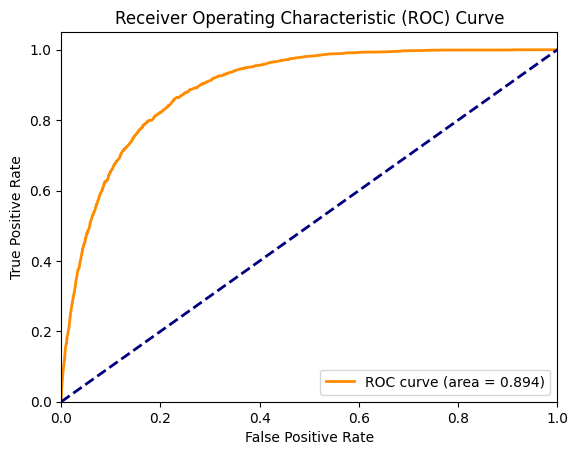

In [144]:
model = LGBMRanker(
    metric='auc'
)

# model = pipeline
model.fit(X_train_fe_used , y_train,
          group=train_groups,
        )

y_pred_proba = model.predict(X_val_fe_used, group=val_groups)
proba_to_predict = lambda proba, threshold=0.5: (proba > threshold).astype(int)
y_pred = proba_to_predict(y_pred_proba)

manual_auc_roc_draw(y_val, y_pred_proba)

In [145]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9485076327181591
Precision: 0.6351878265416846
Recall: 0.3457658925639221
Confusion Matrix:
 [[115090   3539]
 [  2789   1474]]


#### Random Forest

/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Bad pipe message: %s [b'\xb8\r2\x19D\x0fd",\x8fd+\xc7\xc8|\x00\x07\x9a \xeaZ% #d\x1fS\x1f\xf2\t\xf0\xb7o\xb7]\x02*Kf\xe3\x00!\xfb\xc9n"\xc0\x03\xaf\xef\xa0\x00 \xfa\xfa\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9f\xba\xba\x00\x00\x00\x12\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1Di\x00\x05\x00\x03\x02h2\xff\x01\x00\x01\x00\x00\n\x00\n\x00\x08\xca\xca\x00\x1d\x00\x17\x00\x18\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01', b'\x08\x05\x05\x01', b'\x06\x01\x00\x1b\x00\x03\x02']


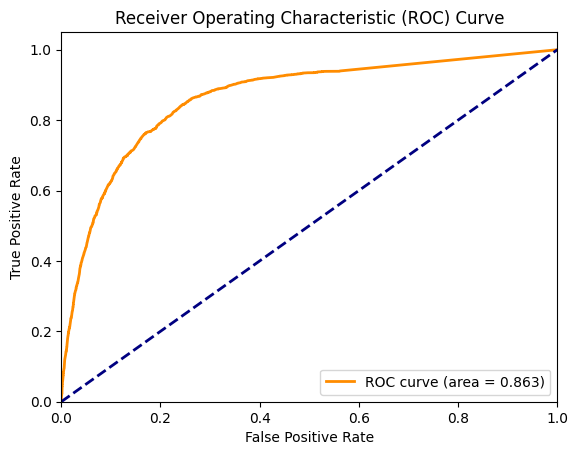

In [146]:
model = RandomForestClassifier()

# Fit the model on the training data
model.fit(X_train_fe_used, y_train)

# Predict on the testing data
y_pred = model.predict(X_val_fe_used)
y_pred_proba = model.predict_proba(X_val_fe_used)[:, 1]

manual_auc_roc_draw(y_val, y_pred_proba)

In [147]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9623165055495883
Precision: 0.6697338786364471
Recall: 0.12315270935960591
Confusion Matrix:
 [[117736    893]
 [  3738    525]]


##### CatBoost

Learning rate set to 0.144453
0:	learn: 0.4579386	total: 44.4ms	remaining: 44.3s
1:	learn: 0.3403107	total: 72.4ms	remaining: 36.1s
2:	learn: 0.2584658	total: 100ms	remaining: 33.3s
3:	learn: 0.2097512	total: 129ms	remaining: 32s
4:	learn: 0.1761900	total: 156ms	remaining: 31.1s
5:	learn: 0.1588082	total: 183ms	remaining: 30.4s
6:	learn: 0.1455913	total: 211ms	remaining: 29.9s
7:	learn: 0.1368747	total: 238ms	remaining: 29.5s
8:	learn: 0.1311575	total: 266ms	remaining: 29.3s
9:	learn: 0.1277126	total: 294ms	remaining: 29.1s
10:	learn: 0.1250071	total: 329ms	remaining: 29.5s
11:	learn: 0.1229940	total: 372ms	remaining: 30.6s
12:	learn: 0.1213447	total: 416ms	remaining: 31.6s
13:	learn: 0.1203711	total: 454ms	remaining: 32s
14:	learn: 0.1196583	total: 484ms	remaining: 31.8s
15:	learn: 0.1186971	total: 514ms	remaining: 31.6s
16:	learn: 0.1178626	total: 542ms	remaining: 31.3s
17:	learn: 0.1175040	total: 569ms	remaining: 31s
18:	learn: 0.1169896	total: 596ms	remaining: 30.8s
19:	learn: 0.11

Bad pipe message: %s [b'\x9f\xa9\xe1J\xbbV\xd7\x88Z\xac{.#\xc6\x14\xdf\x8d\xb0 \x1e\xc8\xd3\x8f\x0f\x1e\xa9W\t\x0b|\x1e\xb6\xe4\xd1\x01\xee)\xaa\xc48&\xb4\xd3.x`']


470:	learn: 0.1041931	total: 15s	remaining: 16.8s
471:	learn: 0.1041831	total: 15s	remaining: 16.8s
472:	learn: 0.1041792	total: 15s	remaining: 16.7s
473:	learn: 0.1041663	total: 15s	remaining: 16.7s
474:	learn: 0.1041563	total: 15.1s	remaining: 16.7s
475:	learn: 0.1041442	total: 15.1s	remaining: 16.6s
476:	learn: 0.1041364	total: 15.1s	remaining: 16.6s
477:	learn: 0.1041188	total: 15.2s	remaining: 16.6s
478:	learn: 0.1041105	total: 15.2s	remaining: 16.5s
479:	learn: 0.1041032	total: 15.2s	remaining: 16.5s
480:	learn: 0.1040873	total: 15.2s	remaining: 16.4s
481:	learn: 0.1040804	total: 15.3s	remaining: 16.4s
482:	learn: 0.1040643	total: 15.3s	remaining: 16.4s
483:	learn: 0.1040562	total: 15.3s	remaining: 16.3s
484:	learn: 0.1040503	total: 15.3s	remaining: 16.3s
485:	learn: 0.1040406	total: 15.4s	remaining: 16.3s
486:	learn: 0.1040325	total: 15.4s	remaining: 16.2s
487:	learn: 0.1040232	total: 15.4s	remaining: 16.2s
488:	learn: 0.1040169	total: 15.5s	remaining: 16.2s
489:	learn: 0.104009

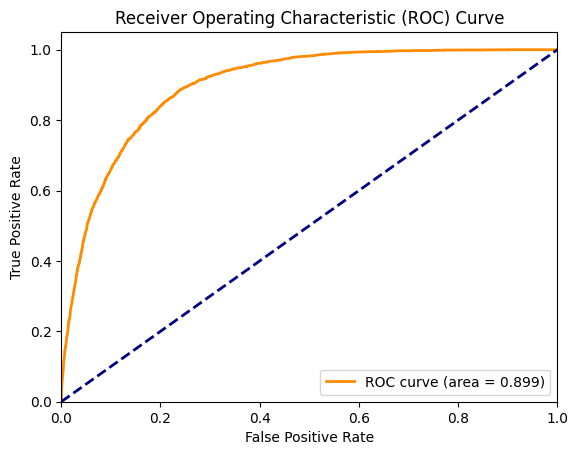

In [148]:
model = CatBoostClassifier()

# Fit the model on the training data
model.fit(X_train_fe_used, y_train)

# Predict on the testing data
y_pred = model.predict(X_val_fe_used)
y_pred_proba = model.predict_proba(X_val_fe_used)[:, 1]

manual_auc_roc_draw(y_val, y_pred_proba)

In [149]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9650424763206719
Precision: 0.72215380959612
Recall: 0.078348580811635
Confusion Matrix:
 [[118262    367]
 [  3929    334]]


#### CatBoostRanker

0:	total: 1.05s	remaining: 17m 31s
1:	total: 1.79s	remaining: 14m 54s
2:	total: 2.41s	remaining: 13m 20s
3:	total: 3.17s	remaining: 13m 8s
4:	total: 3.83s	remaining: 12m 42s
5:	total: 4.38s	remaining: 12m 6s
6:	total: 4.92s	remaining: 11m 38s
7:	total: 8.17s	remaining: 16m 53s
8:	total: 9.17s	remaining: 16m 49s
9:	total: 10.5s	remaining: 17m 16s
10:	total: 11.7s	remaining: 17m 30s


Bad pipe message: %s [b'\xb7\xd4\xf7\xdc%D9]\xc0\x984\x96,M\xac}%3 \x07\xc9\x12(yT\x92\x1c\x1e\xdc\xb8Hw\x8f|\x14\x16\xbe\x92\x18\xc4\xc5\x11\x11s\x0c\x8c\xc2h\xed\x17:\x00 zz\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01']
Bad pipe message: %s [b'j\xc1fT\x03\xed^$\xf1Fi\t\xb0\xbc\xd8\x9e\x1b\x86 \x14\xaf[j\x17Jx\xc1\x80\xd2\x97\xf4\x7f\x1d\x84[\x89I@\xc2K\xaf\xf2\r\xdf;\xfa\xa3sp"\xee\x00 \xba\xba\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93JJ\x00\x00\x00+\x00\x07\x06JJ\x03\x04\x03\x03\x00\x05\x00\x05\x01\x00\x00\x00\x00\xff\x01\x00\x01\x00\x00\x0b\x00\x02\x01\x00\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocal']
Bad pipe message: %s [b"\xfa\x00\x00\x003\x00+\x00)\xca\xca\x00\x01\x00\x00\x1d\x00 \x12\xba.\xc5\xca\xc7i\xfb\xdd\xbd_\x87dBW-\xa3f\xffWY\x1a\xf7L4\xa1\xdbjEc{]\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00#\x00\x00Di\x00\x05\x00\x03\x02h2\x00\x0b\x00

11:	total: 15.3s	remaining: 20m 58s
12:	total: 16.1s	remaining: 20m 25s
13:	total: 16.9s	remaining: 19m 47s
14:	total: 17.6s	remaining: 19m 15s
15:	total: 18.3s	remaining: 18m 46s
16:	total: 19.1s	remaining: 18m 24s
17:	total: 19.9s	remaining: 18m 6s
18:	total: 20.8s	remaining: 17m 55s
19:	total: 21.7s	remaining: 17m 42s
20:	total: 22.3s	remaining: 17m 20s
21:	total: 22.9s	remaining: 16m 59s
22:	total: 23.5s	remaining: 16m 39s
23:	total: 24.2s	remaining: 16m 24s
24:	total: 25.7s	remaining: 16m 43s
25:	total: 26.4s	remaining: 16m 29s
26:	total: 27.1s	remaining: 16m 16s
27:	total: 27.7s	remaining: 16m 1s
28:	total: 28.3s	remaining: 15m 47s
29:	total: 28.9s	remaining: 15m 34s
30:	total: 29.5s	remaining: 15m 22s
31:	total: 30.2s	remaining: 15m 13s
32:	total: 30.9s	remaining: 15m 5s
33:	total: 31.5s	remaining: 14m 55s
34:	total: 32.1s	remaining: 14m 45s
35:	total: 32.7s	remaining: 14m 36s
36:	total: 33.3s	remaining: 14m 27s
37:	total: 34s	remaining: 14m 20s
38:	total: 34.6s	remaining: 14m 1

Bad pipe message: %s [b'\x8b']
Bad pipe message: %s [b"\xaft\x0f\xf2\x17\xc2\xe4\xdb (\x9cK\xf6{k \xd0Q\xf8\x17l\xe1\xa1zU{\xdf\xaa\x88Y\xc0'5\x81 w\xf1\xfa\x9e\xb7\xb1tU1\xf86\xd39\x00 jj\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93zz\x00\x00\x00#\x00\x00\x003\x00+\x00)zz\x00\x01\x00\x00\x1d\x00 7\xf6.WE\xdd9\x14\xdb\x8f\xb1\xc0B\xaaT\xc1\xa1\xd4=Z\x1e\xdfD\x93\nb\xdf\x0b{\x8b\x8d\x1e\x00\x0b\x00\x02\x01\x00\x00\n\x00\n\x00\x08zz\x00\x1d\x00\x17\x00\x18\x00+\x00\x07\x06ZZ\x03\x04\x03\x03\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x1b\x00\x03\x02\x00\x02\x00-\x00\x02\x01\x01\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalh"]


56:	total: 45.4s	remaining: 12m 31s
57:	total: 46s	remaining: 12m 27s
58:	total: 46.6s	remaining: 12m 22s
59:	total: 47.1s	remaining: 12m 18s
60:	total: 47.7s	remaining: 12m 14s
61:	total: 48.3s	remaining: 12m 11s
62:	total: 49s	remaining: 12m 8s
63:	total: 49.5s	remaining: 12m 4s
64:	total: 50.1s	remaining: 12m 1s
65:	total: 50.7s	remaining: 11m 57s
66:	total: 51.5s	remaining: 11m 57s
67:	total: 52.3s	remaining: 11m 56s
68:	total: 52.9s	remaining: 11m 53s
69:	total: 53.5s	remaining: 11m 50s
70:	total: 54.2s	remaining: 11m 48s
71:	total: 54.8s	remaining: 11m 45s
72:	total: 55.4s	remaining: 11m 43s
73:	total: 55.9s	remaining: 11m 39s
74:	total: 56.6s	remaining: 11m 37s
75:	total: 57.1s	remaining: 11m 34s
76:	total: 57.8s	remaining: 11m 33s
77:	total: 58.5s	remaining: 11m 31s
78:	total: 59.1s	remaining: 11m 28s
79:	total: 59.7s	remaining: 11m 26s
80:	total: 1m	remaining: 11m 23s
81:	total: 1m 1s	remaining: 11m 27s
82:	total: 1m 1s	remaining: 11m 24s
83:	total: 1m 2s	remaining: 11m 21s
84

Bad pipe message: %s [b'\xad\xff\xa4S;\x08\x7f\x08\xb6\xd8\x0b\xe2\x17.\xd3\xc7\xeb\x0c \xa9E\xb5\xae\x1bT\x98>%\xa7\xe3\xea,z\xf2\x03U\xb3k\xecs\x0e\x05i\x91\x9b1\x17\xee/\xceh\x00 \xba\xba\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbfzz\x00\x00\x003\x00+\x00)ZZ\x00\x01\x00\x00\x1d\x00 @I;\x1a\x84-\xdb{\x14!\x08L\xba\xa4jg\xfdq\x8eC6\xcd\xdc\x80\xc2\x04\x04u\x88\xe26.\x00\n\x00\n\x00\x08ZZ\x00\x1d\x00\x17\x00\x18\x00\x0b\x00\x02\x01\x00\x00#\x00\x00\x00+\x00\x07\x06**\x03\x04\x03\x03\x00\x00\x00\x0e\x00\x0c\x00\x00\tl']
Bad pipe message: %s [b'alhost\xfe\r\x00\xfa\x00\x00\x01\x00\x01s\x00 \xb7\x91\xc3\xfd\n}\xcd)\x1d,w\xd0\x8d\xdf\xf5\x94I\xa6h\x02\xad\xd4\xd8\xad\x9e K%@\x01\xbb-\x00\xd0>[\x98\x0c\n\\\xca\n\xfa%#M!\xcePw.\xf3b\xaa\xd11?]\n\x1b\r\xad\xe2\xd7\xb2oo\xef\xcf<\xb7\xd0\x92`z]\x1a\xa1\xe4\xae\xe9\xa0H\x15*h\x81F\x9d\x9f;+', b'r\xb2Y\xf9\np\x06\xeb\x9f\xffda~\xd9L\x1c0\x9a\x84\xa9\xbb\xf3h\xadC\x13\xb7\x

103:	total: 1m 16s	remaining: 10m 55s
104:	total: 1m 16s	remaining: 10m 54s
105:	total: 1m 17s	remaining: 10m 52s
106:	total: 1m 17s	remaining: 10m 50s
107:	total: 1m 18s	remaining: 10m 50s
108:	total: 1m 19s	remaining: 10m 48s
109:	total: 1m 19s	remaining: 10m 46s
110:	total: 1m 20s	remaining: 10m 45s
111:	total: 1m 21s	remaining: 10m 44s
112:	total: 1m 21s	remaining: 10m 42s
113:	total: 1m 22s	remaining: 10m 41s
114:	total: 1m 23s	remaining: 10m 41s
115:	total: 1m 23s	remaining: 10m 39s
116:	total: 1m 24s	remaining: 10m 38s
117:	total: 1m 25s	remaining: 10m 38s
118:	total: 1m 26s	remaining: 10m 37s
119:	total: 1m 26s	remaining: 10m 37s
120:	total: 1m 27s	remaining: 10m 35s
121:	total: 1m 28s	remaining: 10m 33s
122:	total: 1m 28s	remaining: 10m 32s
123:	total: 1m 29s	remaining: 10m 30s
124:	total: 1m 29s	remaining: 10m 29s
125:	total: 1m 30s	remaining: 10m 27s
126:	total: 1m 31s	remaining: 10m 25s
127:	total: 1m 31s	remaining: 10m 24s
128:	total: 1m 32s	remaining: 10m 22s
129:	total: 

Bad pipe message: %s [b'\xae\x98\xfe\xe4 ]\xf2\xf3P\x8b\t$\xe2;\x81>\x8bc \xa5b\x92\xae\xbd\x96<\xeaFG8\x82\xd9\x8f\xa9)k\xde\xbb:K\xa6\xe1Jbs\x83S']
Bad pipe message: %s [b'\x85\xc5\x00 \xba\xba\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00']
Bad pipe message: %s [b'\x82!\xf41\x03\xba\xb8>\xa8\xa0\xa3\xe4\xfc)\x1b\x06x\x93 \xd0\x1c\x0c\x98 \xd49g\xcc\xb4\xb9\xbc\x87\x96E\xf3&a\xa9x\xbf\xdec\xcb\rE2a\x1b\xa9(%\x00 **\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbfJJ\x00\x00Di\x00\x05\x00\x03\x02h2\x00-\x00\x02\x01\x01\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00#\x00\x00\x00\x0b\x00\x02\x01\x00\x003\x00+\x00)\xba\xba\x00\x01\x00\x00\x1d\x00 \x12O\x1aI/}^J\xdb\xa9n\x92\xf7j\xcf\xcdI\xf9\x85\x8e\xfdc\xdd\xb4\xf0{w\xb4u,\xceg\x00\n\x00\n\x00\x08\xba\xba\x00\x1d\x00\x17\x00\x18\xfe\r\x00\xfa\x00\x00\x01\x00\x01\xd3\x00 \xb4Ku']
Bad pipe message: %s [b'5\x01\x00\x01\xdf:

151:	total: 1m 46s	remaining: 9m 53s
152:	total: 1m 46s	remaining: 9m 51s
153:	total: 1m 47s	remaining: 9m 52s
154:	total: 1m 48s	remaining: 9m 50s
155:	total: 1m 49s	remaining: 9m 50s
156:	total: 1m 49s	remaining: 9m 49s
157:	total: 1m 50s	remaining: 9m 48s
158:	total: 1m 51s	remaining: 9m 47s
159:	total: 1m 51s	remaining: 9m 46s
160:	total: 1m 52s	remaining: 9m 45s
161:	total: 1m 52s	remaining: 9m 44s
162:	total: 1m 53s	remaining: 9m 44s
163:	total: 1m 54s	remaining: 9m 42s
164:	total: 1m 55s	remaining: 9m 41s
165:	total: 1m 55s	remaining: 9m 41s
166:	total: 1m 56s	remaining: 9m 40s
167:	total: 1m 56s	remaining: 9m 39s
168:	total: 1m 57s	remaining: 9m 38s
169:	total: 1m 58s	remaining: 9m 37s
170:	total: 1m 58s	remaining: 9m 36s
171:	total: 1m 59s	remaining: 9m 35s
172:	total: 2m	remaining: 9m 34s
173:	total: 2m 1s	remaining: 9m 36s
174:	total: 2m 2s	remaining: 9m 35s
175:	total: 2m 2s	remaining: 9m 35s
176:	total: 2m 3s	remaining: 9m 34s
177:	total: 2m 4s	remaining: 9m 33s
178:	total

Bad pipe message: %s [b'O\xe8\xc4\xcd\x90\xbe\xaa\xceN\xe2\xd4\xfer7*\xe13\x94 \xec\xdd\x82\x8b\x90\x98\xb2\xd1+\x1a\xd7\xd2\xc3\x1c\xcc\xeb=\xceA\\\x18\xc6\x9b\xe8Dy\xaae\x83\x12\x86)\x00 ::\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbfJJ\x00\x00\x00\n\x00\n\x00\x08\xfa\xfa\x00\x1d\x00\x17\x00\x18\x00\x17\x00\x00\x00+\x00\x07\x06::\x03\x04\x03\x03\x00-\x00\x02\x01\x01\xff\x01\x00\x01\x00Di\x00\x05\x00\x03\x02h2\xfe\r\x00\xfa\x00\x00\x01\x00\x01\xa0\x00 ;\xc3E\xf5.5%\xc5\x9a\x8ch\x91]\x9f\x0f\x9f\x86J\xcaw(1\x9fv\xc9r', b'\xb5~\x8e\x13\x00\xd0\xf8<b,\x14\x0b\xc4\xb3\xe92\x11\x0c\x12e\xf7\xdd\x80tE"K\x1b\x90\x98\xa2\x10r\xea\xc4\x98\xdc\x0b\xfb\x97\x10}\x05\xac\xad\x84o\xc2\xa7\x96\x01\xfb\xc8\x19`+\xa1/\x1a7\xc19 \xbd\x07\xf3K\x0b\x9a\xa6\xdb\xfaX\x89\x8a\xb2\xbc{*\xad\xde#\x96C\xc4\xf9\xc8\x07XB\xb4pv\x87q\xea\xecp\x85n0']
Bad pipe message: %s [b'\xce\xf6\x88\xe8\x966\x8e\x16\x1c\x16\xe4\xbd\xf0\xabp\x82\x0b\xfb\x

194:	total: 2m 16s	remaining: 9m 23s
195:	total: 2m 17s	remaining: 9m 23s
196:	total: 2m 18s	remaining: 9m 23s
197:	total: 2m 19s	remaining: 9m 23s
198:	total: 2m 19s	remaining: 9m 22s
199:	total: 2m 20s	remaining: 9m 21s
200:	total: 2m 21s	remaining: 9m 20s
201:	total: 2m 21s	remaining: 9m 19s
202:	total: 2m 22s	remaining: 9m 18s
203:	total: 2m 23s	remaining: 9m 18s
204:	total: 2m 23s	remaining: 9m 17s
205:	total: 2m 24s	remaining: 9m 16s
206:	total: 2m 25s	remaining: 9m 15s
207:	total: 2m 25s	remaining: 9m 15s
208:	total: 2m 26s	remaining: 9m 14s
209:	total: 2m 27s	remaining: 9m 13s
210:	total: 2m 27s	remaining: 9m 12s
211:	total: 2m 28s	remaining: 9m 11s
212:	total: 2m 29s	remaining: 9m 10s
213:	total: 2m 29s	remaining: 9m 10s
214:	total: 2m 30s	remaining: 9m 9s
215:	total: 2m 31s	remaining: 9m 8s
216:	total: 2m 31s	remaining: 9m 7s
217:	total: 2m 32s	remaining: 9m 6s
218:	total: 2m 33s	remaining: 9m 6s
219:	total: 2m 33s	remaining: 9m 5s
220:	total: 2m 34s	remaining: 9m 4s
221:	tot

Bad pipe message: %s [b"\xf8\x8d\xa3Y\xfaYO\xd9m\x95\xeb\x99Z\xd0\x93\xfe\xddy \x9e3\xdea\x85\xdc4\x8f`\xbbtv\xf9G7\x87\xc7Y\xe8~\xa6\xd7T\n\xcf'\x81\x18\xe0\xc7\xc2T\x00 **\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdf\x9a\x9a\x00\x00Di\x00\x05\x00\x03\x02h2\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\x17\x00\x00\x00#\x00\x00\x00\n\x00\n\x00\x08JJ\x00\x1d\x00\x17\x00\x18\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00\x12\x00\x00\xfe\r\x01\x1a\x00\x00\x01\x00\x01\x15\x00 \x8f\xdap\xb5\x9c\xa0\xab\x11\xe8\x14\xc6\xdd\xe5\xbb_\x9d\x13 \xfaBN+\xd5\xa7\x9b\xdeE\x80P\xca\x91\x07\x00\xf0\x8b/9#\x86o\xf6<\xf2~\xc3\xc4\xf6\xa2L\x1f_\xc0\x16H\xe1\xd37\xd2~\x7f|\x17", b'"\xe5I\xf6\xd7D\xb1\xc0\x13\xb70\x06\xdc\xaez\x94\nFT]\xb3\x81\x98\x15\x9b\xf6\x89\xadR\x9f\x98g\xb1\xeam\x18Z\x82\x11\xd5\x0c\xba\xc8<a\xbe\xd6\xd3\xd8|n\x9bq\xb06gy\xa86\xa8z!\xf7\x80\x96\xc2\x1c\xc4\x1dC\xa9\nMO\xc2\xb5\x9e\x0e\xf7\xce\x8e\xbb(\xe7\x00\xe32_\x

237:	total: 2m 47s	remaining: 8m 55s
238:	total: 2m 47s	remaining: 8m 54s
239:	total: 2m 48s	remaining: 8m 53s
240:	total: 2m 49s	remaining: 8m 53s
241:	total: 2m 50s	remaining: 8m 52s
242:	total: 2m 50s	remaining: 8m 52s
243:	total: 2m 51s	remaining: 8m 51s
244:	total: 2m 52s	remaining: 8m 50s
245:	total: 2m 53s	remaining: 8m 50s
246:	total: 2m 53s	remaining: 8m 49s
247:	total: 2m 54s	remaining: 8m 49s
248:	total: 2m 55s	remaining: 8m 48s
249:	total: 2m 56s	remaining: 8m 48s
250:	total: 2m 56s	remaining: 8m 47s
251:	total: 2m 57s	remaining: 8m 46s
252:	total: 2m 58s	remaining: 8m 46s
253:	total: 2m 59s	remaining: 8m 45s
254:	total: 2m 59s	remaining: 8m 45s
255:	total: 3m	remaining: 8m 44s
256:	total: 3m 1s	remaining: 8m 45s
257:	total: 3m 2s	remaining: 8m 45s
258:	total: 3m 3s	remaining: 8m 45s
259:	total: 3m 4s	remaining: 8m 44s
260:	total: 3m 5s	remaining: 8m 45s
261:	total: 3m 6s	remaining: 8m 44s
262:	total: 3m 7s	remaining: 8m 45s
263:	total: 3m 8s	remaining: 8m 44s
264:	total: 3

Bad pipe message: %s [b'\x90(6\xb0\xfc\xfd\x93\x10:\xe6\xf4K{x\xde\x86\\\xcf \xfc\xa0tH\xf4h\xbd\xf0\xd3\xb2\x15\xd9T\xff\xe8\xb8\xcc']
Bad pipe message: %s [b'Un\x860\xf8\x05\xe5\x1c\xce\x19\x06\x88\x96\x00 \x9a\x9a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbfZZ\x00\x00\x00+\x00\x07\x06\xca\xca\x03\x04\x03\x03\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00\x12\x00\x00\x00-\x00\x02\x01\x01\x00\x1b\x00\x03\x02\x00\x02\x003\x00+\x00)\x9a\x9a\x00\x01\x00\x00\x1d\x00 \x08\x9c\xf7z\x11pT\x9d\x87\x88\xfb\x13+\xdb\xd9T\xd4l\x8d\x03(M\x111\xc1\x13\xb8\xd3\xb7\xa6\xa1z\xff\x01\x00\x01\x00\x00\x05\x00\x05\x01\x00\x00\x00\x00Di\x00\x05\x00\x03\x02h2\x00\n\x00\n\x00\x08\x9a\x9a\x00\x1d\x00\x17\x00\x18\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\xfe\r\x00\xfa\x00\x00\x01\x00\x01C\x00 o\x86q\x01x\xb7R\xda\xb2\xda\xb7\x8c;WN']
Bad pipe message: %

274:	total: 3m 17s	remaining: 8m 41s
275:	total: 3m 18s	remaining: 8m 40s
276:	total: 3m 19s	remaining: 8m 40s
277:	total: 3m 20s	remaining: 8m 40s
278:	total: 3m 21s	remaining: 8m 39s
279:	total: 3m 21s	remaining: 8m 39s
280:	total: 3m 22s	remaining: 8m 38s
281:	total: 3m 23s	remaining: 8m 37s
282:	total: 3m 24s	remaining: 8m 37s
283:	total: 3m 24s	remaining: 8m 36s
284:	total: 3m 25s	remaining: 8m 36s
285:	total: 3m 26s	remaining: 8m 35s
286:	total: 3m 27s	remaining: 8m 34s
287:	total: 3m 28s	remaining: 8m 34s
288:	total: 3m 29s	remaining: 8m 34s
289:	total: 3m 30s	remaining: 8m 34s
290:	total: 3m 30s	remaining: 8m 33s
291:	total: 3m 31s	remaining: 8m 33s
292:	total: 3m 32s	remaining: 8m 32s
293:	total: 3m 33s	remaining: 8m 31s
294:	total: 3m 33s	remaining: 8m 31s
295:	total: 3m 34s	remaining: 8m 30s
296:	total: 3m 35s	remaining: 8m 29s
297:	total: 3m 36s	remaining: 8m 29s
298:	total: 3m 36s	remaining: 8m 28s
299:	total: 3m 37s	remaining: 8m 27s
300:	total: 3m 38s	remaining: 8m 27s
3

Bad pipe message: %s [b'\xa09\x90*`\xda\xd6\x81gU\xd2R\x9b\xf9IZ\x03\xb5 Q\x8b\xe1j4N\x87y\t\xd7\x047S\xcc\xa8\x1d\xcf\xd2\xfcK\x8eAu\xe0a\x9d\xb7[\xc0\xf6\xcd\xa5\x00 \xda\xda\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdf\n\n\x00\x00\x00\x17\x00\x00\x003\x00+\x00)ZZ\x00\x01\x00\x00\x1d\x00 H\x7f\x87\x067I<X\xe5\xad\x0b\x1bd\xf8\x9b\t\x154~\x8e!J\xf5\x89\xeb\xc0 \x93\xa7T\xdb\x1f\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00\x1b\x00\x03\x02\x00\x02\xff\x01\x00\x01\x00\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\x0b\x00\x02\x01\x00\x00-\x00\x02\x01\x01\x00\x12\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\xfe\r\x01\x1a\x00\x00\x01\x00\x01', b' \xe7,\xbdh&\x13`\x83\xc5\x1f\x90\x1f\x9a\x02\xd3\xceux\xc7\xd9\xb6\xcd\xfaeZ\x14\xe3U\x9e\x94\x1e9\x00\xf0\x03\xa7\x978\x8e\xd0\xd3\\\xe9N[\xf8vw\xb1\x98\x89\xd7\xfc\xf2\xfb\xfc|\xf5\x08f\xc8\x7fW\xc7\x17~\xa1\xcd\xa7\x10\xf2f\xdd\\

313:	total: 3m 48s	remaining: 8m 19s
314:	total: 3m 50s	remaining: 8m 20s
315:	total: 3m 51s	remaining: 8m 20s
316:	total: 3m 52s	remaining: 8m 20s
317:	total: 3m 53s	remaining: 8m 19s
318:	total: 3m 53s	remaining: 8m 19s
319:	total: 3m 55s	remaining: 8m 19s
320:	total: 3m 56s	remaining: 8m 19s
321:	total: 3m 57s	remaining: 8m 19s
322:	total: 3m 58s	remaining: 8m 18s
323:	total: 3m 58s	remaining: 8m 18s
324:	total: 3m 59s	remaining: 8m 17s
325:	total: 4m 1s	remaining: 8m 19s
326:	total: 4m 2s	remaining: 8m 18s
327:	total: 4m 3s	remaining: 8m 18s
328:	total: 4m 4s	remaining: 8m 18s
329:	total: 4m 5s	remaining: 8m 17s
330:	total: 4m 5s	remaining: 8m 17s
331:	total: 4m 7s	remaining: 8m 17s
332:	total: 4m 7s	remaining: 8m 16s
333:	total: 4m 8s	remaining: 8m 15s
334:	total: 4m 9s	remaining: 8m 15s
335:	total: 4m 10s	remaining: 8m 14s
336:	total: 4m 11s	remaining: 8m 13s
337:	total: 4m 11s	remaining: 8m 13s
338:	total: 4m 12s	remaining: 8m 12s
339:	total: 4m 13s	remaining: 8m 12s
340:	total:

Bad pipe message: %s [b'\x9f\xaf\xfa\xf3\xb9$\xb1R\xd6\x0cy\x1fs\x03\xe3(\x07\xcb q\x99niy\x94\x9e+\xeb\xc3\xf7*Q%k\xefBq\xe8\xe3\xdb\x1fr,\x96!Tz\xfd\x96\xc6(\x00 ZZ\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93\xca\xca\x00\x00\x00-\x00\x02\x01\x01\x00\x1b\x00\x03\x02\x00\x02\x00\x12\x00\x00Di\x00\x05\x00\x03\x02h2\x00\n\x00\n\x00\x08zz\x00\x1d\x00\x17\x00\x18\xfe\r\x00\xba\x00\x00\x01\x00\x01\xfe\x00 \xc7\x07\xee\x07\xfe\xe1i\x0buY\x97J\x0fX\x167\xe3\x18p#!%\xe3\xaa\xe1i\xac\x94\xb5\x10\xa9\x1a\x00\x90(-\xc4\xc7\xccd\x13)\x9bJ\xf0"']
Bad pipe message: %s [b'\xa8\xfcD\x8eaf\xc7\xdd\xbf\xd3\x8c\xfe=\xc7\x15\x986$ %\xedPn\xa8hp\xa5\xa7H\x1e\xfb2\x94\x1c\xca\xf8\xe4c\x18\xe4\x9e\xe3\rQ\x8f\xce\x9f\xe4', b'G\x00 JJ\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdfzz\x00\x00\xfe\r\x01\x1a\x00\x00\x01\x00\x01\xe6\x00']
Bad pipe message: %s [b'\x1ft\x95\

345:	total: 4m 18s	remaining: 8m 8s
346:	total: 4m 19s	remaining: 8m 8s
347:	total: 4m 20s	remaining: 8m 7s
348:	total: 4m 21s	remaining: 8m 6s
349:	total: 4m 21s	remaining: 8m 6s
350:	total: 4m 22s	remaining: 8m 5s
351:	total: 4m 23s	remaining: 8m 5s
352:	total: 4m 24s	remaining: 8m 4s
353:	total: 4m 25s	remaining: 8m 3s
354:	total: 4m 25s	remaining: 8m 3s
355:	total: 4m 26s	remaining: 8m 2s
356:	total: 4m 27s	remaining: 8m 2s
357:	total: 4m 28s	remaining: 8m 1s
358:	total: 4m 29s	remaining: 8m
359:	total: 4m 30s	remaining: 8m
360:	total: 4m 30s	remaining: 7m 59s
361:	total: 4m 31s	remaining: 7m 58s
362:	total: 4m 32s	remaining: 7m 58s
363:	total: 4m 33s	remaining: 7m 57s
364:	total: 4m 34s	remaining: 7m 56s
365:	total: 4m 34s	remaining: 7m 56s
366:	total: 4m 35s	remaining: 7m 55s
367:	total: 4m 36s	remaining: 7m 54s
368:	total: 4m 37s	remaining: 7m 54s
369:	total: 4m 38s	remaining: 7m 53s
370:	total: 4m 38s	remaining: 7m 52s
371:	total: 4m 39s	remaining: 7m 52s
372:	total: 4m 40s	rem

Bad pipe message: %s [b'\xec\x8ab\xa7\xe4\xfa\xe3t\xc6\r\xf9\xbf\x7f`\xf5\xa0w\xf9 [N!\x0f\x91\x1fn(\x947\xda\x0cR\x11\x83w\r\xb2\x07\x0eP\x0e\x04j\xa1fC}\x16R\x0b\xd8\x00 \xfa\xfa\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbf\x9a\x9a\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00#\x00\x00Di\x00\x05\x00\x03\x02h2\x00\x05\x00\x05\x01\x00\x00\x00']
Bad pipe message: %s [b'AR\xe3;Ih\x8dv\xf1Xk"\x9e\xa6\xa3;\xb2B AF\xe0\x91%\xa0_ \xf89\xa1Jb\x8b\xe9\xf7\xbf\xa4\xa7+\x80[\x9e\xab\xb9%\xff]\xady\x8eh\x00 \xda\xda\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93\x1a\x1a\x00\x00\x003\x00+\x00)*', b'\x01\x00\x00\x1d\x00 s\x95\xbd\x17\xe3\xb8\x07?\x96Q\x94\x9c\x08g\xeb\xff\xda\xdb\x16p\xa5\x14D\xd8\x08\xeej\x8d\xb1B6S\xff\x01\x00']
Bad pipe message: %s [b'']


383:	total: 4m 49s	remaining: 7m 44s
384:	total: 4m 50s	remaining: 7m 43s
385:	total: 4m 51s	remaining: 7m 43s
386:	total: 4m 52s	remaining: 7m 42s
387:	total: 4m 52s	remaining: 7m 41s
388:	total: 4m 53s	remaining: 7m 41s
389:	total: 4m 54s	remaining: 7m 40s
390:	total: 4m 55s	remaining: 7m 39s
391:	total: 4m 56s	remaining: 7m 39s
392:	total: 4m 56s	remaining: 7m 38s
393:	total: 4m 57s	remaining: 7m 37s
394:	total: 4m 58s	remaining: 7m 37s
395:	total: 4m 59s	remaining: 7m 36s
396:	total: 5m	remaining: 7m 35s
397:	total: 5m 1s	remaining: 7m 35s
398:	total: 5m 2s	remaining: 7m 34s
399:	total: 5m 3s	remaining: 7m 34s
400:	total: 5m 4s	remaining: 7m 34s
401:	total: 5m 5s	remaining: 7m 33s
402:	total: 5m 5s	remaining: 7m 33s
403:	total: 5m 7s	remaining: 7m 32s
404:	total: 5m 7s	remaining: 7m 32s
405:	total: 5m 8s	remaining: 7m 31s
406:	total: 5m 9s	remaining: 7m 30s
407:	total: 5m 10s	remaining: 7m 30s
408:	total: 5m 11s	remaining: 7m 29s
409:	total: 5m 12s	remaining: 7m 29s
410:	total: 5m 

Bad pipe message: %s [b'\xc4\x0e\xb0\t\x96\x85\x9b\xc8\x08of\xcfq\xf9\x05\xff\xa1S \xa5\xdaG\xad\xd2\xcf4\\\xeb\xd7t\x10/"\xa2\xfc\xb7\xb2\x9cjH\xaal2\xa1\xc7y\x9e[\xbd\x10\xf6\x00 zz\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbf\x9a\x9a\x00\x00\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00#\x00\x00\x00\x17\x00\x00\xfe\r\x00\xfa\x00\x00\x01\x00\x01E\x00 \xe4H)\xbf\x8d\xea\xd6\xcd1S\xf1\xfe\xdf)\x0fx\xc2,\xb3\xf1\xba\xc5Z\x9c[\xde\xc2\x1cfd8\x1f\x00\xd0PP7\x89v1*\xbd\xbc\x19S\x16\xa3\xf4HQ\x98\xcci2\x10G\x02\xc1_p\xd6p\xb1\xec\xedh\x04\x1dp\x81[\xf8\x7f\xd1\x9e\xf2\x197p\xff\x82\x04\x1as\x8b\x14B\xfb\r\xac\x82\x92km\x89\xc2\x99\xe8\xe9', b'/\x0b\xf0\xcf\xaa\x96\x10\xe3\x15\x03Tj\xe1&\x819p\x0b\x85L\xa6\xb7\xb4\xa32!\xc9\xeb\xb6m\x8d\x7f\xb4>i}O\xbdUS\xef1o\x87\xc0\xc3\xd0\xcas\xaf\x85=9\xcad\x18SFC\xba\xd8\x1d\xfc\x94\x93\xfb\x03\x10\xc9[X\xbc\x11]\xb9?\x99"\x83\xc2\xf1dT\x0e\x95m\xe0 \xe6\xdfU\xcd\x8e\xf7\xac\xa1\xd7\xe6

418:	total: 5m 19s	remaining: 7m 23s
419:	total: 5m 20s	remaining: 7m 22s
420:	total: 5m 21s	remaining: 7m 22s
421:	total: 5m 22s	remaining: 7m 21s
422:	total: 5m 23s	remaining: 7m 20s
423:	total: 5m 23s	remaining: 7m 20s
424:	total: 5m 24s	remaining: 7m 19s
425:	total: 5m 25s	remaining: 7m 18s
426:	total: 5m 26s	remaining: 7m 18s
427:	total: 5m 27s	remaining: 7m 17s
428:	total: 5m 28s	remaining: 7m 16s
429:	total: 5m 29s	remaining: 7m 16s
430:	total: 5m 29s	remaining: 7m 15s
431:	total: 5m 30s	remaining: 7m 14s
432:	total: 5m 31s	remaining: 7m 14s
433:	total: 5m 32s	remaining: 7m 13s
434:	total: 5m 33s	remaining: 7m 12s
435:	total: 5m 34s	remaining: 7m 12s
436:	total: 5m 34s	remaining: 7m 11s
437:	total: 5m 35s	remaining: 7m 10s
438:	total: 5m 36s	remaining: 7m 10s
439:	total: 5m 37s	remaining: 7m 9s
440:	total: 5m 38s	remaining: 7m 8s
441:	total: 5m 39s	remaining: 7m 8s
442:	total: 5m 39s	remaining: 7m 7s
443:	total: 5m 40s	remaining: 7m 6s
444:	total: 5m 41s	remaining: 7m 6s
445:	to

Bad pipe message: %s [b'\xe6\xd3:5\xc6\xdaZ\xd5\x9e\x17\x98E\xf5\xda']
Bad pipe message: %s [b'<\xfaP\xb6\xa0e\x1f\xb0\xd9\x0b*b\xec\xea~\x91\xa2\x14 g\xf7\xd7h\x8dB!\x8f;\x1d;\xc7\xbea\x17z\xb8J\xde\xfd\x8dG\x98\x884>\xb6\x92\xd3\t\x98p\x00 \x1a\x1a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9f\xaa\xaa\x00\x00\x00\n\x00\n\x00\x08\xaa\xaa\x00\x1d\x00\x17\x00\x18\x00\x17\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\xff\x01\x00\x01\x00\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00-\x00\x02\x01\x01Di\x00\x05\x00\x03\x02h2\x00\x1b\x00\x03\x02\x00\x02\xfe\r\x00\xda\x00\x00\x01\x00\x01D\x00 U\xcc\xdc\x0e\x8bs#5\xd7\x9aq\x01\xe5\xa9\xf0\xf8\x1fS\xc4\xc7$z\xb5\x14\x8e\xef>\xefz\x1d\x18l\x00\xb0,`\x85G\xf0\x95#q', b'\xf5\xec\xef\x9d\x92|&\xfd\x02:\xdf\xec~\x8b\x9eiIK\x92Z\x02WE\x1f\x83\xbaV\xb4\xe4f\x0c\xbd\r\xb2\xc6h\xa7Y\x93\x04\xd7\xb0\x16\xd4\xb7\xedx\x02\x07\xb1[\x99\xbf\x8f>\xc2O\xb530\xc1\x81tv\xa3D\xbf\xfb*\x16\x19\x

449:	total: 5m 50s	remaining: 7m 8s
450:	total: 5m 54s	remaining: 7m 11s
451:	total: 5m 56s	remaining: 7m 12s
452:	total: 5m 57s	remaining: 7m 12s
453:	total: 5m 58s	remaining: 7m 11s
454:	total: 6m	remaining: 7m 11s
455:	total: 6m 1s	remaining: 7m 11s
456:	total: 6m 3s	remaining: 7m 12s
457:	total: 6m 5s	remaining: 7m 12s
458:	total: 6m 6s	remaining: 7m 11s
459:	total: 6m 7s	remaining: 7m 10s
460:	total: 6m 7s	remaining: 7m 10s
461:	total: 6m 8s	remaining: 7m 9s
462:	total: 6m 9s	remaining: 7m 8s
463:	total: 6m 10s	remaining: 7m 8s
464:	total: 6m 11s	remaining: 7m 7s
465:	total: 6m 12s	remaining: 7m 6s
466:	total: 6m 13s	remaining: 7m 6s
467:	total: 6m 14s	remaining: 7m 5s
468:	total: 6m 15s	remaining: 7m 4s
469:	total: 6m 15s	remaining: 7m 3s
470:	total: 6m 16s	remaining: 7m 3s
471:	total: 6m 17s	remaining: 7m 2s
472:	total: 6m 18s	remaining: 7m 1s
473:	total: 6m 19s	remaining: 7m 1s
474:	total: 6m 20s	remaining: 7m


Bad pipe message: %s [b'\xd8\xc0\x89]\xd9$\x93\xf7b%\x97\x0e\xbf\xd4\xc1Xgf \xfd\x87\x8eZ\x02r\xaf\xca\xf7@5\xa5oZ\xf1)\xe9\xa7M<O\xf0m\xf9\x9c"}ETD:\xe7\x00 \xda\xda\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbf\x8a\x8a\x00\x00\x00\n\x00\n\x00\x08\xba\xba\x00\x1d\x00\x17\x00\x18Di\x00\x05\x00\x03\x02h2\x00\x0b\x00\x02\x01\x00\x00+\x00\x07\x06ZZ\x03\x04\x03\x03\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00\x1b\x00\x03\x02\x00\x02\x00\x17\x00\x00\x00\r\x00']
Bad pipe message: %s [b'\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01']


475:	total: 6m 21s	remaining: 6m 59s
476:	total: 6m 22s	remaining: 6m 58s
477:	total: 6m 23s	remaining: 6m 58s
478:	total: 6m 23s	remaining: 6m 57s
479:	total: 6m 24s	remaining: 6m 56s
480:	total: 6m 25s	remaining: 6m 56s
481:	total: 6m 26s	remaining: 6m 55s
482:	total: 6m 27s	remaining: 6m 55s
483:	total: 6m 28s	remaining: 6m 54s
484:	total: 6m 29s	remaining: 6m 53s
485:	total: 6m 30s	remaining: 6m 53s
486:	total: 6m 31s	remaining: 6m 52s
487:	total: 6m 32s	remaining: 6m 51s
488:	total: 6m 33s	remaining: 6m 51s
489:	total: 6m 34s	remaining: 6m 50s
490:	total: 6m 35s	remaining: 6m 49s
491:	total: 6m 36s	remaining: 6m 49s
492:	total: 6m 36s	remaining: 6m 48s
493:	total: 6m 37s	remaining: 6m 47s
494:	total: 6m 38s	remaining: 6m 46s
495:	total: 6m 39s	remaining: 6m 45s
496:	total: 6m 40s	remaining: 6m 45s
497:	total: 6m 41s	remaining: 6m 44s
498:	total: 6m 42s	remaining: 6m 44s
499:	total: 6m 43s	remaining: 6m 43s
500:	total: 6m 44s	remaining: 6m 42s
501:	total: 6m 45s	remaining: 6m 42s
5

Bad pipe message: %s [b'\xb3\xd2\x91\x87\xe9/i\xda\x85Ua\x8c\xa6\xbb\x0e_JB \xbf\x87\x84#\xb6Q\xb4oU\xfe\xa6\x99!\xeb{\x88H\x8d\xac\x086!\xef\x89\xa1a\xb2w\xbe\xc0\x8d\xa5\x00 \xca\xca\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbf\xea\xea\x00\x00\x00#\x00\x00\x00\x12\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\xfe\r\x00\xfa\x00\x00\x01\x00\x01\x11\x00 ~\x8f\x94\xeak\xabK', b'\xa3f\x82\xc4\xa3\xdb9A*\x92\xa2\xe7\xcc*\xe9\xbeF\x1e\x8a\x87\xe0h^\x00\xd0\x99\xcb']
Bad pipe message: %s [b'4\x07s}z1\xe5\xbe\x81\xf0\x88\xa6\xfe\xf9\xf1\x88g\xff\xbe\x13\x04\x85\x0fL\xc4\xa8h\xfa\xfa\x91\x83\x8dw\x12\xbe\x10\xca\x90\xb6\x9f{\x1bs\xc3\nU\x1aD/\xd6\x13\x80\x97a']
Bad pipe message: %s [b'fo\x89\x08\x1c\xf2wl6\xa8\xb9\xb9\xb7\x93( \x93~ @\x82\x17`\xb8\xfe\xae\x81\x1d\xa3\x0f{\xf0\x8a:\xd0\xebj\x89\x9b\x98b\x04\xee\x93L\x8bD${\x8d\x1e\x00 jj\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,

508:	total: 6m 51s	remaining: 6m 37s
509:	total: 6m 52s	remaining: 6m 36s
510:	total: 6m 53s	remaining: 6m 35s
511:	total: 6m 54s	remaining: 6m 35s
512:	total: 6m 55s	remaining: 6m 34s
513:	total: 6m 56s	remaining: 6m 33s
514:	total: 6m 57s	remaining: 6m 32s
515:	total: 6m 58s	remaining: 6m 32s
516:	total: 6m 59s	remaining: 6m 31s
517:	total: 7m	remaining: 6m 30s
518:	total: 7m 1s	remaining: 6m 30s
519:	total: 7m 3s	remaining: 6m 30s
520:	total: 7m 4s	remaining: 6m 30s
521:	total: 7m 5s	remaining: 6m 29s
522:	total: 7m 6s	remaining: 6m 28s
523:	total: 7m 6s	remaining: 6m 27s
524:	total: 7m 7s	remaining: 6m 27s
525:	total: 7m 8s	remaining: 6m 26s
526:	total: 7m 9s	remaining: 6m 25s
527:	total: 7m 10s	remaining: 6m 25s
528:	total: 7m 11s	remaining: 6m 24s
529:	total: 7m 12s	remaining: 6m 23s
530:	total: 7m 13s	remaining: 6m 22s
531:	total: 7m 14s	remaining: 6m 22s
532:	total: 7m 15s	remaining: 6m 21s
533:	total: 7m 16s	remaining: 6m 20s
534:	total: 7m 17s	remaining: 6m 19s
535:	total: 7m

Bad pipe message: %s [b'\xd7\xe8\xa6\xb9\xcb\x92\\\x80\x1fE\xe6\x17\x97\xe2\xf0<\xd9g \x00\xc5\xe6\x9f\xb2ig\xd7!\xaf\x1cv\x92\xb8\xbd\\T5\xfe\xf7\xd96\x9bcq\t\xcaX\xc7\xc6\x03q\x00 \xea']
Bad pipe message: %s [b'\xb1\xae\xd4pT\xb0\x05\x9b\r\xe5(\x19\x9d\xd8N\x15\xc14 \x03hV\xcbh\x12\xcba\x89\xb8\xbb\xb6\x1f\x94\xda\x12SX\xa3,\xe7', b'\xafN#\xdcM\xa8p\xe9+\x00 ZZ\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00']
Bad pipe message: %s [b'\x9d\x00/\x005\x01\x00\x01\xdf**\x00\x00\x00\n\x00\n\x00\x08\xca\xca\x00\x1d\x00\x17\x00\x18\xfe\r\x01\x1a\x00\x00\x01\x00\x01T\x00 \xa7\x86b\xaf\x97e\x93T\xbc\xfd\x88wx\xc1Z\xd0\x8e\x99L\x17i\x06\x8ck\xac0t\xbb\x05-\x1cf\x00\xf0\xe7\xdeo\xd4\xb6\xae1~\xc0h\x9eP\x02\xfeG\xae\x1bC:i\x93\xa9\x19\xfc>\x05\xd3\xdd\xffj(-\x9am\xce\xe3\x85\xd2d\xba\x00\xd4&.S\xd7\x10\xf9&\x05\xfe\x8a\xf7\xbe\x80x\xda\x19\x8f\xc4k-N\xcd\r\x9a\x08( W\xdf\xa8(7\xcd\xeb\xb8\xff\xc0\xd4\x0f\x99']
Bad pipe message: %s [b"<\xebP\xe0\xb3\x14)\xa9\xde\x0

539:	total: 7m 21s	remaining: 6m 16s
540:	total: 7m 22s	remaining: 6m 15s
541:	total: 7m 23s	remaining: 6m 14s
542:	total: 7m 24s	remaining: 6m 13s
543:	total: 7m 24s	remaining: 6m 12s
544:	total: 7m 25s	remaining: 6m 12s
545:	total: 7m 26s	remaining: 6m 11s
546:	total: 7m 27s	remaining: 6m 10s
547:	total: 7m 28s	remaining: 6m 10s
548:	total: 7m 29s	remaining: 6m 9s
549:	total: 7m 30s	remaining: 6m 8s
550:	total: 7m 31s	remaining: 6m 8s
551:	total: 7m 32s	remaining: 6m 7s
552:	total: 7m 33s	remaining: 6m 6s
553:	total: 7m 34s	remaining: 6m 5s
554:	total: 7m 35s	remaining: 6m 5s
555:	total: 7m 36s	remaining: 6m 4s
556:	total: 7m 37s	remaining: 6m 3s
557:	total: 7m 38s	remaining: 6m 3s
558:	total: 7m 39s	remaining: 6m 2s
559:	total: 7m 40s	remaining: 6m 1s
560:	total: 7m 41s	remaining: 6m
561:	total: 7m 41s	remaining: 6m
562:	total: 7m 42s	remaining: 5m 59s
563:	total: 7m 43s	remaining: 5m 58s
564:	total: 7m 44s	remaining: 5m 57s
565:	total: 7m 45s	remaining: 5m 57s
566:	total: 7m 46s	re

Bad pipe message: %s [b'\x93\x18\x88T\x17\x0bC\x88\xcf7\xf2,\x17,\x0b\xe9\xa3\x0e \xe4\x18#c\xf8\xc3s\x19\xc4\x87\xbb\tyz\x93\x8f\x7f\xcf\xc2\xcc\x9eU\xe8>\xceF\xeb\x15\xe6\xbeb\xb5\x00 JJ\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9fzz\x00\x00\x00\n\x00\n\x00\x08\x1a\x1a\x00\x1d\x00\x17\x00\x18\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05', b'\x05\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\xda\x94\xf0\x82\x12\x1e\xb5\xa9!$\xa4\x9d\x0e<9\xe4\x8c\xa5 t\xb3\x8d/\xd4\x1fj\x85.\xf5\x18:\x0e\xfe\xa2\xa7Ug\xb7ui\xda:\x95\xaf\x15\xef6\x03Hl\xa4\x00 \xaa\xaa\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdfzz\x00\x00\x00\x12\x00\x00\x00\r\x00\x12\x00\x10\x04\x03', b'\x04\x01\x05\x03\x08\x05\x05']
Bad pipe message: %s [b'\x01\x00\x00\x00\x0e']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x01\xff\x01\x00\x01']


572:	total: 7m 53s	remaining: 5m 52s
573:	total: 7m 54s	remaining: 5m 51s
574:	total: 7m 55s	remaining: 5m 51s
575:	total: 7m 55s	remaining: 5m 50s
576:	total: 7m 56s	remaining: 5m 49s
577:	total: 7m 57s	remaining: 5m 48s
578:	total: 7m 58s	remaining: 5m 47s
579:	total: 7m 59s	remaining: 5m 47s
580:	total: 8m	remaining: 5m 46s
581:	total: 8m 1s	remaining: 5m 45s
582:	total: 8m 2s	remaining: 5m 45s
583:	total: 8m 3s	remaining: 5m 44s
584:	total: 8m 4s	remaining: 5m 43s
585:	total: 8m 5s	remaining: 5m 42s
586:	total: 8m 6s	remaining: 5m 42s
587:	total: 8m 7s	remaining: 5m 41s
588:	total: 8m 8s	remaining: 5m 40s
589:	total: 8m 9s	remaining: 5m 39s
590:	total: 8m 10s	remaining: 5m 39s
591:	total: 8m 11s	remaining: 5m 38s
592:	total: 8m 12s	remaining: 5m 37s
593:	total: 8m 13s	remaining: 5m 37s
594:	total: 8m 14s	remaining: 5m 36s
595:	total: 8m 14s	remaining: 5m 35s
596:	total: 8m 15s	remaining: 5m 34s
597:	total: 8m 16s	remaining: 5m 33s
598:	total: 8m 17s	remaining: 5m 33s
599:	total: 8m

Bad pipe message: %s [b'\xa3\xd3;0\xe2\xbd?w\x0fA\xbe\xf53\x0c\xed4vR BR\x987\xc0\xa8\x97\xdeT\xd9\xa8\xe5\x8f`\xf4W\r\x88\x08\\,\x9d\x94S\x9aL\xf2\xdf\xdc\xd1\xfca\x00 **\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdfzz\x00\x00\x00-\x00\x02\x01\x01\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhostDi\x00\x05\x00\x03\x02h2\x00#\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x1b\x00\x03\x02\x00\x02\x003\x00+\x00)\xba\xba\x00\x01\x00\x00\x1d\x00 &Z\xe7\x99X\xd7y']
Bad pipe message: %s [b'\xd2\x08\xf0\x18g\xb9\xd5\x0e\x8e?a\x9bl\x0e\xc0u\x19\r<\xe1KPn\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\xff\x01\x00\x01\x00\xfe\r\x01\x1a\x00\x00\x01\x00\x01\xa8\x00 o\xf6\xebn\xcd\x03L\x1ae\x0e\x87P&\n\xb3t *\xf4\xc3\xfd\x7f\x8e\xaa\x10\x90j\xf8\xe2o\x89~\x00\xf0\x07!c\xcb\xfe\x19\x10\xb3\xa2H=\x8e\xc1\xde\xccQ\x8b\x1b3r\xf1w3\xf4\x17\xa9A\xd3\xf6\xab\x97\x1e<E\x1e', b'\xbbhx_\xe9\xb5\xda\

637:	total: 8m 53s	remaining: 5m 2s
638:	total: 8m 54s	remaining: 5m 1s
639:	total: 8m 54s	remaining: 5m
640:	total: 8m 55s	remaining: 5m
641:	total: 8m 56s	remaining: 4m 59s
642:	total: 8m 57s	remaining: 4m 58s
643:	total: 8m 58s	remaining: 4m 57s
644:	total: 8m 59s	remaining: 4m 56s
645:	total: 9m 1s	remaining: 4m 56s
646:	total: 9m 2s	remaining: 4m 55s
647:	total: 9m 3s	remaining: 4m 55s
648:	total: 9m 4s	remaining: 4m 54s
649:	total: 9m 5s	remaining: 4m 53s
650:	total: 9m 6s	remaining: 4m 52s
651:	total: 9m 7s	remaining: 4m 52s
652:	total: 9m 8s	remaining: 4m 51s
653:	total: 9m 9s	remaining: 4m 50s
654:	total: 9m 10s	remaining: 4m 49s
655:	total: 9m 11s	remaining: 4m 49s
656:	total: 9m 12s	remaining: 4m 48s
657:	total: 9m 13s	remaining: 4m 47s
658:	total: 9m 13s	remaining: 4m 46s
659:	total: 9m 14s	remaining: 4m 45s
660:	total: 9m 15s	remaining: 4m 45s
661:	total: 9m 16s	remaining: 4m 44s
662:	total: 9m 17s	remaining: 4m 43s
663:	total: 9m 18s	remaining: 4m 42s
664:	total: 9m 19s	r

Bad pipe message: %s [b'\x9d\xc5\xae\x8b\xa4\r\xba(\xec\x1d\xcal\x17\x99\xb0*BI \xff\x95L\x9a\xa0Y\xa08\xe5\x15\x96\xeeP\x80K\xae\xd6\x86#\xb2\xaf\x9f\x8c,\x12\x8bV\xa0Z\x84\x8d\x92\x00 jj\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93\n\n\x00\x00\x00\x12\x00\x00Di\x00\x05\x00\x03\x02h2\xff\x01\x00\x01\x00\x00+\x00\x07\x06\n\n\x03\x04\x03\x03\x00#\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04']
Bad pipe message: %s [b'', b'\x05\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x01\x00\x10\x00\x0e']


668:	total: 9m 23s	remaining: 4m 38s
669:	total: 9m 24s	remaining: 4m 38s
670:	total: 9m 25s	remaining: 4m 37s
671:	total: 9m 26s	remaining: 4m 36s
672:	total: 9m 27s	remaining: 4m 35s
673:	total: 9m 28s	remaining: 4m 34s
674:	total: 9m 29s	remaining: 4m 34s
675:	total: 9m 30s	remaining: 4m 33s
676:	total: 9m 31s	remaining: 4m 32s
677:	total: 9m 32s	remaining: 4m 31s
678:	total: 9m 33s	remaining: 4m 30s
679:	total: 9m 34s	remaining: 4m 30s
680:	total: 9m 35s	remaining: 4m 29s
681:	total: 9m 36s	remaining: 4m 28s
682:	total: 9m 37s	remaining: 4m 27s
683:	total: 9m 41s	remaining: 4m 28s
684:	total: 9m 44s	remaining: 4m 28s
685:	total: 9m 46s	remaining: 4m 28s
686:	total: 9m 50s	remaining: 4m 29s
687:	total: 9m 51s	remaining: 4m 28s
688:	total: 9m 53s	remaining: 4m 27s


Bad pipe message: %s [b'r\x12\xb1\x0e\xa1\xfa\xb4"pGCH\xef_\x0c\x8f>L G*{\x88\xf7\xd2a,\xe5m\x97\xcc\x1b\x14\xe9\xddb\xa8\xa4\x17\xe2\xd0\x84\xe1\x82x\xbe\np\x1d@f\x00 \xba\xba\x13\x01']
Bad pipe message: %s [b'\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14']
Bad pipe message: %s [b'^\x1e\x8b5]\xaba\xa7\xf4\x18!\xbf\xc3\xe3\x89\xf8\xdc\xaa ?\xeb\xf3\xd4\xfe\xd8\xb7\x85\xb6{\x87\xfaRCn\x1a\x1a\xe8\xdd\xba\x8eN|\xd5\xd5\xf1\x98\x1d\x8a\xea\x11I\x00 \xca\xca\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xbfzz\x00\x00\x00+\x00\x07\x06\x8a\x8a\x03\x04\x03\x03\x00-\x00\x02\x01\x01\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\x17\x00\x00\x00#\x00\x00\x003\x00+\x00)\x1a\x1a\x00\x01\x00\x00\x1d\x00 t\xe0;\xd3\x17\x12\xb5&\x0f\x8e\x81p\xb6E\x9eUI\xbet\x00\x19\xeae]\xa5`I\xff\x91\x19\xcecDi\x00\x05\x00\x03\x02h2\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08']
Bad pipe message: %s [b'\x01\x00\x

689:	total: 9m 54s	remaining: 4m 27s
690:	total: 9m 56s	remaining: 4m 26s
691:	total: 9m 57s	remaining: 4m 25s
692:	total: 9m 59s	remaining: 4m 25s
693:	total: 10m	remaining: 4m 24s
694:	total: 10m 1s	remaining: 4m 24s
695:	total: 10m 3s	remaining: 4m 23s
696:	total: 10m 4s	remaining: 4m 22s
697:	total: 10m 5s	remaining: 4m 22s
698:	total: 10m 6s	remaining: 4m 21s
699:	total: 10m 7s	remaining: 4m 20s
700:	total: 10m 8s	remaining: 4m 19s
701:	total: 10m 9s	remaining: 4m 18s
702:	total: 10m 10s	remaining: 4m 17s
703:	total: 10m 11s	remaining: 4m 17s
704:	total: 10m 12s	remaining: 4m 16s
705:	total: 10m 13s	remaining: 4m 15s
706:	total: 10m 14s	remaining: 4m 14s
707:	total: 10m 15s	remaining: 4m 13s
708:	total: 10m 16s	remaining: 4m 12s
709:	total: 10m 17s	remaining: 4m 12s
710:	total: 10m 18s	remaining: 4m 11s
711:	total: 10m 18s	remaining: 4m 10s
712:	total: 10m 19s	remaining: 4m 9s
713:	total: 10m 20s	remaining: 4m 8s
714:	total: 10m 21s	remaining: 4m 7s
715:	total: 10m 22s	remaining: 

Bad pipe message: %s [b'\r\xc8\xedZ\xc8e\x85\xb7K\x93\xdeK\xdc\xa9m\xc8\xb0F &\xe2\xc1u`\xa9\xc5\xd8\xa4\xdd\xdb\x0fc\x13\xd86\xd23\xb5\x04\x868\xa2\xe7\xb5\x1a\xd1s\x8f2(\x94\x00 \x8a\x8a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdf\n\n\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x12\x00\x00\x00#\x00\x00\x00\x17\x00\x00\x00\x05\x00\x05\x01\x00\x00\x00\x00\x00\x0b\x00\x02\x01\x00Di\x00\x05\x00\x03\x02h2\xff\x01\x00\x01\x00\xfe\r\x01\x1a']


717:	total: 10m 24s	remaining: 4m 5s
718:	total: 10m 25s	remaining: 4m 4s
719:	total: 10m 26s	remaining: 4m 3s
720:	total: 10m 27s	remaining: 4m 2s
721:	total: 10m 28s	remaining: 4m 2s
722:	total: 10m 29s	remaining: 4m 1s
723:	total: 10m 30s	remaining: 4m
724:	total: 10m 31s	remaining: 3m 59s
725:	total: 10m 32s	remaining: 3m 58s
726:	total: 10m 33s	remaining: 3m 57s
727:	total: 10m 34s	remaining: 3m 57s
728:	total: 10m 35s	remaining: 3m 56s
729:	total: 10m 36s	remaining: 3m 55s
730:	total: 10m 37s	remaining: 3m 54s
731:	total: 10m 38s	remaining: 3m 53s
732:	total: 10m 39s	remaining: 3m 52s
733:	total: 10m 39s	remaining: 3m 51s
734:	total: 10m 40s	remaining: 3m 51s
735:	total: 10m 41s	remaining: 3m 50s
736:	total: 10m 42s	remaining: 3m 49s
737:	total: 10m 43s	remaining: 3m 48s
738:	total: 10m 44s	remaining: 3m 47s
739:	total: 10m 45s	remaining: 3m 46s
740:	total: 10m 46s	remaining: 3m 45s
741:	total: 10m 46s	remaining: 3m 44s
742:	total: 10m 47s	remaining: 3m 44s
743:	total: 10m 48s	re

Bad pipe message: %s [b".g\xc9',.\xc1\xd1]\xc1\xe6\xdaE\x8c>\xe8$D \x95)d<\xf0>\xce\x0cB\xb0\xa8\xd6\x97\xf5\xabj\xca0\xa0\x99A\xce\xf7\x88P\xea\x19\x96\x08H\x8ea\x00 \xba\xba\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdf::\x00\x00\x00\x1b\x00\x03\x02\x00\x02\x00+\x00\x07\x06\xaa\xaa\x03\x04\x03\x03Di\x00\x05\x00\x03\x02h2\x00#\x00\x00\x00\x05\x00\x05\x01\x00\x00\x00\x00\xff\x01\x00\x01\x00\xfe\r\x01\x1a\x00\x00\x01\x00\x01-\x00 \xc9\xd0\xef0\xf9\xfc\xdaj\x079S\x8f\xe7\x9a\x8dK\xaf\x88\x1c\x86\xcb\x89\xd13Z\x8c\x0f\x81\xb4\x15\x98e\x00\xf08\x15gq\x87\x19", b"\xd1\xe4\x87\xd3\xf0\xf7\xc8\xc47{\xb1\xcd$B^)l\xb7\x02\xc1\xe9\xefn\xf6dB\xf6!f\xc9\xa1e\xbc\xdf\x95\x11s\xee\x8d2'\xdcM\xbc\xae\x9d4\x16\x14Z\xb5U\x18Qs[\xb3\xad9\xf2F3\x89\xe9\xa8\xedZe\xfe~\xeb\xfb%J\x9d\x8d\x19\xf8\xc7\x01\xc2\x9d\xd13\x9c\x14*`\xf9e\x90\xc0\xf1\x8e(\x89\xe1\x03\xb0Q\xfc\x1c\xb4\x1b\xed6G\xbdy\x8c\x8c.\x82\x8e06I\x91\x1a\xd71\x84e\xc3'D\r\

750:	total: 10m 54s	remaining: 3m 37s
751:	total: 10m 55s	remaining: 3m 36s
752:	total: 10m 56s	remaining: 3m 35s
753:	total: 10m 57s	remaining: 3m 34s
754:	total: 10m 58s	remaining: 3m 33s
755:	total: 10m 59s	remaining: 3m 32s
756:	total: 11m	remaining: 3m 31s
757:	total: 11m 1s	remaining: 3m 31s
758:	total: 11m 2s	remaining: 3m 30s
759:	total: 11m 3s	remaining: 3m 29s
760:	total: 11m 4s	remaining: 3m 28s
761:	total: 11m 5s	remaining: 3m 27s
762:	total: 11m 6s	remaining: 3m 26s
763:	total: 11m 7s	remaining: 3m 26s
764:	total: 11m 8s	remaining: 3m 25s
765:	total: 11m 9s	remaining: 3m 24s
766:	total: 11m 10s	remaining: 3m 23s
767:	total: 11m 10s	remaining: 3m 22s
768:	total: 11m 11s	remaining: 3m 21s
769:	total: 11m 12s	remaining: 3m 20s
770:	total: 11m 13s	remaining: 3m 20s
771:	total: 11m 14s	remaining: 3m 19s
772:	total: 11m 15s	remaining: 3m 18s
773:	total: 11m 16s	remaining: 3m 17s
774:	total: 11m 17s	remaining: 3m 16s
775:	total: 11m 18s	remaining: 3m 15s
776:	total: 11m 18s	remai

Bad pipe message: %s [b"F\xdc\x14\xcep\xbadl\x98\xcf\xbf\xc0\x16\n\xca\xab$\xcb \xaa\x10.\x9b\xe6\xffL\xd3\xd3>r'C\xa0\x19\x04w\xfd\xcfH\xe8\xf7\xae\xecmF\xd92t\x99\xebM\x00 **\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdf\xda\xda\x00\x00\x00\x0b\x00\x02\x01\x00Di\x00\x05\x00\x03\x02h2\x00\x10\x00\x0e\x00\x0c\x02"]
Bad pipe message: %s [b'\x08http/1.1\x00\n\x00\n\x00\x08\xda\xda\x00\x1d\x00\x17\x00\x18\x00\x12\x00\x00\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x003\x00+\x00)\xda\xda\x00\x01\x00\x00\x1d\x00 \xb1T9\xcfx\xfe\xf5\x94\x1ev(\xd2\x90/x\xbf\x8a\x01\xc6bc\xe4\xd7\xb1\x93\x1f~\xa5\x9cZ\xd2)\xfe\r\x01\x1a\x00\x00\x01\x00\x01\xdb\x00']


784:	total: 11m 26s	remaining: 3m 7s
785:	total: 11m 26s	remaining: 3m 7s
786:	total: 11m 27s	remaining: 3m 6s
787:	total: 11m 28s	remaining: 3m 5s
788:	total: 11m 29s	remaining: 3m 4s
789:	total: 11m 30s	remaining: 3m 3s
790:	total: 11m 31s	remaining: 3m 2s
791:	total: 11m 32s	remaining: 3m 1s
792:	total: 11m 33s	remaining: 3m
793:	total: 11m 33s	remaining: 3m
794:	total: 11m 34s	remaining: 2m 59s
795:	total: 11m 35s	remaining: 2m 58s
796:	total: 11m 36s	remaining: 2m 57s
797:	total: 11m 37s	remaining: 2m 56s
798:	total: 11m 38s	remaining: 2m 55s
799:	total: 11m 39s	remaining: 2m 54s
800:	total: 11m 39s	remaining: 2m 53s
801:	total: 11m 40s	remaining: 2m 52s
802:	total: 11m 41s	remaining: 2m 52s
803:	total: 11m 42s	remaining: 2m 51s
804:	total: 11m 43s	remaining: 2m 50s
805:	total: 11m 44s	remaining: 2m 49s
806:	total: 11m 45s	remaining: 2m 48s
807:	total: 11m 46s	remaining: 2m 47s
808:	total: 11m 47s	remaining: 2m 46s
809:	total: 11m 47s	remaining: 2m 46s
810:	total: 11m 48s	remainin

Bad pipe message: %s [b'\xba\xf9\x02\x13\x99\xec\x98\xeb2"\x80\xffN\xac6;I\xcb \xc7\x98G\xc9+\xf2\xe1\x12*0\xfc\xa5\x1d\xa2\xd2\xda\x8d\x1b\xe3\xf2\xf6\x8a\xba\x1e\x83C\x93\xc7\xcf\x00b\xdb\x00 \x8a\x8a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdf\xfa\xfa\x00\x00\x00\x17\x00\x00\xfe\r\x01\x1a\x00\x00\x01\x00\x01w\x00 R??\x98ib\x12\xda\xb1\x1d\xa9e"\x96\'\xc6\xe7\xd4\xcb\x04OS\xdeRm\xf1-\xde\xde\x17\x8d.\x00\xf0X\xe4;p\xf3\x06\xc4\xbb^1u\xb7\xa9\x8em\x05\x07\xebz\xb4\xc5\xa1=\x1fB#\x88\xa4\xa3\x7f\x108\x92\xd6\xac\x13;{\x89\r\xd2v\xb1A\x99vM\x8b\x85\xcc2DZ\xba\'\x84\x19\xe2[}w<\xbe\r5\xa9\xdd\xa7\xd5\xc4\x1f\xb8\xe1\xae\xcf.\xfe\xf5\xd9\x9a\xfblT\xbd\xf2\xe5_\x87']
Bad pipe message: %s [b'{L\x11{#\xd5\x13}\x18Ev\xf5\x063\x0b{\t\x90W\xec\xb5\xda\x04\x9b2\x94_\x8c\xf9\xb6\xee\x03\x1f\xe4\xd6,\x8a\x02\xe7\xf9,(\xed\x9e\xca\r{Nj\x8b\x07\xb3\xe4%\xd9\xb4\xbb=\x00y\x87"Eb\x98$', b'u\x8a5s\x8d\xe2b[[8\x8c\xf38\xe3\x11\x9a

816:	total: 11m 55s	remaining: 2m 40s
817:	total: 11m 56s	remaining: 2m 39s
818:	total: 11m 57s	remaining: 2m 38s
819:	total: 11m 58s	remaining: 2m 37s
820:	total: 11m 59s	remaining: 2m 36s
821:	total: 12m	remaining: 2m 35s
822:	total: 12m 1s	remaining: 2m 35s
823:	total: 12m 2s	remaining: 2m 34s
824:	total: 12m 3s	remaining: 2m 33s
825:	total: 12m 4s	remaining: 2m 32s
826:	total: 12m 5s	remaining: 2m 31s
827:	total: 12m 6s	remaining: 2m 30s
828:	total: 12m 7s	remaining: 2m 30s
829:	total: 12m 8s	remaining: 2m 29s
830:	total: 12m 9s	remaining: 2m 28s
831:	total: 12m 10s	remaining: 2m 27s
832:	total: 12m 11s	remaining: 2m 26s
833:	total: 12m 12s	remaining: 2m 25s
834:	total: 12m 13s	remaining: 2m 24s
835:	total: 12m 14s	remaining: 2m 24s
836:	total: 12m 15s	remaining: 2m 23s
837:	total: 12m 16s	remaining: 2m 22s
838:	total: 12m 17s	remaining: 2m 21s
839:	total: 12m 18s	remaining: 2m 20s
840:	total: 12m 19s	remaining: 2m 19s
841:	total: 12m 20s	remaining: 2m 18s
842:	total: 12m 21s	remai

Bad pipe message: %s [b'\xc9X\xd3D\xca\x90\x91\xa4\xd0`\xadu#>\x16\x0e\xe1\xb6 n\xf0D\x99\xcf[\x11]\xb4\xecvy\xb9\xca(\xee\xb2\xec\xa5\xc3O\xdd\x0c\x19:\xeep\xd3\xc7\xe7\xcf\xc5\x00 \x9a\x9a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdfJJ\x00\x00\x00\x0b\x00\x02\x01\x00Di\x00\x05\x00\x03\x02h2\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x17\x00\x00\xff\x01\x00\x01\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x00\x12\x00\x00\x00-\x00\x02\x01\x01\x00+\x00\x07\x06::\x03\x04\x03\x03\x00\x05\x00\x05\x01\x00\x00\x00\x00\x003\x00+\x00)\xba\xba\x00\x01\x00\x00\x1d\x00 %\xdf\xb8i\xb5\x9a~\xa8.\xf2X\\\xe5\x83e|\xde\x9c\xcd\xed;C>)~b\x0e?\x06w\xc83\x00\x1b\x00', b'\x00\x02']
Bad pipe message: %s [b'l-y\xf2\xd5\x18\xa0\x1b\xb5\xb8\xb7\x1f\x88c\x08\xb0\xdf\x88 \xe8\x15\xdbi\xfe\x80\xbah\xaaUz\x92\x0b\xce\xcc\x9e\xc2\xa5\xafa\xdfp\xaa\n\xe7\xd5(\x00\x7f\xeeZ3\x00 \xba\xba\x13\x01\x1

848:	total: 12m 26s	remaining: 2m 12s
849:	total: 12m 27s	remaining: 2m 11s
850:	total: 12m 28s	remaining: 2m 11s
851:	total: 12m 29s	remaining: 2m 10s
852:	total: 12m 30s	remaining: 2m 9s
853:	total: 12m 31s	remaining: 2m 8s
854:	total: 12m 31s	remaining: 2m 7s
855:	total: 12m 32s	remaining: 2m 6s
856:	total: 12m 33s	remaining: 2m 5s
857:	total: 12m 34s	remaining: 2m 4s
858:	total: 12m 35s	remaining: 2m 3s
859:	total: 12m 36s	remaining: 2m 3s
860:	total: 12m 37s	remaining: 2m 2s
861:	total: 12m 37s	remaining: 2m 1s
862:	total: 12m 38s	remaining: 2m
863:	total: 12m 39s	remaining: 1m 59s
864:	total: 12m 40s	remaining: 1m 58s
865:	total: 12m 41s	remaining: 1m 57s
866:	total: 12m 42s	remaining: 1m 56s
867:	total: 12m 43s	remaining: 1m 56s
868:	total: 12m 43s	remaining: 1m 55s
869:	total: 12m 44s	remaining: 1m 54s
870:	total: 12m 45s	remaining: 1m 53s
871:	total: 12m 46s	remaining: 1m 52s
872:	total: 12m 47s	remaining: 1m 51s
873:	total: 12m 48s	remaining: 1m 50s
874:	total: 12m 48s	remain

Bad pipe message: %s [b'\xf5K\x03\xff\xed\x14 \xd3i \x10\xf7g\xd7-9D\x0b \x1e\x926\x17\x04\x98\xdb\xd4\xb6\xa3\xb6\xc7\x99\x13/\xc8.\x91[D\x9f\xffx\x7f\x17[SjG\xf5\x8f\xe3\x00 \x8a\x8a\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9fzz\x00\x00\x00\x1b\x00\x03\x02\x00\x02\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00\x10\x00\x0e\x00\x0c\x02h2\x08']
Bad pipe message: %s [b'tp/1.1\xff\x01\x00\x01\x00\x00\n\x00\n\x00\x08zz\x00\x1d\x00\x17\x00\x18\x00#\x00\x00\xfe\r\x00\xda\x00\x00\x01\x00\x01,\x00 *\xd7\xe1u\xe9K\x94"7\xa0F\x01T\xc4\x92\xe2\x9e\xc9\xaf&7\xf9\xf5#\xd3\xee\xc9J\xe59qR\x00\xb0\x81\xfe\xcc\xb4\xb3\x85\x90\x14 |\x16\x82\x10\xce\xab\x0fP\x16\x83\xb2Q`_\xa3\xb3\xc8\x82\x88']
Bad pipe message: %s [b'u\x1b\x9b\xc9\xb8\xa5a\x00\x9d \xf3\x05\xf6\x15\xe5\xae\x18C lj8v\xa7t4#1H\xe9l\xca\xdd\xfeZ\x8ed\xf3)M\xaa*bDA?\xf3\x86\xd5\x85\x

884:	total: 12m 57s	remaining: 1m 41s
885:	total: 12m 58s	remaining: 1m 40s
886:	total: 12m 59s	remaining: 1m 39s
887:	total: 13m	remaining: 1m 38s
888:	total: 13m 1s	remaining: 1m 37s
889:	total: 13m 3s	remaining: 1m 36s
890:	total: 13m 4s	remaining: 1m 35s
891:	total: 13m 5s	remaining: 1m 35s
892:	total: 13m 7s	remaining: 1m 34s
893:	total: 13m 8s	remaining: 1m 33s
894:	total: 13m 9s	remaining: 1m 32s
895:	total: 13m 10s	remaining: 1m 31s
896:	total: 13m 11s	remaining: 1m 30s
897:	total: 13m 12s	remaining: 1m 29s
898:	total: 13m 13s	remaining: 1m 29s
899:	total: 13m 14s	remaining: 1m 28s
900:	total: 13m 15s	remaining: 1m 27s
901:	total: 13m 16s	remaining: 1m 26s
902:	total: 13m 17s	remaining: 1m 25s
903:	total: 13m 18s	remaining: 1m 24s
904:	total: 13m 19s	remaining: 1m 23s
905:	total: 13m 20s	remaining: 1m 23s
906:	total: 13m 21s	remaining: 1m 22s
907:	total: 13m 22s	remaining: 1m 21s
908:	total: 13m 23s	remaining: 1m 20s
909:	total: 13m 24s	remaining: 1m 19s
910:	total: 13m 25s	rem

Bad pipe message: %s [b'\x1e\xe5\xb6*\xcaf\x11\t\x1fY\x83a\xd0\xd6\xe9s\xf2\xd0 (\x19o*\x83\x04\x01N\xde\x00(E\x05\r?\xd5\x1f\xc3\xbd\x01\xba\xa0\x85\xb2\xdbK\xbe\x19N\x1a;\x10\x00 ZZ\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93\xca\xca\x00\x00\x00\x17\x00\x00\x003\x00+\x00)\x8a\x8a\x00\x01\x00\x00\x1d\x00 \xd5p<\xd5fh*^i\xa08[QmQ\xf6Y\xb6t\xb3K_\xfdu\xb5\xc6v\xe4\xe3:\xba\x01\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00\x0b\x00\x02\x01\x00Di\x00\x05\x00\x03\x02h2\x00\x1b\x00\x03\x02\x00\x02\x00']
Bad pipe message: %s [b'\x07\x06zz\x03\x04\x03\x03\x00\x12\x00\x00\x00#\x00\x00\x00\n\x00\n\x00\x08\x8a\x8a\x00\x1d\x00\x17\x00\x18\xff\x01\x00\x01\x00\x00\x00\x00\x0e\x00\x0c\x00']


913:	total: 13m 27s	remaining: 1m 16s
914:	total: 13m 28s	remaining: 1m 15s
915:	total: 13m 29s	remaining: 1m 14s
916:	total: 13m 30s	remaining: 1m 13s
917:	total: 13m 31s	remaining: 1m 12s
918:	total: 13m 32s	remaining: 1m 11s
919:	total: 13m 33s	remaining: 1m 10s
920:	total: 13m 34s	remaining: 1m 9s
921:	total: 13m 35s	remaining: 1m 9s
922:	total: 13m 36s	remaining: 1m 8s
923:	total: 13m 37s	remaining: 1m 7s
924:	total: 13m 38s	remaining: 1m 6s
925:	total: 13m 39s	remaining: 1m 5s
926:	total: 13m 40s	remaining: 1m 4s
927:	total: 13m 41s	remaining: 1m 3s
928:	total: 13m 42s	remaining: 1m 2s
929:	total: 13m 43s	remaining: 1m 1s
930:	total: 13m 44s	remaining: 1m 1s
931:	total: 13m 44s	remaining: 1m
932:	total: 13m 45s	remaining: 59.3s
933:	total: 13m 46s	remaining: 58.4s
934:	total: 13m 47s	remaining: 57.5s
935:	total: 13m 48s	remaining: 56.7s
936:	total: 13m 49s	remaining: 55.8s
937:	total: 13m 50s	remaining: 54.9s
938:	total: 13m 51s	remaining: 54s
939:	total: 13m 52s	remaining: 53.1s

Bad pipe message: %s [b'R\x87\xb1\xdb\xc8H\xf7I\xe6\x8b\xdd\x9ad|\x8a\xfe\x024 \xd1E\xac\x88%8\x8cwV\xe6e\x0c5\x10\x08\xb7$\xc5\xc6h\xcb\x18\x04|h!\x12\xb2\xf4\x99\x01\\\x00 \xba\xba\x13\x01\x13\x02\x13\x03', b'\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9f\xea\xea\x00\x00\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00\n\x00\n\x00\x08\xea\xea\x00\x1d\x00\x17\x00\x18\x003\x00+\x00)\xea\xea\x00\x01\x00\x00\x1d\x00 P\xa8\xa1\xc5\r\xc0\xdbN\xfboV\xd7L]\x97\x82x\xf1\x96/giz\xcc%J\xc4\xb6$\xa0\xf79\x00+\x00\x07\x06ZZ\x03\x04\x03\x03\xff\x01\x00\x01\x00Di\x00\x05\x00\x03\x02h2\xfe\r\x00\xda\x00\x00\x01\x00\x01_\x00 C\x05w\x1e\x07E\xc5\x19:xd\x07\xde-\xdc{\xaa\x1dj~\x06\x92\x16\xce\x87\xc0I\xe0\xcb6D\x0b\x00\xb0\x106\xe1\xba!GG}\xb5Zn', b'\xad\xbf\xf1?\xef\x86U\xf1\x96\xb9M#\x86\xa3\x18IZ\x9e\xf4\xdd\x0b\xc9\xc8\x81\x13n\xac\xe7\x10\x18\xf4\xc4\x7f\xf1\x1e\x10\xf2eD|\x11\xef\xb9\x12\xe2f\xcc\xbd\x84N\xb5y\xb5\x07\x88\x97\x02\xba\xf0\xd6\xec\xadj']
Bad

945:	total: 13m 57s	remaining: 47.8s
946:	total: 13m 58s	remaining: 46.9s
947:	total: 13m 59s	remaining: 46.1s
948:	total: 14m 1s	remaining: 45.2s
949:	total: 14m 1s	remaining: 44.3s
950:	total: 14m 3s	remaining: 43.4s
951:	total: 14m 4s	remaining: 42.6s
952:	total: 14m 5s	remaining: 41.7s
953:	total: 14m 6s	remaining: 40.8s
954:	total: 14m 7s	remaining: 39.9s
955:	total: 14m 8s	remaining: 39s
956:	total: 14m 9s	remaining: 38.2s
957:	total: 14m 10s	remaining: 37.3s
958:	total: 14m 10s	remaining: 36.4s
959:	total: 14m 11s	remaining: 35.5s
960:	total: 14m 12s	remaining: 34.6s
961:	total: 14m 13s	remaining: 33.7s
962:	total: 14m 14s	remaining: 32.8s
963:	total: 14m 15s	remaining: 32s
964:	total: 14m 16s	remaining: 31.1s
965:	total: 14m 17s	remaining: 30.2s
966:	total: 14m 18s	remaining: 29.3s
967:	total: 14m 19s	remaining: 28.4s
968:	total: 14m 20s	remaining: 27.5s
969:	total: 14m 21s	remaining: 26.6s
970:	total: 14m 22s	remaining: 25.8s
971:	total: 14m 23s	remaining: 24.9s
972:	total: 14

Bad pipe message: %s [b"\xd7\xd6=\x00\xbe\xa3\xc9\xf4\xf2\xb4eX'\x87#=\x9f\x16 @\x91\x7f\xb5v\xf5\x8f\xd4\x0e`S{\x97#\xb0\xc9\x81E\x1e<~\xe7S\r\x14\x81\xedF\x94\xfa\x99\x8b\x00 ::\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x93\x8a\x8a\x00\x00\x003\x00+\x00)\n\n\x00\x01"]
Bad pipe message: %s [b'\x0f\x14\x9fC\xf1\xe8`5\t\x8f\xcf\x8e\xd2\x97A\xc7\x12\x89 \xe5\xcb(\xad\xf8\xbc\xe4\xed\xc6W5w\xa51\xcek\x97\x806\x87^Z\xb9\x1e\xf8\xc6\xce4\x8b%]\x88\x00 zz\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\xdf\xaa\xaa\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x003\x00+\x00)\x8a\x8a\x00\x01\x00\x00\x1d\x00 \x9c\x18\x8d\xc9\x1d\x0b\x90\x12\x00\x82\xb4\xc6\xd2\x06\xcdy\xc6\xce=!\x0f\x17\xfd<\xc8F\x16uZ\xe7\xafn\x00\x1b\x00\x03\x02\x00\x02\x00\x12\x00\x00\x00\n\x00\n\x00\x08\x8a\x8a\x00\x1d\x00\x17\x00\x18\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhostDi\x00\x

977:	total: 14m 28s	remaining: 19.5s
978:	total: 14m 29s	remaining: 18.7s
979:	total: 14m 30s	remaining: 17.8s
980:	total: 14m 31s	remaining: 16.9s
981:	total: 14m 32s	remaining: 16s
982:	total: 14m 33s	remaining: 15.1s
983:	total: 14m 34s	remaining: 14.2s
984:	total: 14m 35s	remaining: 13.3s
985:	total: 14m 36s	remaining: 12.4s
986:	total: 14m 37s	remaining: 11.6s
987:	total: 14m 38s	remaining: 10.7s
988:	total: 14m 39s	remaining: 9.78s
989:	total: 14m 40s	remaining: 8.89s
990:	total: 14m 41s	remaining: 8s
991:	total: 14m 42s	remaining: 7.11s
992:	total: 14m 43s	remaining: 6.22s
993:	total: 14m 44s	remaining: 5.34s
994:	total: 14m 45s	remaining: 4.45s
995:	total: 14m 45s	remaining: 3.56s
996:	total: 14m 46s	remaining: 2.67s
997:	total: 14m 47s	remaining: 1.78s
998:	total: 14m 48s	remaining: 890ms
999:	total: 14m 49s	remaining: 0us


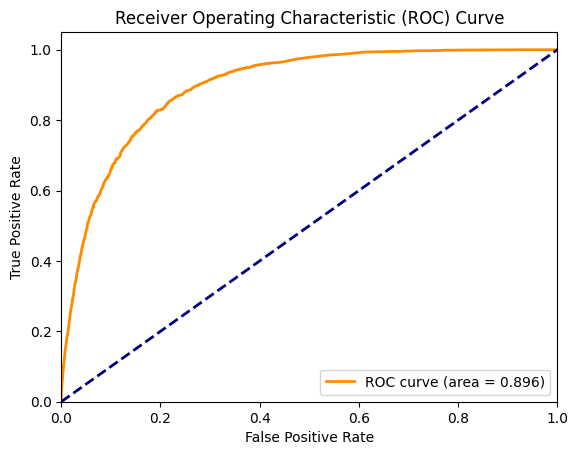

In [150]:
model = CatBoostRanker()

le = LabelEncoder()
kfold_group = le.fit_transform(X_train['query'])

# Fit the model on the training data
model.fit(X_train_fe_used, y_train, kfold_group)

# Predict on the testing data
y_pred_proba = model.predict(X_val_fe_used)
proba_to_predict = lambda proba, threshold=0.5: (proba > threshold).astype(int)
y_pred = proba_to_predict(y_pred_proba)

manual_auc_roc_draw(y_val, y_pred_proba)

In [151]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.6716547863164405
Precision: 0.5434612782061172
Recall: 0.934787708186723
Confusion Matrix:
 [[78556 40073]
 [  278  3985]]


#### Naive Bayes

/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


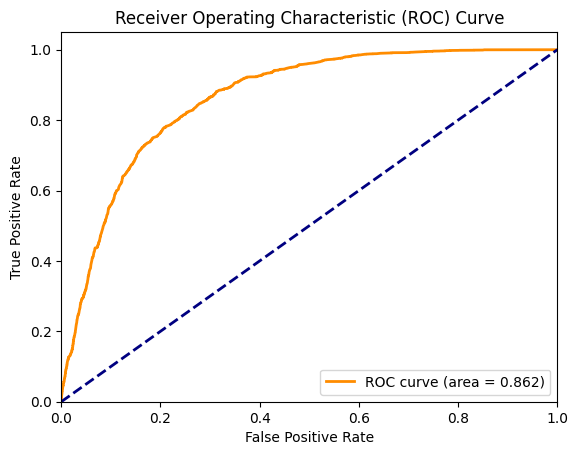

In [152]:
model = BernoulliNB()
model.fit(X_train_fe_used, y_train)

y_pred_proba = model.predict_proba(X_val_fe_used)[:, 1]
y_pred = model.predict(X_val_fe_used)

manual_auc_roc_draw(y_val, y_pred_proba)

In [153]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9190508739380919
Precision: 0.5840619856276847
Recall: 0.4095707248416608
Confusion Matrix:
 [[111198   7431]
 [  2517   1746]]


#### Logistic Regression

/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


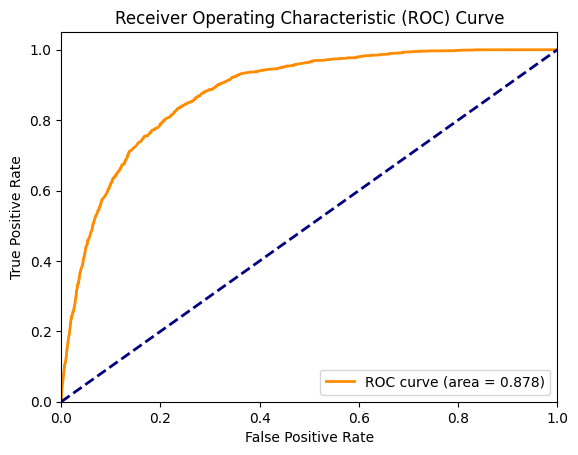

In [154]:
# Create and train the logistic regression model
model = LogisticRegression(random_state=43, max_iter=10000)
model.fit(X_train_fe_used, y_train)

# Predictions
y_pred = model.predict(X_val_fe_used)
y_pred_proba = model.predict_proba(X_val_fe_used)[:, 1]

manual_auc_roc_draw(y_val, y_pred_proba)

In [155]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(y_val, y_pred, average='macro')  # Change 'macro' as needed
print(f'Precision: {precision}')

recall = recall_score(y_val, y_pred)  # Change 'macro' as needed
print(f'Recall: {recall}')

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Accuracy: 0.9650831624515835
Precision: 0.7073792059639057
Recall: 0.02861834388927985
Confusion Matrix:
 [[118479    150]
 [  4141    122]]


Bad pipe message: %s [b"\x0b{\xd9'\xac\x04\xe3\xb4j\xa8\xfe\x86\xcd\xdd\xa5\x06\xe7\xb6 \xd1\xec\x11\xa9K\xd9\xef\x11\x8d3\x17\xe5{\xbe\x0b|\xc2\n\x13qz\xb4\x0c\x9dL\xa2\xdc4\x9a\x858l\x00 \xba\xba\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9fzz\x00\x00\x003\x00+\x00)\n\n\x00\x01\x00\x00\x1d\x00 \xf6\xcdu~\r2\xc8\xba\xa8\xd2%t\x19\xf0\x10\r)\xec\xbf\x96.N\x01o\xee\xdc\xeeP\xd0\xee(\x1a\x00\x0b\x00\x02"]
Bad pipe message: %s [b'']
Bad pipe message: %s [b'r\x13\x00s\xa5\x97V\xa3\x90\xec\xda\xf3\xe3\x11\xdc\xbd\xa3\xbe \xfa?\xe2\xefc\x818\x88%\x18x\x8c\x93\xdfeI\xe0\xa4\x11\x90\n\xb9\x83']
Bad pipe message: %s [b'\xc3\xa9\xe3\xea6\n\x14\x00 \xfa\xfa\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x01\x9f\xba\xba\x00\x00\x00\n\x00\n\x00\x08jj\x00\x1d\x00\x17\x00\x18\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\